# Module Load

In [39]:
!pip install statannotations

In [40]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
from scipy.stats import linregress
from statsmodels.formula.api import mixedlm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import numpy as np
from statannotations.Annotator import Annotator
from scipy.stats import ttest_1samp
# Add legend to explain plot elements
from matplotlib.patches import Patch
from matplotlib.lines import Line2D







# Functions


In [41]:
def regenerate_graphs_with_fdr(participants, roi_dm_contrast, corrected_results, original_results=None):
    """
    Regenerate graphs using FDR-corrected p-values.
    
    Args:
        participants (pd.DataFrame): DataFrame containing participant data
        roi_dm_contrast (str): The name of the ROI contrast column
        corrected_results (dict): Dictionary containing FDR-corrected results
        original_results (dict, optional): Original uncorrected results for comparison
    """
    # Prepare data (same as in roi_analysis_GB)
    roi_dm_contrast = roi_dm_contrast.lower() if any(c.isupper() for c in roi_dm_contrast) else roi_dm_contrast
    participants_ROI_contrast = participants.dropna(subset=[roi_dm_contrast])
    
    columns_to_remove = [
        'dna_chx', 'date_irm', 'grandeur_recherche', 'poids_bioimp_dance'
    ]
    columns_to_remove.extend(
        [col for col in participants_ROI_contrast.columns if col.startswith('z_roi') and col != roi_dm_contrast]
    )
    participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
    participants_ROI_contrast.dropna(inplace=True)
    participants_ROI_contrast.sort_values(by='session', inplace=True)
    
    Y = participants_ROI_contrast[roi_dm_contrast]
    df = participants_ROI_contrast.copy()
    
    # Get FDR-corrected p-values for this ROI
    fdr_between_pvals = []
    fdr_zero_pvals = {}
    
    # Extract FDR-corrected between-session p-values
    if 'between_sessions' in corrected_results:
        between_data = corrected_results['between_sessions']
        for i, roi_name in enumerate(between_data['roi_names']):
            if roi_name == roi_dm_contrast:
                fdr_between_pvals.append(between_data['p_values_corrected'][i])
    
    # Extract FDR-corrected against-zero p-values
    if 'against_zero' in corrected_results:
        zero_data = corrected_results['against_zero']
        for i, (roi_name, session) in enumerate(zip(zero_data['roi_names'], zero_data['sessions'])):
            if roi_name == roi_dm_contrast:
                fdr_zero_pvals[session] = zero_data['p_values_corrected'][i]
    
    # Create the plot with FDR-corrected annotations
    plt.figure(figsize=(10, 8))
    sns.violinplot(data=df, x='session', y=Y, color='lightblue')
    # Parse roi_dm_contrast to create readable title components
    contrast_parts = roi_dm_contrast.split('_')

    # Extract region information
    if 'vmpfc' in roi_dm_contrast.lower():
        region = 'vmPFC'
    elif 'dlpfc' in roi_dm_contrast.lower():
        region = 'dlPFC'
    elif 'vs_l' in roi_dm_contrast.lower():
        region = 'left VS'
    elif 'vs_r' in roi_dm_contrast.lower():
        region = 'right VS'
    else:
        region = 'unknown region'

    # Extract contrast information
    if 'view_vs_view_cross' in roi_dm_contrast:
        positive_element = 'viewing snacks'
        negative_element = 'the cross'
    elif 'hi_sweet_vs_lo_lo' in roi_dm_contrast:
        positive_element = 'HC density and sweet foods'
        negative_element = 'LC density foods'
    elif 'hi_salt_vs_lo_lo' in roi_dm_contrast:
        positive_element = 'HC density and salty foods'
        negative_element = 'LC density foods'
    elif 'hi_sweet_hi_salt_vs_lo_lo' in roi_dm_contrast:
        positive_element = 'HC sweet and salty foods'
        negative_element = 'LC foods'
    else:
        positive_element = 'condition A'
        negative_element = 'condition B'

    # Create readable title
    readable_title = f"Average z-scored effect size in {region} for the contrast of {positive_element} v.s. {negative_element}"
    #plt.title(f"{readable_title}")
    plt.xlabel('Session')
    plt.ylabel('Activation (Z-Score)')
    plt.xticks(ticks=[0, 1, 2, 3], labels=['pre-surgery', '4 months post', '12 months post', '24 months post'])
    
    # Add horizontal dotted line at y=0
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7, linewidth=1)
    
    # Calculate and annotate the average and standard deviation for each session
    average_values = participants_ROI_contrast.groupby('session')[f'{Y.name}'].mean()
    std_values = participants_ROI_contrast.groupby('session')[f'{Y.name}'].std()
    for i, (avg, std) in enumerate(zip(average_values, std_values)):
        plt.text(i, avg, f'{avg:.2f} ± {std:.2f}', ha='center', va='bottom', color='black', fontsize=10)
    
    # Calculate positioning for brackets
    max_data_value = Y.max()
    y_range = Y.max() - Y.min()
    bracket_base_height = max_data_value + y_range * 0.15
    bracket_height_increment = y_range * 0.08
    
    ax = plt.gca()
    
    # Draw brackets with FDR-corrected p-values for between-session comparisons
    bracket_pairs = [(0, 1), (0, 2), (0, 3)]
    
    for i, (x1, x2) in enumerate(bracket_pairs):
        if i < len(fdr_between_pvals):
            p_val = fdr_between_pvals[i]
            # Format p-value for display
            if p_val < 0.001:
                p_text = '***'
            elif p_val < 0.01:
                p_text = '**'
            elif p_val < 0.05:
                p_text = '*'
            else:
                p_text = 'n.s.'
            
            # Calculate bracket height
            bracket_y = bracket_base_height + (i * bracket_height_increment)
            
            # Draw the bracket
            ax.plot([x1, x2], [bracket_y, bracket_y], color='black', linewidth=1.5)
            ax.plot([x1, x1], [bracket_y, bracket_y - bracket_height_increment * 0.3], color='black', linewidth=1.5)
            ax.plot([x2, x2], [bracket_y, bracket_y - bracket_height_increment * 0.3], color='black', linewidth=1.5)
            
            # Add p-value text above the bracket
            bracket_center = (x1 + x2) / 2
            ax.text(bracket_center, bracket_y + bracket_height_increment * 0.2, p_text, 
                    ha='center', va='bottom', color='black', fontsize=9, weight='bold')
    
    # Set y-axis limits to accommodate all brackets
    max_bracket_height = bracket_base_height + (len(bracket_pairs) - 1) * bracket_height_increment + bracket_height_increment * 0.4
    current_y_min, current_y_max = ax.get_ylim()
    new_y_max = max(current_y_max, max_bracket_height)
    ax.set_ylim(current_y_min, new_y_max)
    
    # Add FDR-corrected against-zero annotations
    for i, session in enumerate(sorted(participants_ROI_contrast['session'].unique(), key=lambda x: int(x))):
        avg = average_values.loc[session]
        
        # Get FDR-corrected p-value for this session
        if session in fdr_zero_pvals:
            pval = fdr_zero_pvals[session]
            # Set annotation text based on FDR-corrected p-value
            if pval < 0.001:
                annotation = '***'
            elif pval < 0.01:
                annotation = '**'
            elif pval < 0.05:
                annotation = '*'
            else:
                annotation = 'n.s.'
        else:
            annotation = 'n.a.'  # Not available
        
        # Position the hook to the side of the violin plot
        hook_x_position = i + 0.35
        hook_width = 0.05
        
        # Draw the hook from mean to zero
        ax.plot([hook_x_position, hook_x_position], [min(0, avg), max(0, avg)], color='darkred', linestyle='-', linewidth=2)
        ax.plot([hook_x_position - hook_width, hook_x_position], [0, 0], color='darkred', linestyle='-', linewidth=2)
        ax.plot([hook_x_position - hook_width, hook_x_position], [avg, avg], color='darkred', linestyle='-', linewidth=2)
        
        # Place annotation
        annotation_y = (avg + 0) / 2
        ax.text(hook_x_position + 0.15, annotation_y, annotation, ha='center', va='center', color='darkred', fontsize=9, weight='bold')
    
    # Adjust subplot and add legend
    plt.subplots_adjust(bottom=0.2)
    
    legend_text = """Legend: Violins = Data distribution | Black text = Mean ± SD | Black brackets = Between-session comparisons (Mixed-effects model, FDR-corrected)
Red hooks = Comparison vs. zero (One-sample t-tests, FDR-corrected) | *** p<0.001, ** p<0.01, * p<0.05, n.s. = not significant"""
    
    fig = plt.gcf()
    #fig.text(0.5, 0.09, legend_text, ha='center', va='center', fontsize=10,
       #      bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgray', alpha=0.8))
    
    plt.show()
    
    # Print FDR-corrected results summary for this ROI
    print(f"\n{'='*50}")
    print(f"FDR-CORRECTED RESULTS FOR: {roi_dm_contrast}")
    print(f"{'='*50}")
    
    if fdr_between_pvals:
        print("\nBetween-session comparisons (FDR-corrected):")
        comparisons = ['4_months_vs_pre', '12_months_vs_pre', '24_months_vs_pre']
        for i, (comp, p_val) in enumerate(zip(comparisons, fdr_between_pvals)):
            sig_status = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "n.s."
            print(f"  {comp}: p_FDR = {p_val:.6f} ({sig_status})")
    
    if fdr_zero_pvals:
        print("\nAgainst-zero comparisons (FDR-corrected):")
        session_names = {'1': 'Pre-surgery', '2': '4 months', '3': '12 months', '4': '24 months'}
        for session, p_val in fdr_zero_pvals.items():
            sig_status = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "n.s."
            print(f"  {session_names.get(session, f'Session {session}')}: p_FDR = {p_val:.6f} ({sig_status})")


def regenerate_all_graphs_with_fdr(participants, contrasts_to_analyze, corrected_results):
    """
    Regenerate all graphs with FDR-corrected p-values.
    
    Args:
        participants (pd.DataFrame): DataFrame containing participant data
        contrasts_to_analyze (list): List of contrast names to analyze
        corrected_results (dict): Dictionary containing FDR-corrected results
    """
    print(f"\n{'='*80}")
    print("REGENERATING ALL GRAPHS WITH FDR-CORRECTED P-VALUES")
    print(f"{'='*80}")
    
    for contrast in contrasts_to_analyze:
        print(f"\n🎨 Regenerating graph for: {contrast}")
        try:
            regenerate_graphs_with_fdr(participants, contrast, corrected_results)
        except Exception as e:
            print(f"Error regenerating graph for {contrast}: {e}")
            continue

## Describe a column

In [42]:

def describe_column(column_name):
    # Describe the column
    description = redcap[column_name].describe()
    print(description)
    
    # Count the number of NaN values in the column
    nan_count = redcap[column_name].isna().sum()
    print(f"Number of NaN values: {nan_count}")

# Example usage
#describe_column('redcap_survey_identifier')

## Basic stat

In [43]:
def basic_stat(df):
    # Initialize the DataFrame with the specified columns
    results = pd.DataFrame(columns=['Pré-Chirurgie', '4 mois', '12 mois', '24 mois', 'Valeur P'])

    # Extend type_chx
    df['session'] = df['session'].astype(str)

    # Fill NaN values in type_chx column with the value from session 1 for the same id_participant
    df['type_chx'] = df.groupby('id_participant')['type_chx'].transform(lambda x: x.fillna(x.iloc[0]))
    # Fill NaN values in sexe column with the value from session 1 for the same id_participant
    df['sexe'] = df.groupby('id_participant')['sexe'].transform(lambda x: x.fillna(x.iloc[0]))

    # Count the unique id_participant for session = 1,2,3,4
    unique_participants_per_session = df.groupby('session')['id_participant'].nunique()

    # Extract the number of unique participants for each session
    N_pre_chirurgie = unique_participants_per_session.get('1', 0)
    N_4_mois = unique_participants_per_session.get('2', 0)
    N_12_mois = unique_participants_per_session.get('3', 0)
    N_24_mois = unique_participants_per_session.get('4', 0)

    # Calculate the mean and standard deviation of age for each session
    mean_age_per_session = df.groupby('session')['age'].mean()
    std_age_per_session = df.groupby('session')['age'].std()

    # Extract the mean and standard deviation of age for each session
    mean_std_age_pre_chirurgie = f"{mean_age_per_session.get('1', 0):.2f} ± {std_age_per_session.get('1', 0):.2f}"
    mean_std_age_4_mois = f"{mean_age_per_session.get('2', 0):.2f} ± {std_age_per_session.get('2', 0):.2f}"
    mean_std_age_12_mois = f"{mean_age_per_session.get('3', 0):.2f} ± {std_age_per_session.get('3', 0):.2f}"
    mean_std_age_24_mois = f"{mean_age_per_session.get('4', 0):.2f} ± {std_age_per_session.get('4', 0):.2f}"

    # Count the number of sexe = 1 per unique id_participant for each session
    sexeF_counts_per_session = df[df['sexe'] == 1].drop_duplicates(subset=['session', 'id_participant']).groupby('session')['id_participant'].nunique()

    # Count the number of sexe = 2 per unique id_participant for each session
    sexeM_counts_per_session = df[df['sexe'] == 2].drop_duplicates(subset=['session', 'id_participant']).groupby('session')['id_participant'].nunique()

    # Create the variables for each session
    sexe_pre_chirurgie = {2: sexeM_counts_per_session.get('1', 0), 1: sexeF_counts_per_session.get('1', 0)}
    sexe_4_mois = {2: sexeM_counts_per_session.get('2', 0), 1: sexeF_counts_per_session.get('2', 0)}
    sexe_12_mois = {2: sexeM_counts_per_session.get('3', 0), 1: sexeF_counts_per_session.get('3', 0)}
    sexe_24_mois = {2: sexeM_counts_per_session.get('4', 0), 1: sexeF_counts_per_session.get('4', 0)}

    # Count the number of times type_chx = 1 per unique id_participant for each session
    gastrectomie_counts_per_session = df[df['type_chx'] == 1].drop_duplicates(subset=['session', 'id_participant']).groupby(['session', 'id_participant']).size().unstack(fill_value=0)

    gastrectomie_pre_chirurgie = gastrectomie_counts_per_session.loc['1'].sum() if '1' in gastrectomie_counts_per_session.index else 0
    gastrectomie_4_mois = gastrectomie_counts_per_session.loc['2'].sum() if '2' in gastrectomie_counts_per_session.index else 0
    gastrectomie_12_mois = gastrectomie_counts_per_session.loc['3'].sum() if '3' in gastrectomie_counts_per_session.index else 0
    gastrectomie_24_mois = gastrectomie_counts_per_session.loc['4'].sum() if '4' in gastrectomie_counts_per_session.index else 0

    # Count the number of times type_chx = 2 per unique id_participant for each session
    rygb_counts_per_session = df[df['type_chx'] == 2].drop_duplicates(subset=['session', 'id_participant']).groupby(['session', 'id_participant']).size().unstack(fill_value=0)

    rygb_pre_chirurgie = rygb_counts_per_session.loc['1'].sum() if '1' in rygb_counts_per_session.index else 0
    rygb_4_mois = rygb_counts_per_session.loc['2'].sum() if '2' in rygb_counts_per_session.index else 0
    rygb_12_mois = rygb_counts_per_session.loc['3'].sum() if '3' in rygb_counts_per_session.index else 0
    rygb_24_mois = rygb_counts_per_session.loc['4'].sum() if '4' in rygb_counts_per_session.index else 0

    # Count the number of times type_chx = 3 per unique id_participant for each session
    dbp_sd_counts_per_session = df[df['type_chx'] == 3].drop_duplicates(subset=['session', 'id_participant']).groupby(['session', 'id_participant']).size().unstack(fill_value=0)

    dbp_sd_pre_chirurgie = dbp_sd_counts_per_session.loc['1'].sum() if '1' in dbp_sd_counts_per_session.index else 0
    dbp_sd_4_mois = dbp_sd_counts_per_session.loc['2'].sum() if '2' in dbp_sd_counts_per_session.index else 0
    dbp_sd_12_mois = dbp_sd_counts_per_session.loc['3'].sum() if '3' in dbp_sd_counts_per_session.index else 0
    dbp_sd_24_mois = dbp_sd_counts_per_session.loc['4'].sum() if '4' in dbp_sd_counts_per_session.index else 0

    # Calculate the mean and standard deviation of imc_recherche for each session
    mean_imc_per_session = df.groupby('session')['imc_recherche'].mean()
    std_imc_per_session = df.groupby('session')['imc_recherche'].std()

    # Extract the mean and standard deviation of imc_recherche for each session
    mean_std_imc_pre_chirurgie = f"{mean_imc_per_session.get('1', 0):.2f} ± {std_imc_per_session.get('1', 0):.2f}"
    mean_std_imc_4_mois = f"{mean_imc_per_session.get('2', 0):.2f} ± {std_imc_per_session.get('2', 0):.2f}"
    mean_std_imc_12_mois = f"{mean_imc_per_session.get('3', 0):.2f} ± {std_imc_per_session.get('3', 0):.2f}"
    mean_std_imc_24_mois = f"{mean_imc_per_session.get('4', 0):.2f} ± {std_imc_per_session.get('4', 0):.2f}"

    # Calculate the mean and standard deviation of twl_recherche_x for each session
    mean_twl_per_session = df.groupby('session')['twl_recherche'].mean() * 100
    std_twl_per_session = df.groupby('session')['twl_recherche'].std() * 100

    # Extract the mean and standard deviation of twl_recherche_x for each session
    mean_std_twl_pre_chirurgie = f"{mean_twl_per_session.get('1', 0):.2f} ± {std_twl_per_session.get('1', 0):.2f}"
    mean_std_twl_4_mois = f"{mean_twl_per_session.get('2', 0):.2f} ± {std_twl_per_session.get('2', 0):.2f}"
    mean_std_twl_12_mois = f"{mean_twl_per_session.get('3', 0):.2f} ± {std_twl_per_session.get('3', 0):.2f}"
    mean_std_twl_24_mois = f"{mean_twl_per_session.get('4', 0):.2f} ± {std_twl_per_session.get('4', 0):.2f}"

    # Add the mean and standard deviation of age to the results DataFrame
    results.loc['N'] = [N_pre_chirurgie, N_4_mois, N_12_mois, N_24_mois, None]
    results.loc['Age (mean ± std)'] = [mean_std_age_pre_chirurgie, mean_std_age_4_mois, mean_std_age_12_mois, mean_std_age_24_mois, None]
    # Format the counts as "count of 2 : count of 1"
    format_sexe_counts = lambda counts: f"{counts.get(2, 0)} : {counts.get(1, 0)}"
    results.loc['Sexe (M:F)'] = [format_sexe_counts(sexe_pre_chirurgie), format_sexe_counts(sexe_4_mois), format_sexe_counts(sexe_12_mois), format_sexe_counts(sexe_24_mois), None]
    # Add the gastrectomie counts to the results DataFrame
    results.loc['Gastrectomie (n)'] = [gastrectomie_pre_chirurgie, gastrectomie_4_mois, gastrectomie_12_mois, gastrectomie_24_mois, None]
    # Add the RYGB counts to the results DataFrame
    results.loc['RYGB (n)'] = [rygb_pre_chirurgie, rygb_4_mois, rygb_12_mois, rygb_24_mois, None]

    # Add the DBP-SD counts to the results DataFrame
    results.loc['DBP-SD (n)'] = [dbp_sd_pre_chirurgie, dbp_sd_4_mois, dbp_sd_12_mois, dbp_sd_24_mois, None]

    # Add the mean and standard deviation of imc_recherche to the results DataFrame
    results.loc['IMC (kg/m2) (moy. ± et.)'] = [mean_std_imc_pre_chirurgie, mean_std_imc_4_mois, mean_std_imc_12_mois, mean_std_imc_24_mois, None]

    # Add the mean and standard deviation of twl_recherche_x to the results DataFrame
    results.loc['Pourcentage de perte de poids (%)'] = [mean_std_twl_pre_chirurgie, mean_std_twl_4_mois, mean_std_twl_12_mois, mean_std_twl_24_mois, None]

    return results


## Analysis and plot function

In [44]:
def roi_analysis_GB(participants, roi_dm_contrast, results_storage=None, verbose=True, plot=True, min_2_ses = False):

    """    Perform a mixed model analysis on the specified ROI contrast data.
    Args:
        participants (pd.DataFrame): DataFrame containing participant data.
        roi_dm_contrast (str): The name of the column in participants DataFrame to analyze.
        results_storage (dict, optional): Dictionary to store statistical results for FDR correction.
                                        If None, results are not stored for FDR correction.
        verbose (bool): If True, display print statements (default: True).
        plot (bool): If True, display plots (default: True).
        min_2_ses (bool): If True, ensure at least 2 sessions are present for analysis (default: False).
    Returns:
        results (pd.DataFrame): DataFrame containing basic statistics for the specified ROI contrast.
        mixed_model_fit (MixedLMResultsWrapper): Fitted mixed model results.
        t_test_results (dict): Dictionary containing t-test results for each session.
        Also returns various diagnostic plots and statistics as cell outputs (not stored)
    """
    
    # Ensure the column name is lowercase
    roi_dm_contrast = roi_dm_contrast.lower() if any(c.isupper() for c in roi_dm_contrast) else roi_dm_contrast

    # Create a new DataFrame excluding rows with NaN in the column specified by roi_dm_contrast
    participants_ROI_contrast = participants.dropna(subset=[roi_dm_contrast])

    # Columns to remove
    columns_to_remove = [
        'dna_chx',
        'date_irm',
        'grandeur_recherche',
        'poids_bioimp_dance'
    ]

    # Add all columns that start with 'z_roi' except the one stored in roi_dm_contrast
    columns_to_remove.extend(
        [col for col in participants_ROI_contrast.columns if col.startswith('z_roi') and col != roi_dm_contrast]
    )

    # Remove columns only if they exist in the DataFrame
    participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)

    # Drop rows with NaN values and sort by session
    participants_ROI_contrast.dropna(inplace=True)
    participants_ROI_contrast.sort_values(by='session', inplace=True)

    # Handle if less than 2 sessions are present.
    if min_2_ses:
        counts = participants_ROI_contrast['id_participant'].value_counts()
        single_session_ids = counts[counts == 1].index
        participants_ROI_contrast = participants_ROI_contrast[~participants_ROI_contrast['id_participant'].isin(single_session_ids)]

    # Perform basic statistics
    results = basic_stat(participants_ROI_contrast)

    # Intermediate vars for LMM
    Y = participants_ROI_contrast[roi_dm_contrast]
    df = participants_ROI_contrast.copy()

    # Define the formula
    formula = f'{Y.name} ~ session + type_chx + age + IMC_baseline + sexe'

    # Fit the mixed model
    mixed_model = smf.mixedlm(formula, df, groups=df['id_participant'])
    mixed_model_fit = mixed_model.fit()

    # Store results for FDR correction if results_storage is provided
    if results_storage is not None:
        # Store between-session comparison p-values and betas
        session_indices = [1, 2, 3]  # indices for session comparisons in the model
        session_comparisons = ['4_months_vs_pre', '12_months_vs_pre', '24_months_vs_pre']
        
        for i, comparison in enumerate(session_comparisons):
            p_val = mixed_model_fit.pvalues[session_indices[i]]
            beta = mixed_model_fit.params[session_indices[i]]
            
            # Store in results_storage dictionary
            if 'between_sessions' not in results_storage:
                results_storage['between_sessions'] = {
                    'roi_names': [],
                    'comparisons': [],
                    'p_values': [],
                    'beta_values': []
                }
            
            results_storage['between_sessions']['roi_names'].append(roi_dm_contrast)
            results_storage['between_sessions']['comparisons'].append(comparison)
            results_storage['between_sessions']['p_values'].append(p_val)
            results_storage['between_sessions']['beta_values'].append(beta)

    # Print the summary table of the fitted mixed model
    if verbose:
        print(mixed_model_fit.summary())

    if plot:
        # Residuals vs fitted values
        residuals = mixed_model_fit.resid
        fitted_values = mixed_model_fit.fittedvalues
        sns.scatterplot(x=fitted_values, y=residuals)
        plt.xlabel('Fitted values')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Fitted values')
        plt.show()

        # QQ-plot of residuals
        sm.qqplot(residuals, line='45')
        plt.title('QQ-plot of Residuals')
        plt.show()

    # Breusch-Pagan test for homoscedasticity
    bp_test = het_breuschpagan(mixed_model_fit.resid, mixed_model_fit.model.exog)
    bp_pvalue = bp_test[1]
    if verbose:
        print(f"Breusch-Pagan test p-value: {bp_pvalue}")
        if bp_pvalue < 0.05:
            print("Heteroscedasticity detected. The variance of residuals is not constant.")
        else:
            print("No heteroscedasticity detected. The variance of residuals is constant.")

    # Shapiro-Wilk test for normality of residuals
    shapiro_test = stats.shapiro(mixed_model_fit.resid)
    if verbose:
        print(f"Shapiro-Wilk test p-value: {shapiro_test.pvalue}")
        if shapiro_test.pvalue < 0.05:
            print("Residuals are not normally distributed.")
        else:
            print("Residuals are normally distributed.")

    # Calculate VIF for each predictor
    vif_data = pd.DataFrame()
    vif_data["feature"] = mixed_model_fit.model.exog_names
    vif_data["VIF"] = [variance_inflation_factor(mixed_model_fit.model.exog, i) for i in range(mixed_model_fit.model.exog.shape[1])]
    if verbose:
        print(vif_data)

    # Perform a Wald test
    wald_test = mixed_model_fit.wald_test_terms()
    if verbose:
        print(wald_test)

    # Calculate AIC and BIC
    k = len(mixed_model_fit.params)
    n = mixed_model_fit.nobs
    log_likelihood = mixed_model_fit.llf
    aic = 2 * k - 2 * log_likelihood
    bic = np.log(n) * k - 2 * log_likelihood
    if verbose:
        print(f"AIC: {aic}")
        print(f"BIC: {bic}")

    # Perform a t-test against 0 for roi_dm_contrast for each session
    t_test_results = {}
    for session, group in participants_ROI_contrast.groupby('session'):
        t_stat, p_value = ttest_1samp(group[roi_dm_contrast], 0)
        t_test_results[session] = {'t_stat': t_stat, 'p_value': p_value}
        
        # Store results for FDR correction if results_storage is provided
        if results_storage is not None:
            if 'against_zero' not in results_storage:
                results_storage['against_zero'] = {
                    'roi_names': [],
                    'sessions': [],
                    'p_values': [],
                    't_values': []
                }
            
            results_storage['against_zero']['roi_names'].append(roi_dm_contrast)
            results_storage['against_zero']['sessions'].append(session)
            results_storage['against_zero']['p_values'].append(p_value)
            results_storage['against_zero']['t_values'].append(t_stat)

    # Display the t-test results
    if verbose:
        for session, result in t_test_results.items():
            print(f"Session {session}: t-statistic = {result['t_stat']:.4f}, p-value = {result['p_value']:.4f}")

    if plot:
        # Plotting the raw data with all annotations combined
        plt.figure(figsize=(10, 8))  # Increased height to accommodate legend
        sns.violinplot(data=df, x='session', y=Y, color='lightblue')
        plt.title(roi_dm_contrast)
        plt.xlabel('Session')
        plt.ylabel('Activation (Z-Score)')
        plt.xticks(ticks=[0, 1, 2, 3], labels=['pre-surgery', '4 months post', '12 months post', '24 months post'])

        # Add horizontal dotted line at y=0 for reference (makes red brackets more meaningful)
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7, linewidth=1)

        # Calculate and annotate the average and standard deviation for each session
        average_values = participants_ROI_contrast.groupby('session')[f'{Y.name}'].mean()
        std_values = participants_ROI_contrast.groupby('session')[f'{Y.name}'].std()
        for i, (avg, std) in enumerate(zip(average_values, std_values)):
            plt.text(i, avg, f'{avg:.2f} ± {std:.2f}', ha='center', va='bottom', color='black', fontsize=10)

        # Adding statistical significance annotations for mixed model comparisons
        pairs = [('1', '2'), ('1', '3'), ('1', '4')]
        indices = [1, 2, 3]
        p_values = [mixed_model_fit.pvalues[i] for i in indices]
        ax = plt.gca()
        
        # Calculate the maximum value across all sessions to position brackets above violin peaks
        max_data_value = Y.max()
        # Add padding above the maximum value for proper bracket spacing
        y_range = Y.max() - Y.min()
        
        # Manually draw brackets to ensure proper positioning above violin peaks
        # Starting height for brackets - well above the maximum data value
        bracket_base_height = max_data_value + y_range * 0.15
        bracket_height_increment = y_range * 0.08  # Spacing between bracket levels
        
        # Draw brackets manually for better control
        bracket_pairs = [(0, 1), (0, 2), (0, 3)]  # session indices for plotting (0-based)
        p_val_labels = []
        
        for i, (x1, x2) in enumerate(bracket_pairs):
            p_val = p_values[i]
            # Format p-value for display
            if p_val < 0.001:
                p_text = '***'
            elif p_val < 0.01:
                p_text = '**'
            elif p_val < 0.05:
                p_text = '*'
            else:
                p_text = 'n.s.'
            
            # Calculate bracket height (stagger them)
            bracket_y = bracket_base_height + (i * bracket_height_increment)
            
            # Draw the bracket
            # Horizontal line
            ax.plot([x1, x2], [bracket_y, bracket_y], color='black', linewidth=1.5)
            # Vertical lines at ends
            ax.plot([x1, x1], [bracket_y, bracket_y - bracket_height_increment * 0.3], color='black', linewidth=1.5)
            ax.plot([x2, x2], [bracket_y, bracket_y - bracket_height_increment * 0.3], color='black', linewidth=1.5)
            
            # Add p-value text above the bracket
            bracket_center = (x1 + x2) / 2
            ax.text(bracket_center, bracket_y + bracket_height_increment * 0.2, p_text, 
                    ha='center', va='bottom', color='black', fontsize=9, weight='bold')

        # Set y-axis limits to accommodate all brackets and hooks
        # Calculate the top position needed for all brackets
        max_bracket_height = bracket_base_height + (len(bracket_pairs) - 1) * bracket_height_increment + bracket_height_increment * 0.4
        
        # Get current y-axis limits and adjust if needed
        current_y_min, current_y_max = ax.get_ylim()
        new_y_max = max(current_y_max, max_bracket_height)
        ax.set_ylim(current_y_min, new_y_max)
        
        # Calculate the actual data range for determining hook visibility
        data_min = Y.min()
        data_max = Y.max()
        data_range = data_max - data_min
        
        # Annotate t-test results (comparison against 0) on the same violin plot
        for i, session in enumerate(sorted(participants_ROI_contrast['session'].unique(), key=lambda x: int(x))):
            avg = average_values.loc[session]
            pval = t_test_results[session]['p_value']
            # Set annotation text based on p-value
            if pval < 0.001:
                annotation = '***'
            elif pval < 0.01:
                annotation = '**'
            elif pval < 0.05:
                annotation = '*'
            else:
                annotation = 'n.s.'
            
            # Position the hook to the side of the violin plot
            hook_x_position = i + 0.35  # Move hook to the right side of each violin
            hook_width = 0.05  # Width of the horizontal lines
            
            # Always draw the hook/bracket from mean to zero on the side
            # Vertical line from mean to zero
            ax.plot([hook_x_position, hook_x_position], [min(0, avg), max(0, avg)], color='darkred', linestyle='-', linewidth=2)
            # Small horizontal lines at both ends to make it look like a bracket
            ax.plot([hook_x_position - hook_width, hook_x_position], [0, 0], color='darkred', linestyle='-', linewidth=2)
            ax.plot([hook_x_position - hook_width, hook_x_position], [avg, avg], color='darkred', linestyle='-', linewidth=2)
            
            # Place annotation centered vertically next to the hook, with more spacing
            annotation_y = (avg + 0) / 2  # Center between mean and zero
            ax.text(hook_x_position + 0.15, annotation_y, annotation, ha='center', va='center', color='darkred', fontsize=9, weight='bold')
        
        # Adjust subplot to create space for legend below
        plt.subplots_adjust(bottom=0.2)  # Create extra space at bottom
        
        # Add legend text box below the x-axis, constrained to plot area width
        legend_text = """Legend: Violins = Data distribution | Black text = Mean ± SD | Black brackets = Between-session comparisons (Mixed-effects model)
Red hooks = Comparison vs. zero (One-sample t-tests) | *** p<0.001, ** p<0.01, * p<0.05, n.s. = not significant"""
        
        # Position the text box closer to x-axis and constrained to plot width
        fig = plt.gcf()
        # Get the axes position to constrain legend width
        ax_pos = ax.get_position()
        fig.text(0.5, 0.09, legend_text, ha='center', va='center', fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgray', alpha=0.8))
        
        plt.show()

    return results, mixed_model_fit, t_test_results

In [45]:
def perform_fdr_correction(results_storage, alpha=0.05, method='fdr_bh'):
    """
    Perform FDR correction on all collected p-values.
    
    Args:
        results_storage (dict): Dictionary containing stored statistical results
        alpha (float): Significance level (default: 0.05)
        method (str): FDR correction method (default: 'fdr_bh' for Benjamini-Hochberg)
    
    Returns:
        dict: Dictionary containing corrected results with FDR-adjusted p-values
    """
    from statsmodels.stats.multitest import multipletests
    
    corrected_results = {}
    
    # Process between-sessions comparisons
    if 'between_sessions' in results_storage:
        between_data = results_storage['between_sessions']
        p_values = between_data['p_values']
        
        # Perform FDR correction
        rejected, p_corrected, alpha_sidak, alpha_bonf = multipletests(
            p_values, alpha=alpha, method=method
        )
        
        # Store corrected results
        corrected_results['between_sessions'] = {
            'roi_names': between_data['roi_names'].copy(),
            'comparisons': between_data['comparisons'].copy(),
            'p_values_raw': between_data['p_values'].copy(),
            'p_values_corrected': p_corrected.tolist(),
            'beta_values': between_data['beta_values'].copy(),
            'significant_fdr': rejected.tolist(),
            'alpha_corrected': alpha_bonf
        }
        
        print("=== FDR CORRECTION RESULTS: BETWEEN-SESSIONS COMPARISONS ===")
        print(f"Method: {method}, Alpha: {alpha}")
        print(f"Number of tests: {len(p_values)}")
        print(f"Number of significant results (FDR-corrected): {sum(rejected)}")
        print()
        
        # Create a summary DataFrame
        summary_df = pd.DataFrame({
            'ROI': between_data['roi_names'],
            'Comparison': between_data['comparisons'],
            'Beta': [f"{beta:.4f}" for beta in between_data['beta_values']],
            'P_raw': [f"{p:.4f}" for p in between_data['p_values']],
            'P_FDR': [f"{p:.4f}" for p in p_corrected],
            'Significant_FDR': ['Yes' if sig else 'No' for sig in rejected]
        })
        print(summary_df.to_string(index=False))
        print()
    
    # Process against-zero comparisons
    if 'against_zero' in results_storage:
        zero_data = results_storage['against_zero']
        p_values = zero_data['p_values']
        
        # Perform FDR correction
        rejected, p_corrected, alpha_sidak, alpha_bonf = multipletests(
            p_values, alpha=alpha, method=method
        )
        
        # Store corrected results
        corrected_results['against_zero'] = {
            'roi_names': zero_data['roi_names'].copy(),
            'sessions': zero_data['sessions'].copy(),
            'p_values_raw': zero_data['p_values'].copy(),
            'p_values_corrected': p_corrected.tolist(),
            't_values': zero_data['t_values'].copy(),
            'significant_fdr': rejected.tolist(),
            'alpha_corrected': alpha_bonf
        }
        
        print("=== FDR CORRECTION RESULTS: AGAINST-ZERO COMPARISONS ===")
        print(f"Method: {method}, Alpha: {alpha}")
        print(f"Number of tests: {len(p_values)}")
        print(f"Number of significant results (FDR-corrected): {sum(rejected)}")
        print()
        
        # Create a summary DataFrame
        summary_df = pd.DataFrame({
            'ROI': zero_data['roi_names'],
            'Session': zero_data['sessions'],
            'T_stat': [f"{t:.4f}" for t in zero_data['t_values']],
            'P_raw': [f"{p:.4f}" for p in zero_data['p_values']],
            'P_FDR': [f"{p:.4f}" for p in p_corrected],
            'Significant_FDR': ['Yes' if sig else 'No' for sig in rejected]
        })
        print(summary_df.to_string(index=False))
        print()
    
    return corrected_results

## Contrast function

In [46]:
def run_contrast(mixed_model_fit, list_of_values):
    """
    Run a contrast test on a fitted mixed model.

    Args:
        mixed_model_fit: Fitted statsmodels mixedlm result.
        list_of_values: List or array of contrast weights.

    Returns:
        contrast_results: The result of the t_test.
    """
    contrast_matrix = np.array([list_of_values])
    print(contrast_matrix.shape)
    contrast_results = mixed_model_fit.t_test(contrast_matrix)
    print(contrast_results)
    return contrast_results

# Data load and prep

## Load Raw Participant file

In [47]:

# # Load the CSV file
# file_path = r'\\wsl.localhost\Ubuntu\home\gagpat01\mes_projets\maitrise\fmri\data\participants.tsv'
# participants = pd.read_csv(file_path, delimiter='\t')
# participants

# Load the CSV file from the adjusted path for your current computer
file_path = '/home/gagpat01/Documents/GutBrain/BIDS_results/participants.tsv'
participants = pd.read_csv(file_path, delimiter='\t')
participants


Subject id Session  sexe  t2d  type_chx         dna  dna_chx  tx_t2d___1  \
0       RCX096       1   2.0  1.0       2.0   8/12/1961     55.2         1.0   
1       RCX096       2   NaN  NaN       NaN   8/12/1961      NaN         NaN   
2       RCX096       3   NaN  NaN       NaN   8/12/1961      NaN         NaN   
3       RCX096       4   NaN  NaN       NaN   8/12/1961      NaN         NaN   
4       RND001       1   1.0  2.0       2.0    8/2/1970     46.2         0.0   
..         ...     ...   ...  ...       ...         ...      ...         ...   
441     RND076       1   1.0  2.0       1.0  12/10/1976     45.6         0.0   
442     RND076       2   NaN  NaN       NaN  12/10/1976      NaN         NaN   
443     RND076       3   NaN  NaN       NaN  12/10/1976      NaN         NaN   
444     RND076       4   NaN  NaN       NaN         NaN      NaN         NaN   
445        NaN       1   NaN  NaN       NaN         NaN      NaN         0.0   

     tx_t2d___2  tx_t2d___3  ...  \
0           1.0         0.0  ...   
1           NaN         NaN  ...   
2           NaN         NaN  ...   
3           NaN         NaN  ...   
4           0.0         0.0  ...   
..          ...         ...  ...   
441         0.0         0.0  ...   
442         NaN         NaN  ...   
443         NaN         NaN  ...   
444         NaN         NaN  ...   
445         0.0         0.0  ...   

     Z_ROI_ssib_v1_mod_view_Hi_Salt_vs_Lo_Lo_mask_VS_L  \
0                                                  NaN   
1                                            -0.023141   
2                                            -0.684394   
3                                             0.809424   
4                                                  NaN   
..                                                 ...   
441                                           0.774775   
442                                           1.428132   
443                                          -0.301891   
444                                                NaN   
445                                                NaN   

    Z_ROI_ssib_v1_mod_view_Hi_Salt_vs_Lo_Lo_mask_VS_R  \
0                                                 NaN   
1                                           -0.354510   
2                                            0.362192   
3                                            0.146971   
4                                                 NaN   
..                                                ...   
441                                          0.328386   
442                                          1.457359   
443                                          0.654151   
444                                               NaN   
445                                               NaN   

     Z_ROI_ssib_v1_mod_view_Hi_Sweet_vs_Lo_Lo_mask_vmPFC_L_merged  \
0                                                  NaN              
1                                            -0.830288              
2                                            -0.358453              
3                                            -0.949778              
4                                                  NaN              
..                                                 ...              
441                                           0.297726              
442                                           0.327351              
443                                          -0.341411              
444                                                NaN              
445                                                NaN              

     Z_ROI_ssib_v1_mod_view_Hi_Sweet_vs_Lo_Lo_mask_dlPFC_R_merged  \
0                                                  NaN              
1                                             0.363605              
2                                             1.315133              
3                                             0.885505              
4                                                  NaN

## Prepare participant file for ROI analysis

In [48]:
# Replace 'Subjectid' with 'id_participant' in the column names
participants.rename(columns={'Subject id': 'id_participant'}, inplace=True)

# Convert all string values in the dataframe to lowercase using DataFrame.map
participants = participants.map(lambda x: x.lower() if isinstance(x, str) else x)

# Lowercase all column labels
participants.columns = participants.columns.str.lower()

# Ensure the 'session' column is a string
participants['session'] = participants['session'].astype(str)


# Add a column called IMC_baseline, which is equal to the imc_recherche column for session one, per participant
participants['IMC_baseline'] = participants.groupby('id_participant')['imc_recherche'].transform(lambda x: x.iloc[0])

# Fill NaN values in specified columns with the value from session 1 for the same id_participant
columns_to_fill = ['sexe', 't2d', 'type_chx', 'tx_t2d___1', 'tx_t2d___2', 'tx_t2d___3', 'main_dominante','IMC_baseline']
for column in columns_to_fill:
    participants[column] = participants.groupby('id_participant')[column].transform(lambda x: x.fillna(x.iloc[0]))






# Results for masks from the 2023 newton-fenner et al ROIs (vmPFC L, dlPFC R, VS R, VS L)

## results for the simple design matrix : 

Bold signal = ViewSnacks + ModByBidViewSnacks + ViewCross + 6MotionRegressors + CSF + WM + Drift

### vmPFC merged left all in one mod_viw simple v.s. cross

                                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged
No. Observations: 266     Method:             REML                                                           
No. Groups:       90      Scale:              1.0049                                                         
Min. group size:  1       Log-Likelihood:     -419.1712                                                      
Max. group size:  4       Converged:          Yes                                                            
Mean group size:  3.0                                                                                        
-----------------------------------------------------------------------------------------------------------------------
                           Coef.            Std.Err.             z              P>|z|           [0.025           0.975]
--------------------------

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

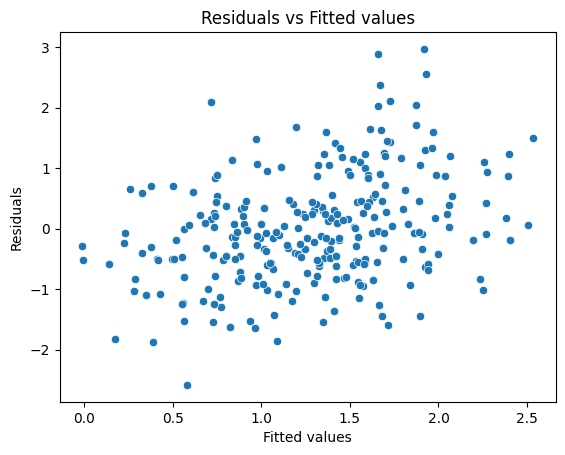

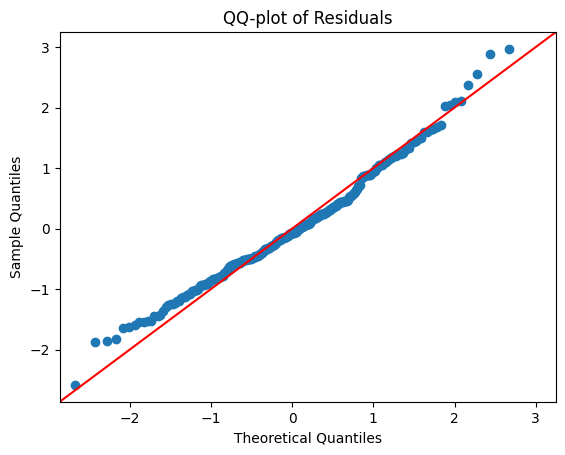

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


Breusch-Pagan test p-value: 0.4968488572302736
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.016272342963268432
Residuals are not normally distributed.
        feature         VIF
0     Intercept  164.491144
1  session[T.2]    1.430462
2  session[T.3]    1.370921
3  session[T.4]    1.404149
4      type_chx    1.144495
5           age    1.139220
6  IMC_baseline    1.077982
7          sexe    1.078545
                                  chi2                 P>chi2  df constraint
Intercept       [[3.5708804367721974]]   0.058801126936908234              1
session         [[14.133162889676855]]  0.0027293860678304837              3
type_chx      [[0.048548763746712534]]     0.8256080521352819              1
age             [[1.8306573836581157]]    0.17604991834035782              1
IMC_baseline    [[1.3815383345503562]]    0.23983928674034155              1
sexe           [[0.03560485452887955]]     0.8503338405698804              1
AIC

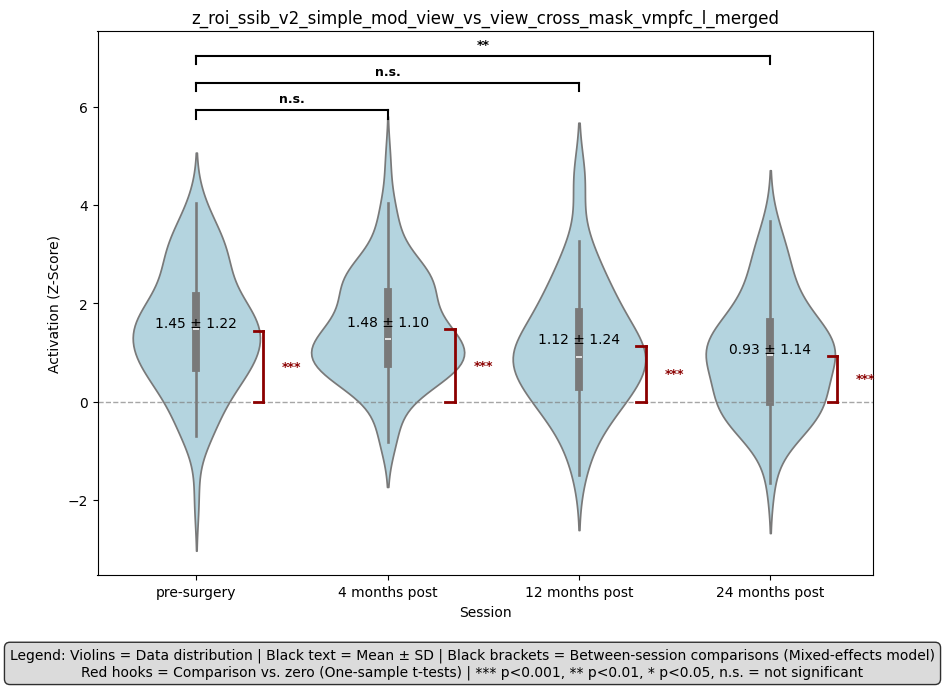

{'between_sessions': {'roi_names': ['z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged', 'z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged', 'z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged'], 'comparisons': ['4_months_vs_pre', '12_months_vs_pre', '24_months_vs_pre'], 'p_values': [np.float64(0.9576558103522824), np.float64(0.06263651636633456), np.float64(0.0014918254173101229)], 'beta_values': [np.float64(0.00864882450882793), np.float64(-0.34135329623538907), np.float64(-0.5899474889510979)]}, 'against_zero': {'roi_names': ['z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged', 'z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged', 'z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged', 'z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged'], 'sessions': ['1', '2', '3', '4'], 'p_values': [np.float64(3.3852801071031217e-16), np.float64(1.1611040823388633e-19), np.float64(1.7739269114435264e-08),

{'between_sessions': {'roi_names': ['z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged',
   'z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged',
   'z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged'],
  'comparisons': ['4_months_vs_pre', '12_months_vs_pre', '24_months_vs_pre'],
  'p_values_raw': [np.float64(0.9576558103522824),
   np.float64(0.06263651636633456),
   np.float64(0.0014918254173101229)],
  'p_values_corrected': [0.9576558103522824,
   0.09395477454950185,
   0.004475476251930369],
  'beta_values': [np.float64(0.00864882450882793),
   np.float64(-0.34135329623538907),
   np.float64(-0.5899474889510979)],
  'significant_fdr': [False, False, True],
  'alpha_corrected': 0.016666666666666666},
 'against_zero': {'roi_names': ['z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged',
   'z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged',
   'z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged',
   'z_

In [49]:
resultat_test = {}
roi_analysis_GB(participants, 'z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged',results_storage=resultat_test)
print(resultat_test)
perform_fdr_correction(resultat_test, alpha=0.05, method='fdr_bh')

In [50]:
# Now let's apply FDR correction to these results
print("="*80)
print("APPLYING FDR CORRECTION")
print("="*80)

corrected_results = perform_fdr_correction(resultat_test, alpha=0.05, method='fdr_bh')

APPLYING FDR CORRECTION
=== FDR CORRECTION RESULTS: BETWEEN-SESSIONS COMPARISONS ===
Method: fdr_bh, Alpha: 0.05
Number of tests: 3
Number of significant results (FDR-corrected): 1

                                                            ROI       Comparison    Beta  P_raw  P_FDR Significant_FDR
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged  4_months_vs_pre  0.0086 0.9577 0.9577              No
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged 12_months_vs_pre -0.3414 0.0626 0.0940              No
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged 24_months_vs_pre -0.5899 0.0015 0.0045             Yes

=== FDR CORRECTION RESULTS: AGAINST-ZERO COMPARISONS ===
Method: fdr_bh, Alpha: 0.05
Number of tests: 4
Number of significant results (FDR-corrected): 4

                                                            ROI Session  T_stat  P_raw  P_FDR Significant_FDR
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged       1 10.36

### DLPFC_merged_right, mod_view simple v.s. view cross

                                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlpfc_r_merged
No. Observations: 263     Method:             REML                                                           
No. Groups:       90      Scale:              1.1591                                                         
Min. group size:  1       Log-Likelihood:     -459.9452                                                      
Max. group size:  4       Converged:          Yes                                                            
Mean group size:  2.9                                                                                        
-----------------------------------------------------------------------------------------------------------------------
                           Coef.            Std.Err.             z              P>|z|           [0.025           0.975]
--------------------------

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

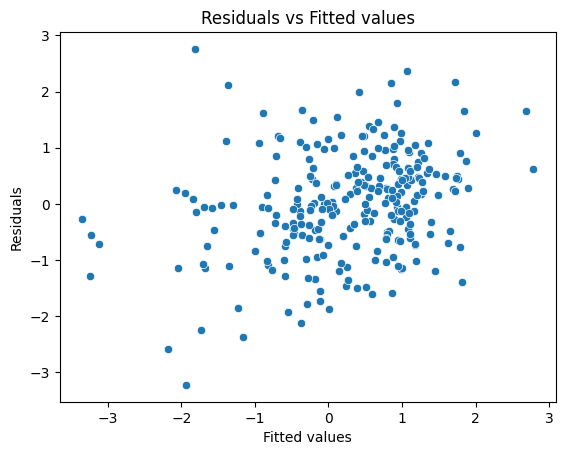

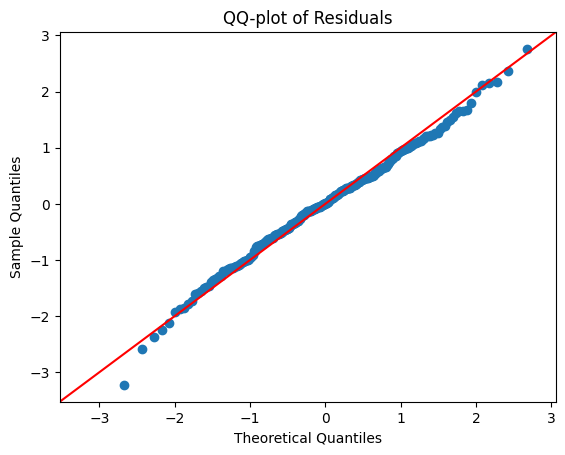

Breusch-Pagan test p-value: 0.19019862740844595
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.687832599936185
Residuals are normally distributed.
        feature         VIF
0     Intercept  162.882868
1  session[T.2]    1.431652
2  session[T.3]    1.376375
3  session[T.4]    1.403552
4      type_chx    1.152913
5           age    1.149130
6  IMC_baseline    1.080640
7          sexe    1.078537
                                    chi2                P>chi2  df constraint
Intercept          [[8.037030692288173]]  0.004583060164775069              1
session            [[1.194527201277935]]     0.754317211989505              3
type_chx      [[1.2154463415840386e-05]]    0.9972183205821584              1
age             [[0.030701976752508745]]    0.8609069303521594              1
IMC_baseline       [[8.945668755990702]]  0.002781282530249245              1
sexe             [[0.02514085452841972]]     0.874016586623572              1
AI

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


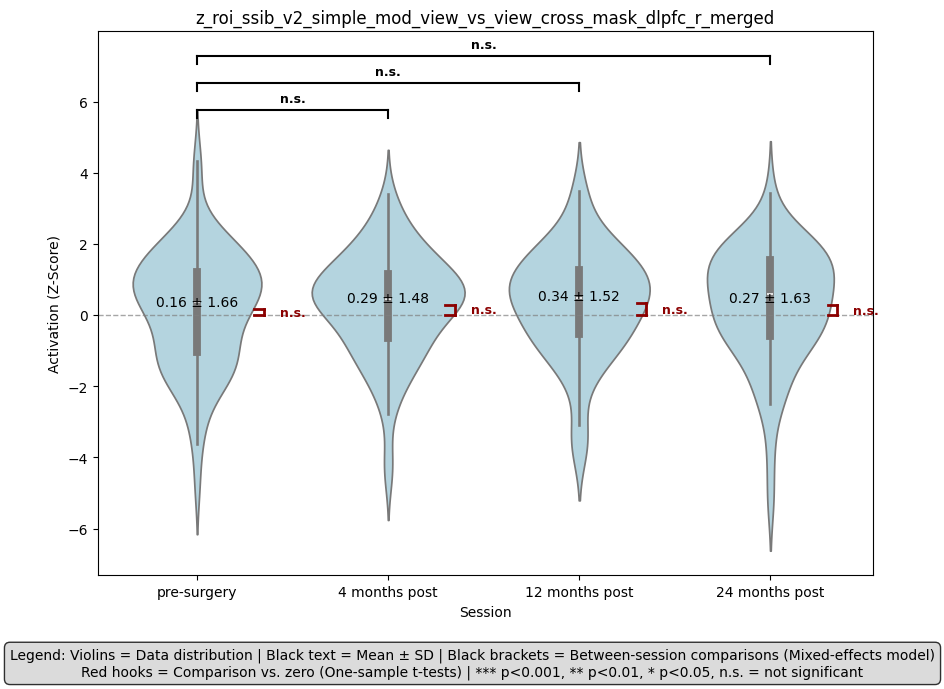

(                                  Pré-Chirurgie         4 mois       12 mois  \
 N                                          76.0           79.0          54.0   
 Age (mean ± std)                   43.77 ± 9.44   44.35 ± 9.26  45.98 ± 9.16   
 Sexe (M:F)                              59 : 17        61 : 18       41 : 13   
 Gastrectomie (n)                           43.0           45.0          26.0   
 RYGB (n)                                   14.0           16.0          13.0   
 DBP-SD (n)                                 19.0           18.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.06   35.96 ± 5.09  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.62 ± 10.04  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          54.0      NaN  
 Age (mean ± std)                   47.03 ± 9.01     None  
 Sexe (M:F)                              43 : 11     None  
 Gastrectomie (n)            

In [51]:
roi_analysis_GB(participants, 'z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlPFC_R_merged')

### Ventral Striatum Left, mod-view simple v.s. cross

                               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vs_l
No. Observations: 266     Method:             REML                                                 
No. Groups:       90      Scale:              0.8693                                               
Min. group size:  1       Log-Likelihood:     -407.2492                                            
Max. group size:  4       Converged:          Yes                                                  
Mean group size:  3.0                                                                              
-----------------------------------------------------------------------------------------------------------
                         Coef.          Std.Err.           z            P>|z|         [0.025         0.975]
-----------------------------------------------------------------------------------------------------------
Interce

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

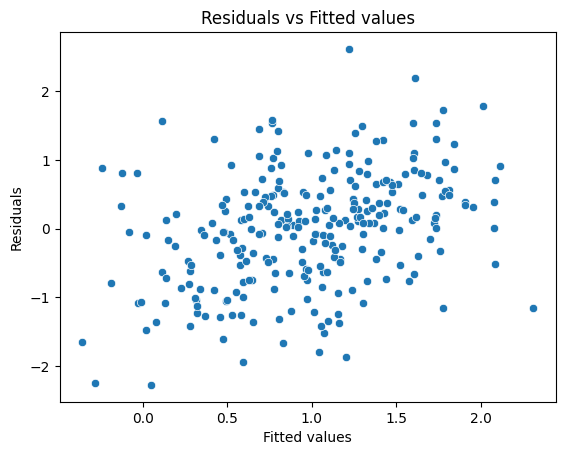

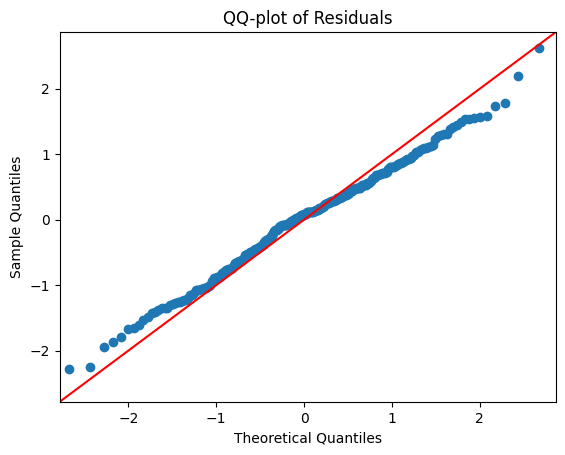

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


Breusch-Pagan test p-value: 0.3695309992161668
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.4852283830510534
Residuals are normally distributed.
        feature         VIF
0     Intercept  164.491144
1  session[T.2]    1.430462
2  session[T.3]    1.370921
3  session[T.4]    1.404149
4      type_chx    1.144495
5           age    1.139220
6  IMC_baseline    1.077982
7          sexe    1.078545
                                  chi2               P>chi2  df constraint
Intercept       [[3.1577471259886143]]   0.0755674007003406              1
session           [[8.22521645344776]]  0.04157940385258871              3
type_chx        [[0.4078487038931366]]   0.5230634427650551              1
age            [[0.22859515242881262]]   0.6325674638835936              1
IMC_baseline    [[0.2595734070280171]]   0.6104133814081014              1
sexe          [[0.018830727314089673]]   0.8908528738268018              1
AIC: 832.4983868855495


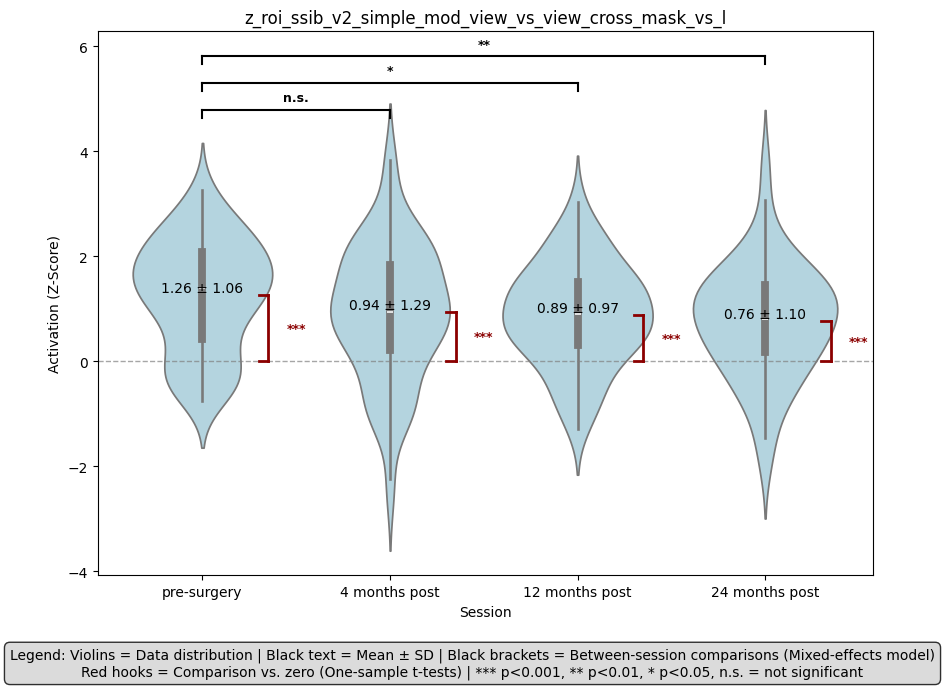

(                                  Pré-Chirurgie        4 mois       12 mois  \
 N                                          77.0          80.0          54.0   
 Age (mean ± std)                   43.82 ± 9.39  44.40 ± 9.21  45.98 ± 9.16   
 Sexe (M:F)                              60 : 17       62 : 18       41 : 13   
 Gastrectomie (n)                           43.0          45.0          26.0   
 RYGB (n)                                   14.0          16.0          13.0   
 DBP-SD (n)                                 20.0          19.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.03  35.94 ± 5.05  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.66 ± 9.99  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          55.0      NaN  
 Age (mean ± std)                   47.09 ± 8.93     None  
 Sexe (M:F)                              44 : 11     None  
 Gastrectomie (n)                     

In [52]:
roi_analysis_GB(participants, 'Z_ROI_ssib_v2_simple_mod_view_vs_view_cross_mask_VS_L', results_storage=resultat_test)

### results for VS right mod-view simple v.s. cross

                               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vs_r
No. Observations: 266     Method:             REML                                                 
No. Groups:       90      Scale:              0.9734                                               
Min. group size:  1       Log-Likelihood:     -416.6539                                            
Max. group size:  4       Converged:          Yes                                                  
Mean group size:  3.0                                                                              
-----------------------------------------------------------------------------------------------------------
                         Coef.          Std.Err.           z            P>|z|         [0.025         0.975]
-----------------------------------------------------------------------------------------------------------
Interce

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

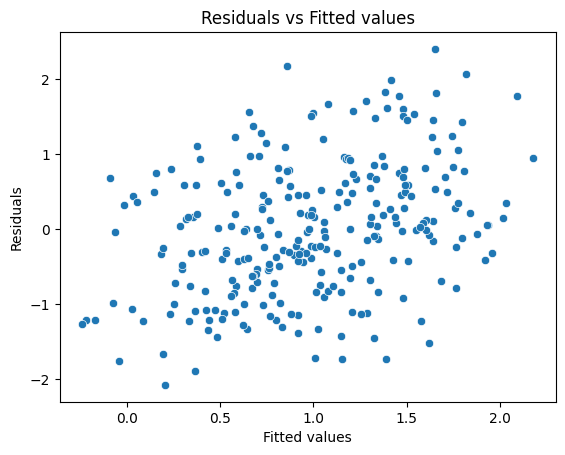

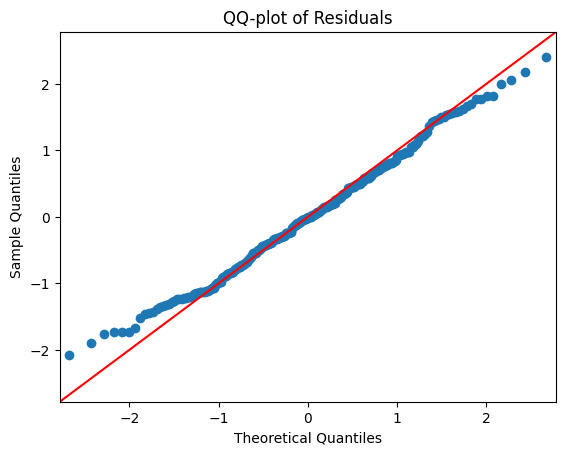

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


Breusch-Pagan test p-value: 0.6893677867488652
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.17240901435120504
Residuals are normally distributed.
        feature         VIF
0     Intercept  164.491144
1  session[T.2]    1.430462
2  session[T.3]    1.370921
3  session[T.4]    1.404149
4      type_chx    1.144495
5           age    1.139220
6  IMC_baseline    1.077982
7          sexe    1.078545
                                  chi2                P>chi2  df constraint
Intercept        [[7.950334386599866]]  0.004807849243039508              1
session         [[6.9872538891384695]]   0.07230514592955577              3
type_chx       [[0.19841803748401057]]     0.656000802042422              1
age            [[0.22676856140164955]]    0.6339303127820954              1
IMC_baseline    [[3.3120695855230164]]   0.06877282991693567              1
sexe          [[0.005692034284881735]]    0.9398602015523051              1
AIC: 851.307797

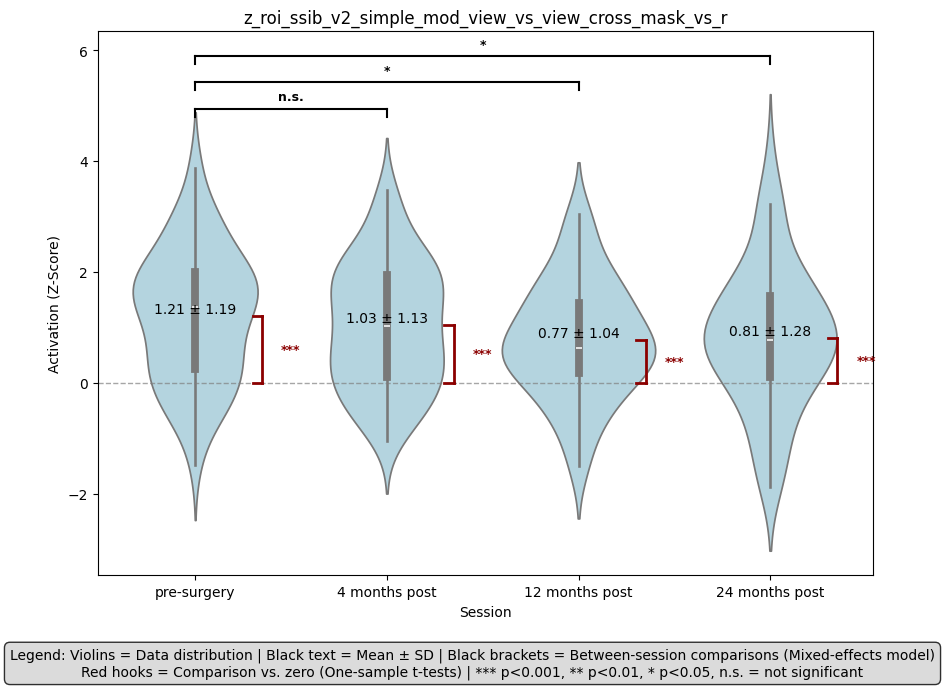

(                                  Pré-Chirurgie        4 mois       12 mois  \
 N                                          77.0          80.0          54.0   
 Age (mean ± std)                   43.82 ± 9.39  44.40 ± 9.21  45.98 ± 9.16   
 Sexe (M:F)                              60 : 17       62 : 18       41 : 13   
 Gastrectomie (n)                           43.0          45.0          26.0   
 RYGB (n)                                   14.0          16.0          13.0   
 DBP-SD (n)                                 20.0          19.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.03  35.94 ± 5.05  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.66 ± 9.99  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          55.0      NaN  
 Age (mean ± std)                   47.09 ± 8.93     None  
 Sexe (M:F)                              44 : 11     None  
 Gastrectomie (n)                     

In [53]:
roi_analysis_GB(participants,'Z_ROI_ssib_v2_simple_mod_view_vs_view_cross_mask_VS_R')

## results for the more complex design matrix : 

Bold signal = ViewSnacksHiSweet + ModByBidViewSnacksHiSweet + ViewSnacksHiSalt + ModByBidViewSnacksHiSalt + ViewSnacksLoLo + ModByBidViewSnacksLoLo + ViewCross + 6MotionRegressors + CSF + WM + Drift

### view High and Lo v.s. cross, vmPFC_L

                                          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_view_hi_sweet_hi_salt_lo_lo_vs_view_cross_mask_vmpfc_l_merged
No. Observations: 192     Method:             REML                                                                       
No. Groups:       66      Scale:              1.1859                                                                     
Min. group size:  1       Log-Likelihood:     -318.4675                                                                  
Max. group size:  4       Converged:          Yes                                                                        
Mean group size:  2.9                                                                                                    
--------------------------------------------------------------------------------------------------------------------------------------
                           Coef.               Std.Er

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

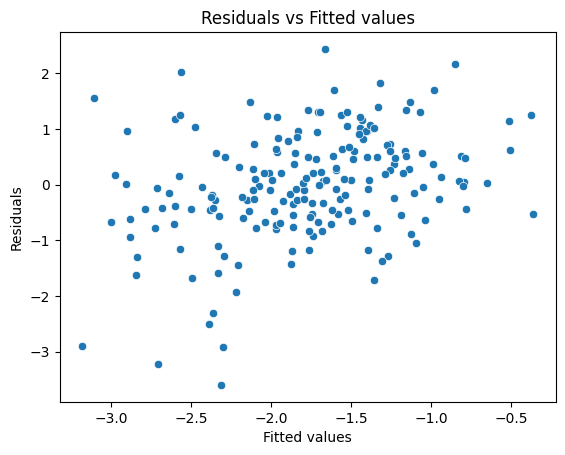

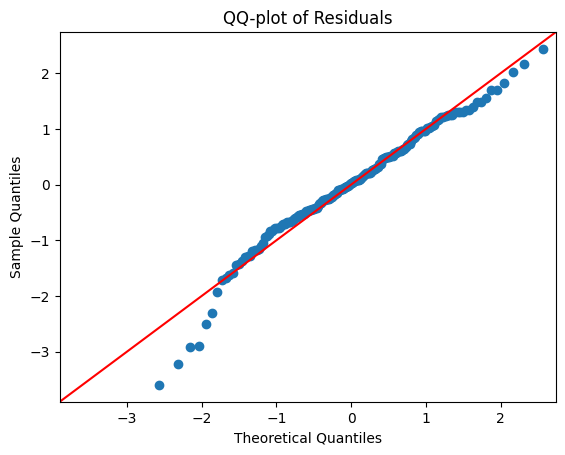

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


Breusch-Pagan test p-value: 0.6048596653377198
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.0009914551113687888
Residuals are not normally distributed.
        feature         VIF
0     Intercept  169.801560
1  session[T.2]    1.409718
2  session[T.3]    1.354723
3  session[T.4]    1.387398
4      type_chx    1.108156
5           age    1.080349
6  IMC_baseline    1.081814
7          sexe    1.046478
                                 chi2                P>chi2  df constraint
Intercept       [[3.882718447814468]]  0.048785505385101416              1
session        [[10.875373297642168]]  0.012419225158862063              3
type_chx      [[0.01580554287634653]]     0.899953492710931              1
age             [[2.541739807881464]]   0.11087255655877483              1
IMC_baseline   [[1.2915280764178905]]   0.25576653652333625              1
sexe          [[0.14931537835131994]]    0.6991904675606284              1
AIC: 654.9349720

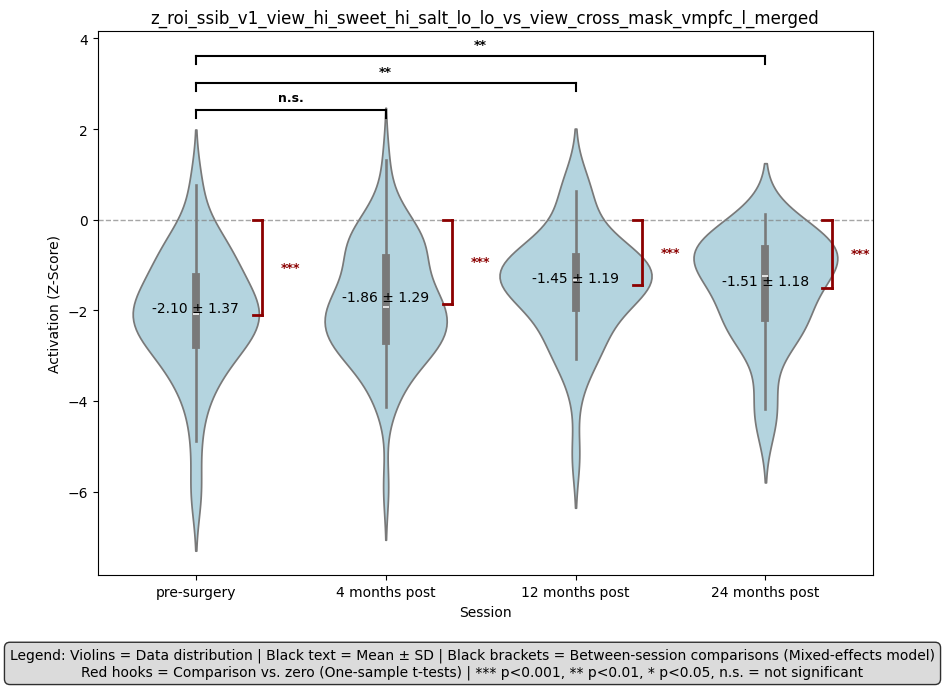

(                                  Pré-Chirurgie         4 mois       12 mois  \
 N                                          57.0           56.0          39.0   
 Age (mean ± std)                   43.54 ± 9.42   44.61 ± 9.04  45.10 ± 9.24   
 Sexe (M:F)                              47 : 10        46 : 10        32 : 7   
 Gastrectomie (n)                           32.0           31.0          18.0   
 RYGB (n)                                    8.0           10.0           8.0   
 DBP-SD (n)                                 17.0           15.0          13.0   
 IMC (kg/m2) (moy. ± et.)           44.06 ± 3.86   35.92 ± 5.09  28.48 ± 4.49   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.59 ± 10.14  36.02 ± 8.14   
 
                                         24 mois Valeur P  
 N                                          40.0      NaN  
 Age (mean ± std)                   46.71 ± 8.83     None  
 Sexe (M:F)                               34 : 6     None  
 Gastrectomie (n)            

In [54]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_view_Hi_Sweet_Hi_Salt_Lo_Lo_vs_view_cross_mask_vmPFC_L_merged')

### view high and lo vs view cross dlPFC

                                          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_view_hi_sweet_hi_salt_lo_lo_vs_view_cross_mask_dlpfc_r_merged
No. Observations: 189     Method:             REML                                                                       
No. Groups:       66      Scale:              0.9443                                                                     
Min. group size:  1       Log-Likelihood:     -317.4920                                                                  
Max. group size:  4       Converged:          Yes                                                                        
Mean group size:  2.9                                                                                                    
--------------------------------------------------------------------------------------------------------------------------------------
                           Coef.               Std.Er

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

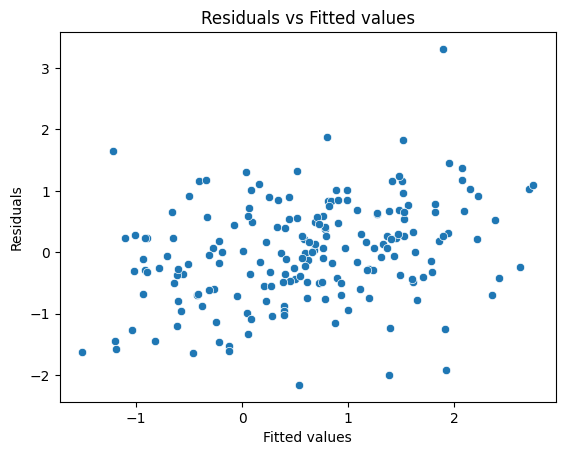

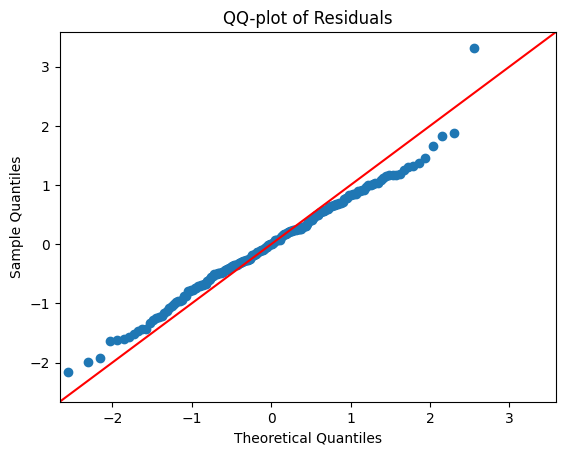

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


Breusch-Pagan test p-value: 0.32370967228473785
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.19614920323460555
Residuals are normally distributed.
        feature         VIF
0     Intercept  167.492019
1  session[T.2]    1.410890
2  session[T.3]    1.361554
3  session[T.4]    1.386164
4      type_chx    1.120211
5           age    1.088961
6  IMC_baseline    1.085032
7          sexe    1.049602
                                  chi2              P>chi2  df constraint
Intercept      [[0.45298392969541734]]  0.5009213293623016              1
session          [[3.297657545291049]]  0.3479688039047073              3
type_chx       [[0.27406689101030224]]  0.6006166224967674              1
age            [[0.34449057120346216]]  0.5572485769707467              1
IMC_baseline  [[0.048494622835005816]]  0.8257037564068583              1
sexe            [[0.1090972957868931]]  0.7411742012778021              1
AIC: 652.9839186637511
BIC: 

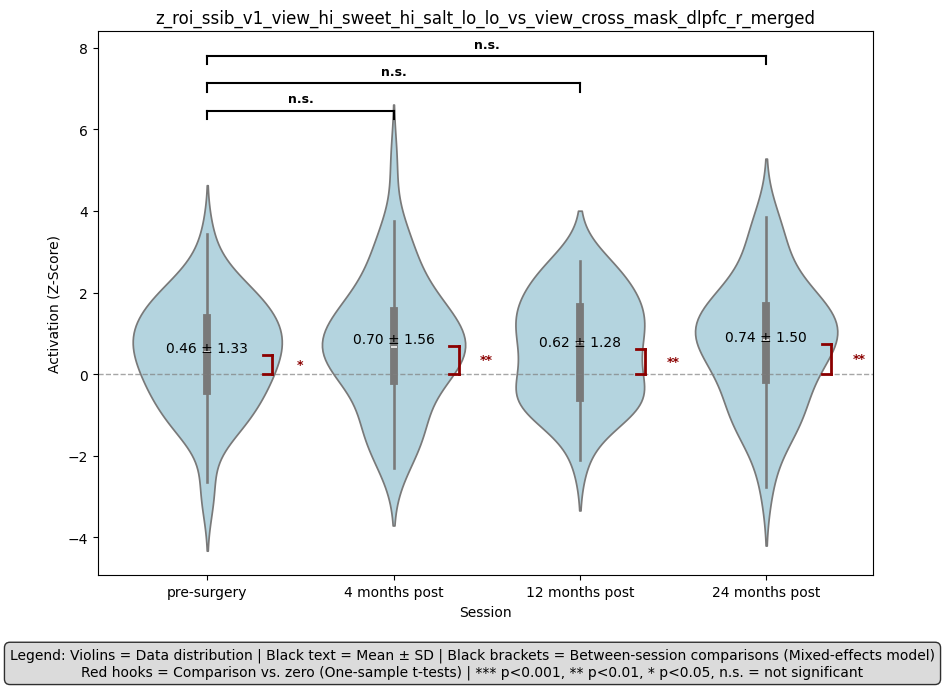

(                                  Pré-Chirurgie         4 mois       12 mois  \
 N                                          56.0           55.0          39.0   
 Age (mean ± std)                   43.46 ± 9.49   44.54 ± 9.11  45.10 ± 9.24   
 Sexe (M:F)                              46 : 10        45 : 10        32 : 7   
 Gastrectomie (n)                           32.0           31.0          18.0   
 RYGB (n)                                    8.0           10.0           8.0   
 DBP-SD (n)                                 16.0           14.0          13.0   
 IMC (kg/m2) (moy. ± et.)           44.06 ± 3.89   35.94 ± 5.13  28.48 ± 4.49   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.53 ± 10.22  36.02 ± 8.14   
 
                                         24 mois Valeur P  
 N                                          39.0      NaN  
 Age (mean ± std)                   46.62 ± 8.93     None  
 Sexe (M:F)                               33 : 6     None  
 Gastrectomie (n)            

In [55]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_view_Hi_Sweet_Hi_Salt_Lo_Lo_vs_view_cross_mask_dlPFC_R_merged')

### view high and lo vs cross VS L

                                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_view_hi_sweet_hi_salt_lo_lo_vs_view_cross_mask_vs_l
No. Observations: 192     Method:             REML                                                             
No. Groups:       66      Scale:              0.9029                                                           
Min. group size:  1       Log-Likelihood:     -289.2030                                                        
Max. group size:  4       Converged:          Yes                                                              
Mean group size:  2.9                                                                                          
--------------------------------------------------------------------------------------------------------------------------
                         Coef.             Std.Err.              z               P>|z|            [0.025            0.975]
-------

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

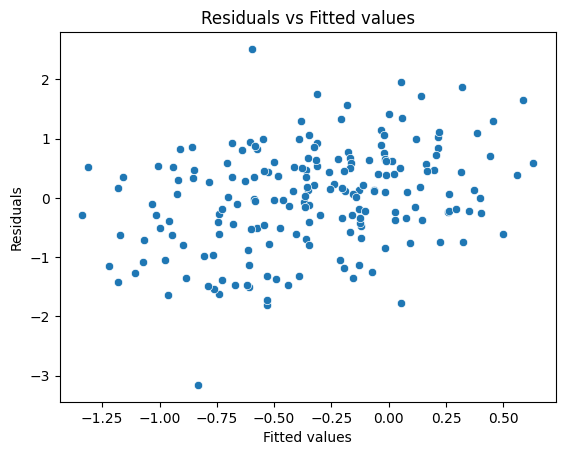

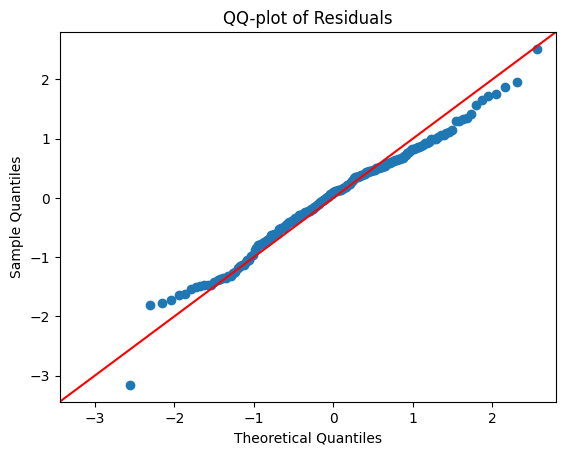

Breusch-Pagan test p-value: 0.7169671774884642
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.13114523516550086
Residuals are normally distributed.
        feature         VIF
0     Intercept  169.801560
1  session[T.2]    1.409718
2  session[T.3]    1.354723
3  session[T.4]    1.387398
4      type_chx    1.108156
5           age    1.080349
6  IMC_baseline    1.081814
7          sexe    1.046478
                                 chi2                P>chi2  df constraint
Intercept      [[1.9906993893531162]]   0.15826777126148375              1
session        [[10.815772918805417]]  0.012764935230336194              3
type_chx      [[0.15410995198505392]]    0.6946382796184334              1
age            [[0.1503564571134325]]    0.6981949476369288              1
IMC_baseline    [[2.843614662326893]]   0.09173763306896324              1
sexe           [[2.0091992815505835]]   0.15634781849648813              1
AIC: 596.4059484476181

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


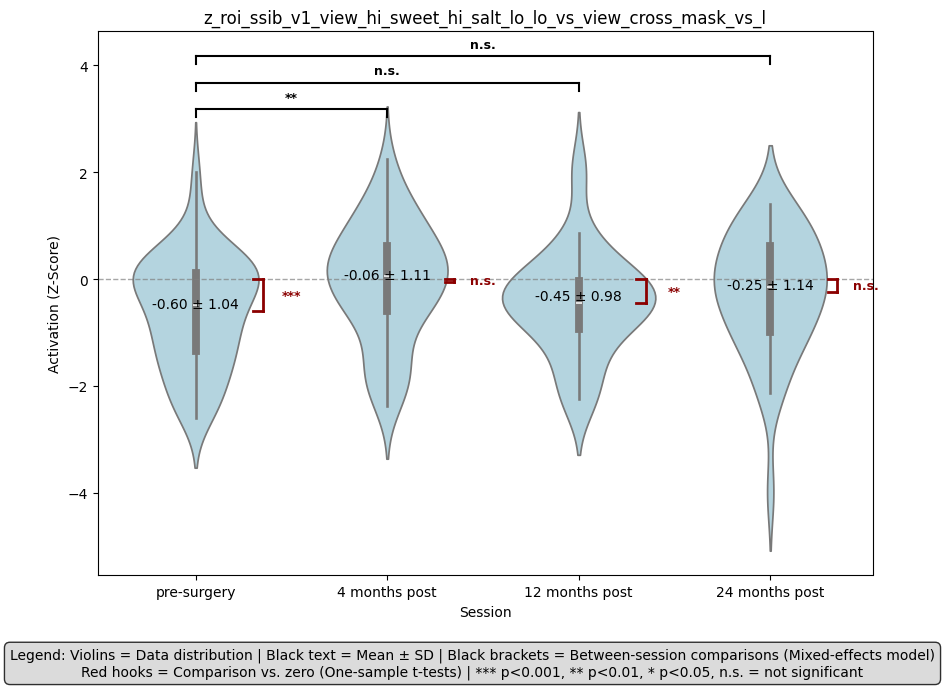

(                                  Pré-Chirurgie         4 mois       12 mois  \
 N                                          57.0           56.0          39.0   
 Age (mean ± std)                   43.54 ± 9.42   44.61 ± 9.04  45.10 ± 9.24   
 Sexe (M:F)                              47 : 10        46 : 10        32 : 7   
 Gastrectomie (n)                           32.0           31.0          18.0   
 RYGB (n)                                    8.0           10.0           8.0   
 DBP-SD (n)                                 17.0           15.0          13.0   
 IMC (kg/m2) (moy. ± et.)           44.06 ± 3.86   35.92 ± 5.09  28.48 ± 4.49   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.59 ± 10.14  36.02 ± 8.14   
 
                                         24 mois Valeur P  
 N                                          40.0      NaN  
 Age (mean ± std)                   46.71 ± 8.83     None  
 Sexe (M:F)                               34 : 6     None  
 Gastrectomie (n)            

In [56]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_view_Hi_Sweet_Hi_Salt_Lo_Lo_vs_view_cross_mask_VS_L')

### view high and lo vs view cross vs_R

                                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_view_hi_sweet_hi_salt_lo_lo_vs_view_cross_mask_vs_r
No. Observations: 192     Method:             REML                                                             
No. Groups:       66      Scale:              1.0508                                                           
Min. group size:  1       Log-Likelihood:     -300.2028                                                        
Max. group size:  4       Converged:          Yes                                                              
Mean group size:  2.9                                                                                          
--------------------------------------------------------------------------------------------------------------------------
                         Coef.             Std.Err.              z               P>|z|            [0.025            0.975]
-------

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

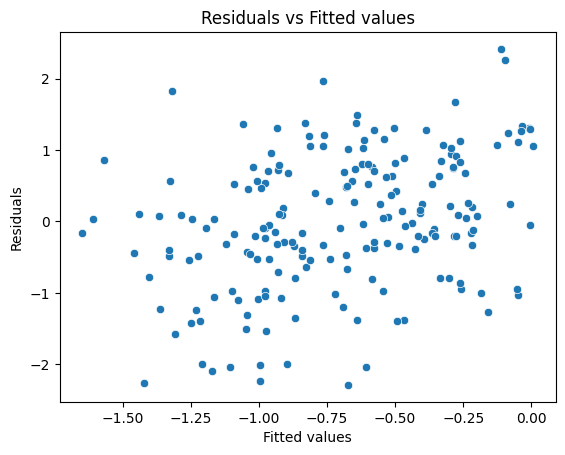

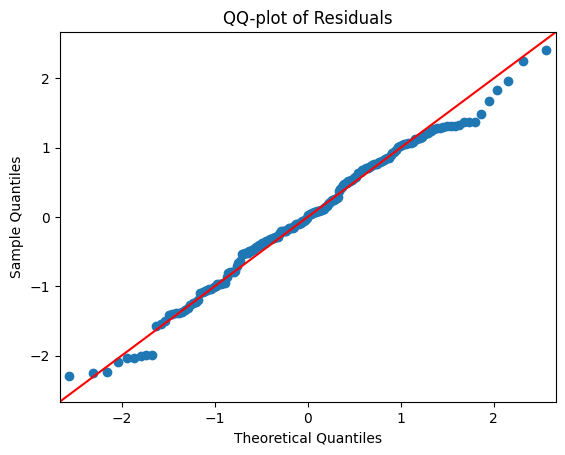

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


Breusch-Pagan test p-value: 0.8728668437323611
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.1075747684417786
Residuals are normally distributed.
        feature         VIF
0     Intercept  169.801560
1  session[T.2]    1.409718
2  session[T.3]    1.354723
3  session[T.4]    1.387398
4      type_chx    1.108156
5           age    1.080349
6  IMC_baseline    1.081814
7          sexe    1.046478
                                  chi2               P>chi2  df constraint
Intercept       [[3.7303683016576823]]  0.05343161090359322              1
session          [[4.871681047943778]]   0.1814380652988758              3
type_chx      [[0.011422523464739253]]   0.9148871897076319              1
age            [[0.11762851755581143]]   0.7316209233590706              1
IMC_baseline     [[2.784749955426685]]  0.09516554588551711              1
sexe            [[1.7639940160131014]]  0.18412711683938465              1
AIC: 618.4056815101133


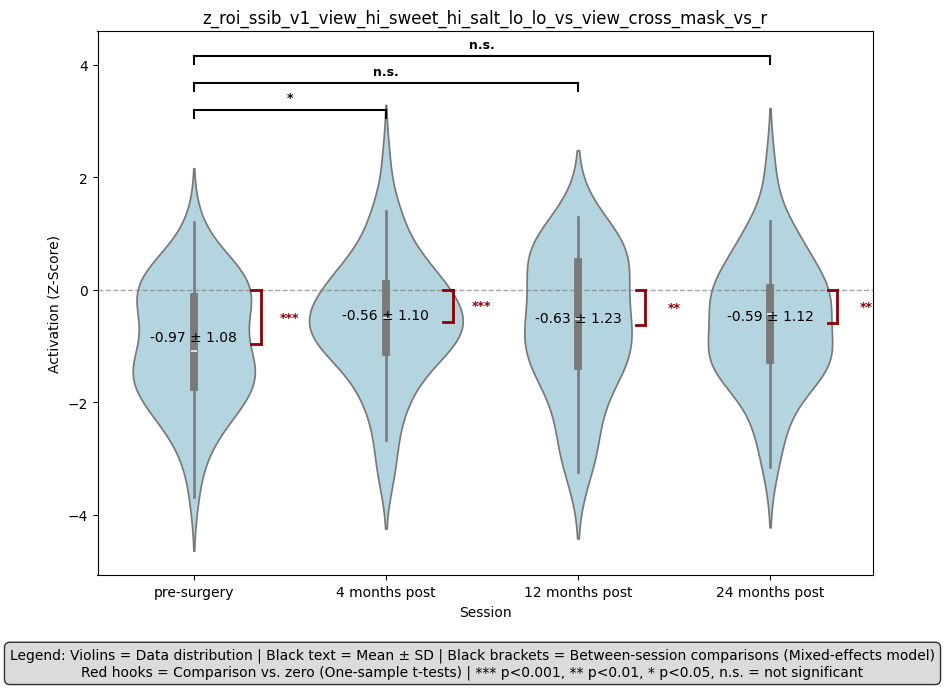

(                                  Pré-Chirurgie         4 mois       12 mois  \
 N                                          57.0           56.0          39.0   
 Age (mean ± std)                   43.54 ± 9.42   44.61 ± 9.04  45.10 ± 9.24   
 Sexe (M:F)                              47 : 10        46 : 10        32 : 7   
 Gastrectomie (n)                           32.0           31.0          18.0   
 RYGB (n)                                    8.0           10.0           8.0   
 DBP-SD (n)                                 17.0           15.0          13.0   
 IMC (kg/m2) (moy. ± et.)           44.06 ± 3.86   35.92 ± 5.09  28.48 ± 4.49   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.59 ± 10.14  36.02 ± 8.14   
 
                                         24 mois Valeur P  
 N                                          40.0      NaN  
 Age (mean ± std)                   46.71 ± 8.83     None  
 Sexe (M:F)                               34 : 6     None  
 Gastrectomie (n)            

In [57]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_view_Hi_Sweet_Hi_Salt_Lo_Lo_vs_view_cross_mask_VS_R')

### View High Sweet + High Salt minus View Low, modulated by bid, for vmPFC_L

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

                                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_mod_view_hi_sweet_hi_salt_vs_lo_lo_mask_vmpfc_l_merged
No. Observations: 266     Method:             REML                                                                
No. Groups:       90      Scale:              0.7041                                                              
Min. group size:  1       Log-Likelihood:     -343.3742                                                           
Max. group size:  4       Converged:          Yes                                                                 
Mean group size:  3.0                                                                                             
-----------------------------------------------------------------------------------------------------------------------------
                            Coef.             Std.Err.              z               P>|z|            [0.025 

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


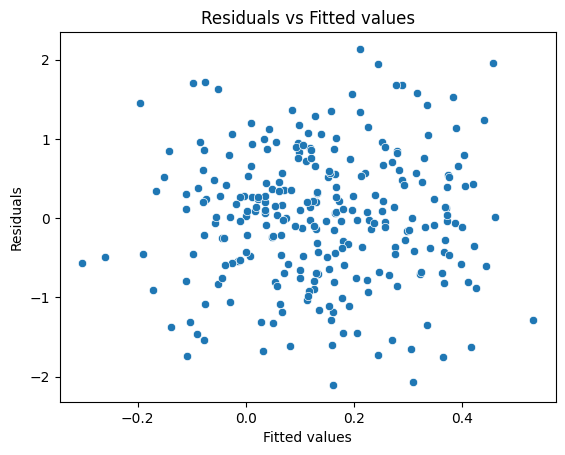

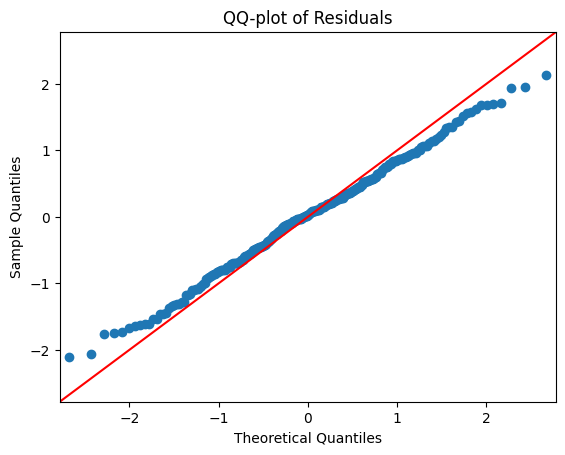

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


Breusch-Pagan test p-value: 0.034342207431615514
Heteroscedasticity detected. The variance of residuals is not constant.
Shapiro-Wilk test p-value: 0.6570223574912172
Residuals are normally distributed.
        feature         VIF
0     Intercept  164.491144
1  session[T.2]    1.430462
2  session[T.3]    1.370921
3  session[T.4]    1.404149
4      type_chx    1.144495
5           age    1.139220
6  IMC_baseline    1.077982
7          sexe    1.078545
                                 chi2               P>chi2  df constraint
Intercept      [[0.6700912942150576]]  0.41301977953114766              1
session         [[3.007948282269668]]   0.3904013301664126              3
type_chx      [[0.02804677416065903]]   0.8669989041026172              1
age           [[0.25861667769959074]]   0.6110721123282509              1
IMC_baseline    [[4.315590154734077]]  0.03776466963852018              1
sexe             [[2.03073320846405]]  0.15414622636303957              1
AIC: 704.7483059864451
BIC:

/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


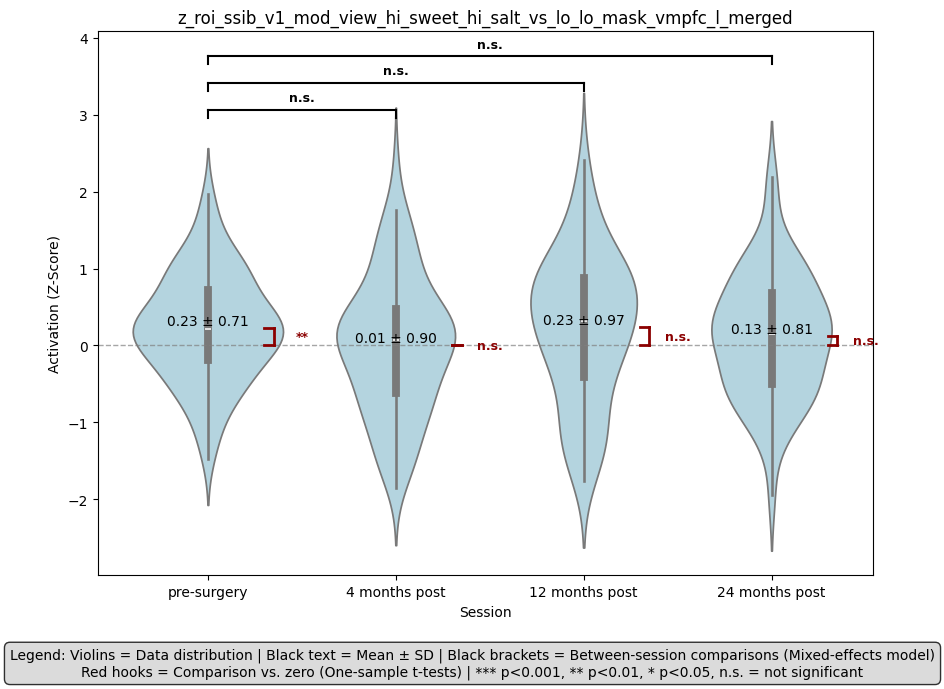

(                                  Pré-Chirurgie        4 mois       12 mois  \
 N                                          77.0          80.0          54.0   
 Age (mean ± std)                   43.82 ± 9.39  44.40 ± 9.21  45.98 ± 9.16   
 Sexe (M:F)                              60 : 17       62 : 18       41 : 13   
 Gastrectomie (n)                           43.0          45.0          26.0   
 RYGB (n)                                   14.0          16.0          13.0   
 DBP-SD (n)                                 20.0          19.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.03  35.94 ± 5.05  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.66 ± 9.99  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          55.0      NaN  
 Age (mean ± std)                   47.09 ± 8.93     None  
 Sexe (M:F)                              44 : 11     None  
 Gastrectomie (n)                     

In [58]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_mod_view_Hi_Sweet_Hi_Salt_vs_Lo_Lo_mask_vmPFC_L_merged')

### mod view Hi vs Lo, dlPFC_R_merged

                                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_mod_view_hi_sweet_hi_salt_vs_lo_lo_mask_dlpfc_r_merged
No. Observations: 263     Method:             REML                                                                
No. Groups:       90      Scale:              0.8904                                                              
Min. group size:  1       Log-Likelihood:     -379.9074                                                           
Max. group size:  4       Converged:          Yes                                                                 
Mean group size:  2.9                                                                                             
-----------------------------------------------------------------------------------------------------------------------------
                            Coef.             Std.Err.              z               P>|z|            [0.025 

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

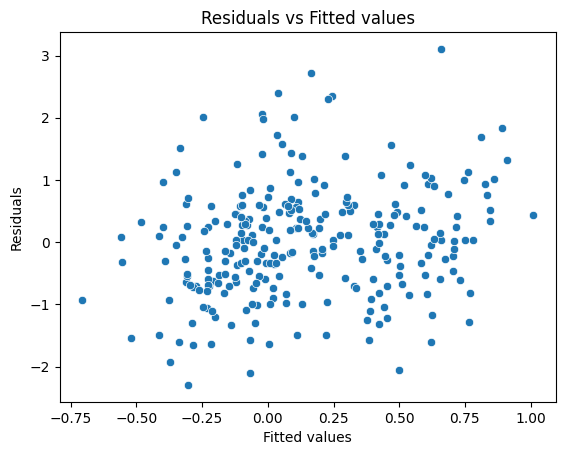

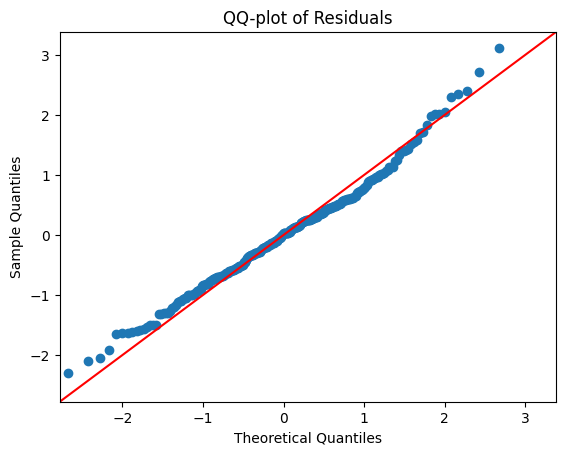

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


Breusch-Pagan test p-value: 0.4064647276840446
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.04550037204371393
Residuals are not normally distributed.
        feature         VIF
0     Intercept  162.882868
1  session[T.2]    1.431652
2  session[T.3]    1.376375
3  session[T.4]    1.403552
4      type_chx    1.152913
5           age    1.149130
6  IMC_baseline    1.080640
7          sexe    1.078537
                                   chi2                 P>chi2  df constraint
Intercept         [[0.735050798692915]]    0.39125091101593523              1
session           [[24.07643768089188]]  2.407869717574238e-05              3
type_chx         [[0.8127033950074891]]    0.36732219632112173              1
age           [[0.0004330425351074261]]     0.9833974806150516              1
IMC_baseline     [[0.5529393028478552]]     0.4571191775547636              1
sexe             [[0.4537609305563361]]      0.500554338293973             

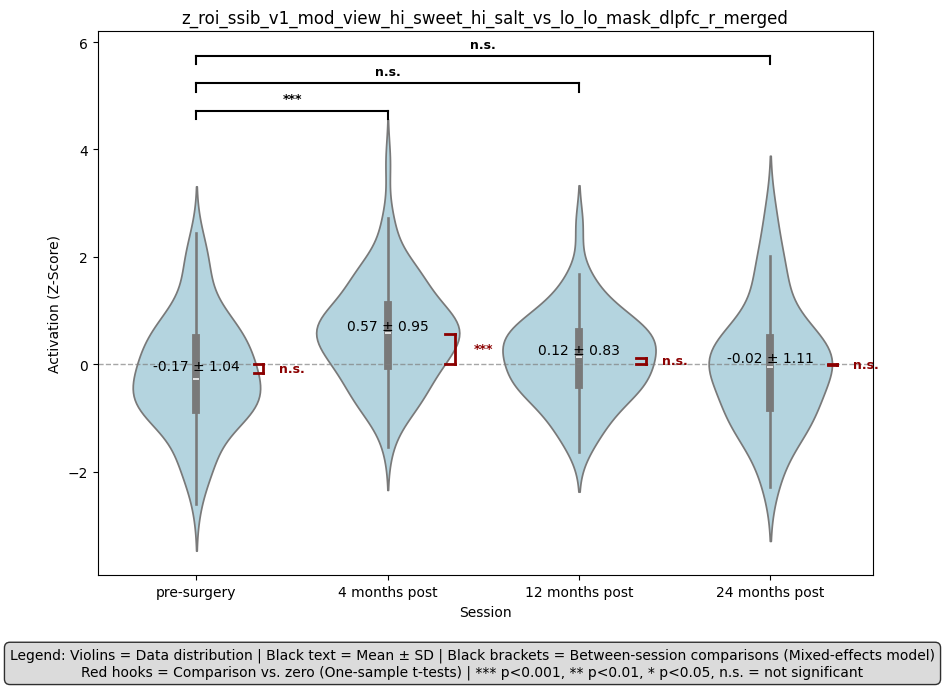

(                                  Pré-Chirurgie         4 mois       12 mois  \
 N                                          76.0           79.0          54.0   
 Age (mean ± std)                   43.77 ± 9.44   44.35 ± 9.26  45.98 ± 9.16   
 Sexe (M:F)                              59 : 17        61 : 18       41 : 13   
 Gastrectomie (n)                           43.0           45.0          26.0   
 RYGB (n)                                   14.0           16.0          13.0   
 DBP-SD (n)                                 19.0           18.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.06   35.96 ± 5.09  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.62 ± 10.04  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          54.0      NaN  
 Age (mean ± std)                   47.03 ± 9.01     None  
 Sexe (M:F)                              43 : 11     None  
 Gastrectomie (n)            

In [59]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_mod_view_Hi_Sweet_Hi_Salt_vs_Lo_Lo_mask_dlPFC_R_merged')

### mod view Hi vs Lo, VS_L

                                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_mod_view_hi_sweet_hi_salt_vs_lo_lo_mask_vs_l
No. Observations: 266     Method:             REML                                                      
No. Groups:       90      Scale:              0.7179                                                    
Min. group size:  1       Log-Likelihood:     -357.0072                                                 
Max. group size:  4       Converged:          Yes                                                       
Mean group size:  3.0                                                                                   
-----------------------------------------------------------------------------------------------------------------
                          Coef.           Std.Err.            z             P>|z|          [0.025          0.975]
-----------------------------------------------------------------------

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

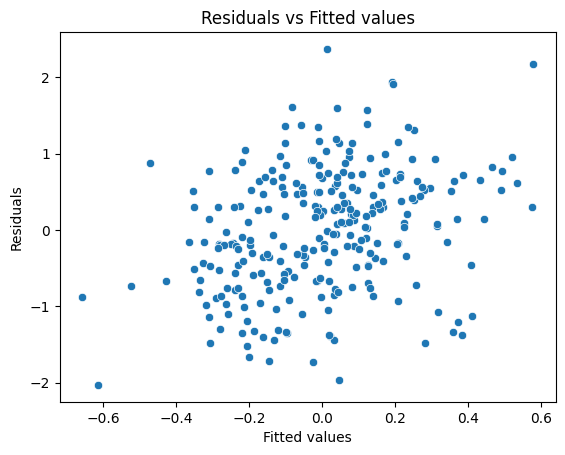

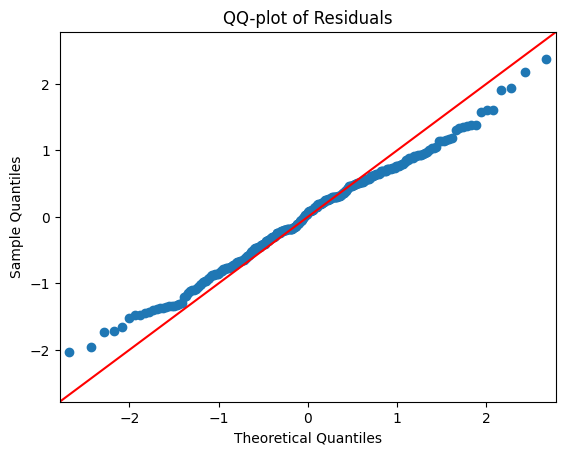

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


Breusch-Pagan test p-value: 0.5018757703743102
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.329485656355625
Residuals are normally distributed.
        feature         VIF
0     Intercept  164.491144
1  session[T.2]    1.430462
2  session[T.3]    1.370921
3  session[T.4]    1.404149
4      type_chx    1.144495
5           age    1.139220
6  IMC_baseline    1.077982
7          sexe    1.078545
                                  chi2               P>chi2  df constraint
Intercept      [[0.08161567810588144]]   0.7751197176165842              1
session          [[6.415501001762718]]  0.09305516974404442              3
type_chx        [[1.3595868270174487]]  0.24360910089923662              1
age             [[0.0674739212135263]]   0.7950508917463228              1
IMC_baseline     [[0.105214693622182]]   0.7456593335386051              1
sexe          [[0.017227560794495694]]   0.8955745354370165              1
AIC: 732.0143029001156
B

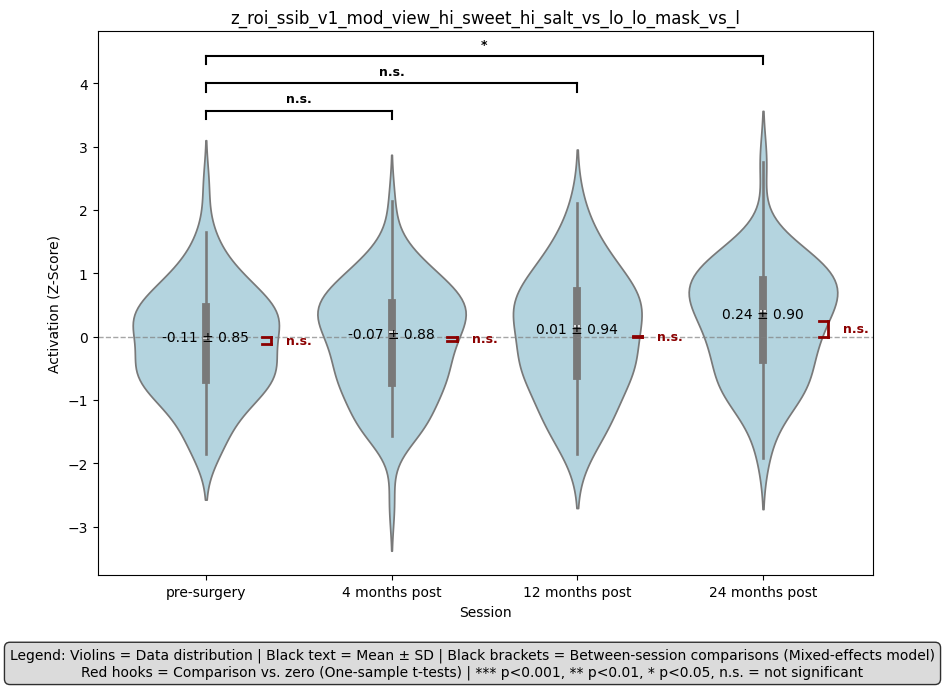

(                                  Pré-Chirurgie        4 mois       12 mois  \
 N                                          77.0          80.0          54.0   
 Age (mean ± std)                   43.82 ± 9.39  44.40 ± 9.21  45.98 ± 9.16   
 Sexe (M:F)                              60 : 17       62 : 18       41 : 13   
 Gastrectomie (n)                           43.0          45.0          26.0   
 RYGB (n)                                   14.0          16.0          13.0   
 DBP-SD (n)                                 20.0          19.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.03  35.94 ± 5.05  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.66 ± 9.99  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          55.0      NaN  
 Age (mean ± std)                   47.09 ± 8.93     None  
 Sexe (M:F)                              44 : 11     None  
 Gastrectomie (n)                     

In [60]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_mod_view_Hi_Sweet_Hi_Salt_vs_Lo_Lo_mask_VS_L')

### Mod view High vs low, VS_R

                                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_mod_view_hi_sweet_hi_salt_vs_lo_lo_mask_vs_r
No. Observations: 266     Method:             REML                                                      
No. Groups:       90      Scale:              0.7908                                                    
Min. group size:  1       Log-Likelihood:     -376.4516                                                 
Max. group size:  4       Converged:          Yes                                                       
Mean group size:  3.0                                                                                   
-----------------------------------------------------------------------------------------------------------------
                          Coef.           Std.Err.            z             P>|z|          [0.025          0.975]
-----------------------------------------------------------------------

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

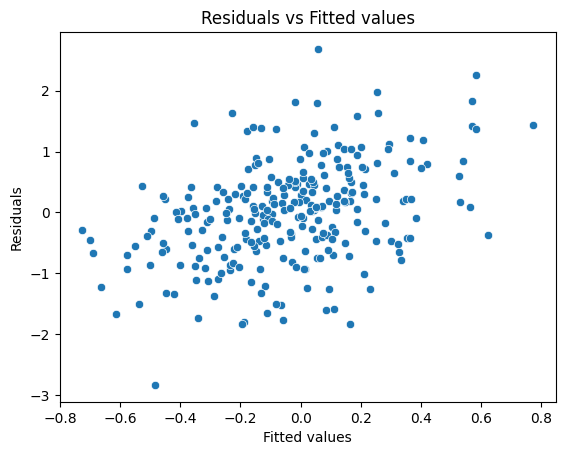

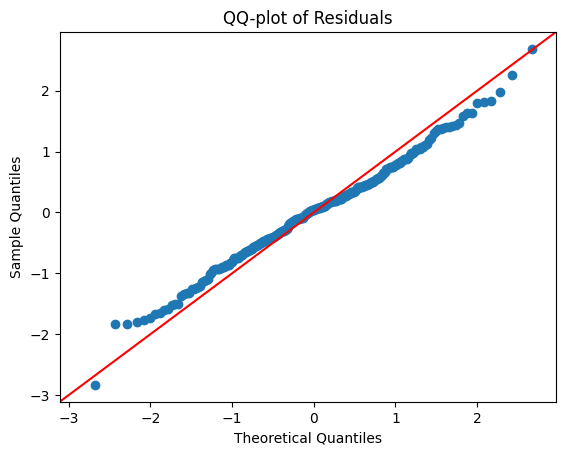

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


Breusch-Pagan test p-value: 0.2021358852749571
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.5918208123449809
Residuals are normally distributed.
        feature         VIF
0     Intercept  164.491144
1  session[T.2]    1.430462
2  session[T.3]    1.370921
3  session[T.4]    1.404149
4      type_chx    1.144495
5           age    1.139220
6  IMC_baseline    1.077982
7          sexe    1.078545
                                  chi2               P>chi2  df constraint
Intercept      [[0.24129635548179426]]   0.6232713824400553              1
session         [[3.2431829123940945]]  0.35562913230557847              3
type_chx        [[0.3098478874778739]]   0.5777735426537858              1
age           [[0.026043403685695746]]   0.8717943636403961              1
IMC_baseline   [[0.13290391352362257]]   0.7154399600912111              1
sexe            [[0.2201546156856077]]   0.6389221342324793              1
AIC: 770.9031333957093


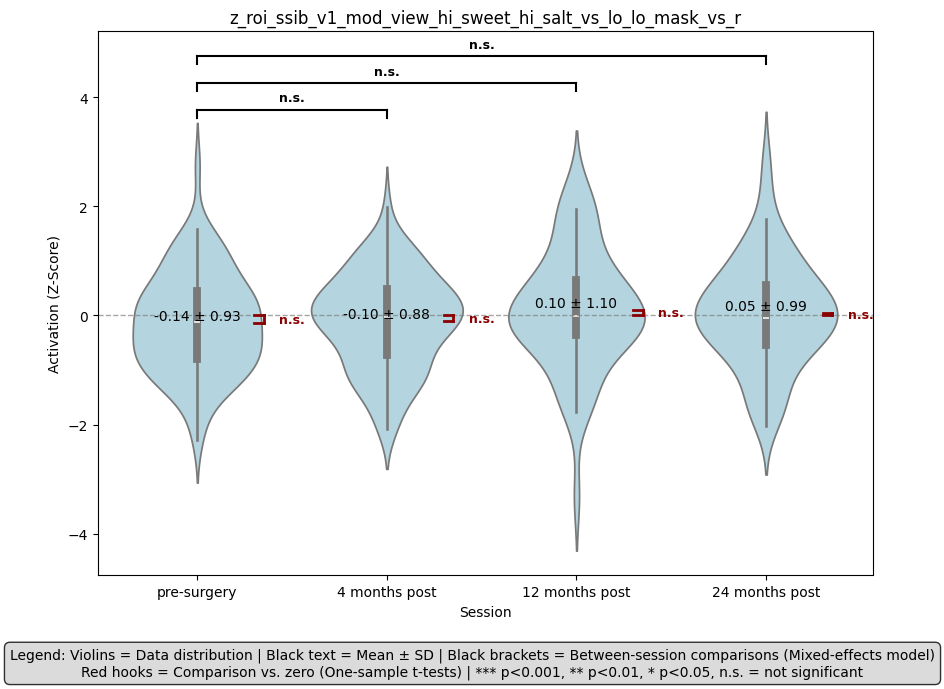

(                                  Pré-Chirurgie        4 mois       12 mois  \
 N                                          77.0          80.0          54.0   
 Age (mean ± std)                   43.82 ± 9.39  44.40 ± 9.21  45.98 ± 9.16   
 Sexe (M:F)                              60 : 17       62 : 18       41 : 13   
 Gastrectomie (n)                           43.0          45.0          26.0   
 RYGB (n)                                   14.0          16.0          13.0   
 DBP-SD (n)                                 20.0          19.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.03  35.94 ± 5.05  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.66 ± 9.99  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          55.0      NaN  
 Age (mean ± std)                   47.09 ± 8.93     None  
 Sexe (M:F)                              44 : 11     None  
 Gastrectomie (n)                     

In [61]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_mod_view_Hi_Sweet_Hi_Salt_vs_Lo_Lo_mask_VS_R')

### mod view hi salt vs lolo vmpfcL

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

                                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_mod_view_hi_salt_vs_lo_lo_mask_vmpfc_l_merged
No. Observations: 266     Method:             REML                                                       
No. Groups:       90      Scale:              0.5953                                                     
Min. group size:  1       Log-Likelihood:     -325.3455                                                  
Max. group size:  4       Converged:          Yes                                                        
Mean group size:  3.0                                                                                    
-------------------------------------------------------------------------------------------------------------------
                       Coef.            Std.Err.             z              P>|z|           [0.025           0.975]
------------------------------------------------------------

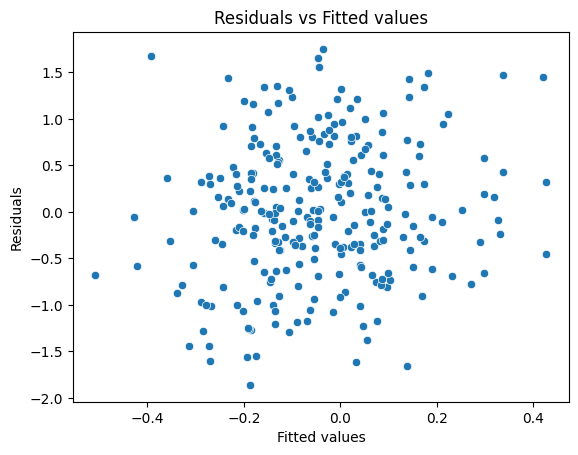

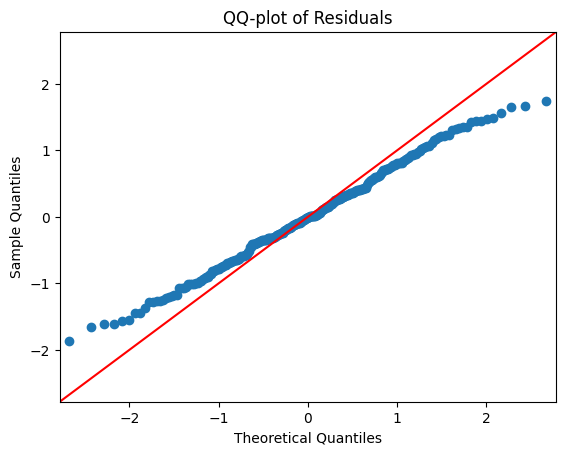

Breusch-Pagan test p-value: 0.0006865975791844383
Heteroscedasticity detected. The variance of residuals is not constant.
Shapiro-Wilk test p-value: 0.351660438872845
Residuals are normally distributed.
        feature         VIF
0     Intercept  164.491144
1  session[T.2]    1.430462
2  session[T.3]    1.370921
3  session[T.4]    1.404149
4      type_chx    1.144495
5           age    1.139220
6  IMC_baseline    1.077982
7          sexe    1.078545
                                 chi2                P>chi2  df constraint
Intercept      [[2.9695110488083376]]    0.0848474957630806              1
session        [[0.6827803645498272]]    0.8772465121606008              3
type_chx       [[3.7027645283581148]]   0.05432239299390631              1
age           [[0.27615529754205015]]     0.599232315587022              1
IMC_baseline    [[6.709519662975055]]  0.009589955310422643              1
sexe          [[0.10922844329911337]]    0.7410242575664893              1
AIC: 668.69108495138

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


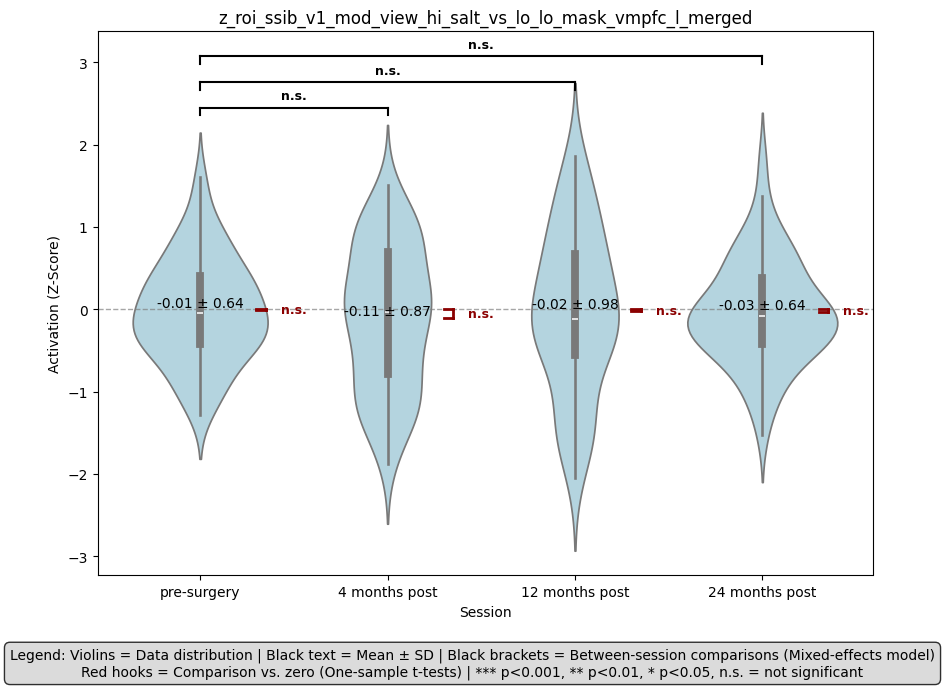

(                                  Pré-Chirurgie        4 mois       12 mois  \
 N                                          77.0          80.0          54.0   
 Age (mean ± std)                   43.82 ± 9.39  44.40 ± 9.21  45.98 ± 9.16   
 Sexe (M:F)                              60 : 17       62 : 18       41 : 13   
 Gastrectomie (n)                           43.0          45.0          26.0   
 RYGB (n)                                   14.0          16.0          13.0   
 DBP-SD (n)                                 20.0          19.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.03  35.94 ± 5.05  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.66 ± 9.99  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          55.0      NaN  
 Age (mean ± std)                   47.09 ± 8.93     None  
 Sexe (M:F)                              44 : 11     None  
 Gastrectomie (n)                     

In [62]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_mod_view_Hi_Salt_vs_Lo_Lo_mask_vmPFC_L_merged')

### mod view hi salt vs lolo dLPFC


                                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_mod_view_hi_salt_vs_lo_lo_mask_dlpfc_r_merged
No. Observations: 263     Method:             REML                                                       
No. Groups:       90      Scale:              0.7643                                                     
Min. group size:  1       Log-Likelihood:     -365.3641                                                  
Max. group size:  4       Converged:          Yes                                                        
Mean group size:  2.9                                                                                    
-------------------------------------------------------------------------------------------------------------------
                       Coef.            Std.Err.             z              P>|z|           [0.025           0.975]
------------------------------------------------------------

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

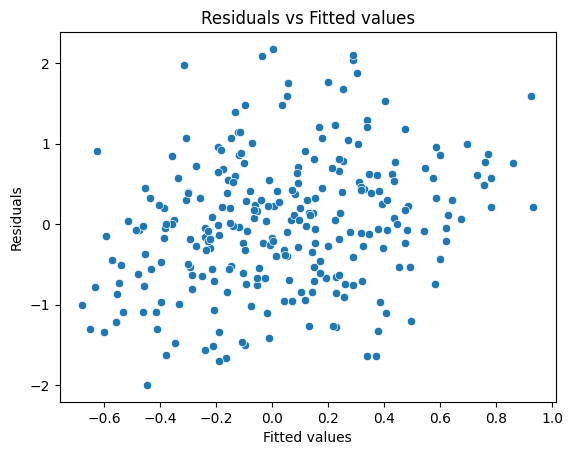

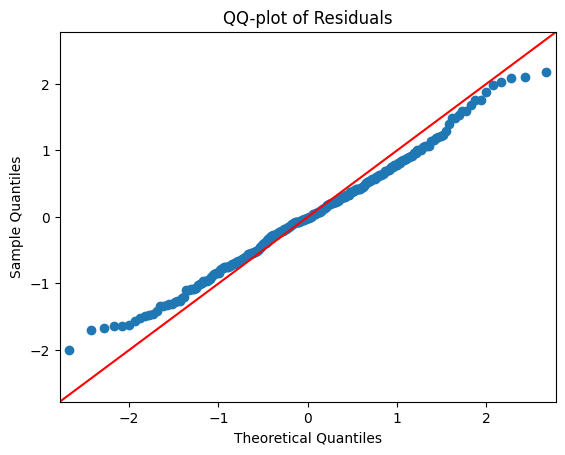

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


Breusch-Pagan test p-value: 0.37647424823343495
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.28825848652050035
Residuals are normally distributed.
        feature         VIF
0     Intercept  162.882868
1  session[T.2]    1.431652
2  session[T.3]    1.376375
3  session[T.4]    1.403552
4      type_chx    1.152913
5           age    1.149130
6  IMC_baseline    1.080640
7          sexe    1.078537
                                  chi2                 P>chi2  df constraint
Intercept     [[0.056586311495119876]]     0.8119751183025607              1
session          [[15.75459255682591]]  0.0012732076185707202              3
type_chx         [[2.327146954611893]]    0.12713470274811686              1
age            [[0.02377283765198258]]     0.8774643204984917              1
IMC_baseline    [[0.1444015282273042]]     0.7039439225048979              1
sexe            [[2.8661062510983544]]      0.090463492276009              1
AIC: 74

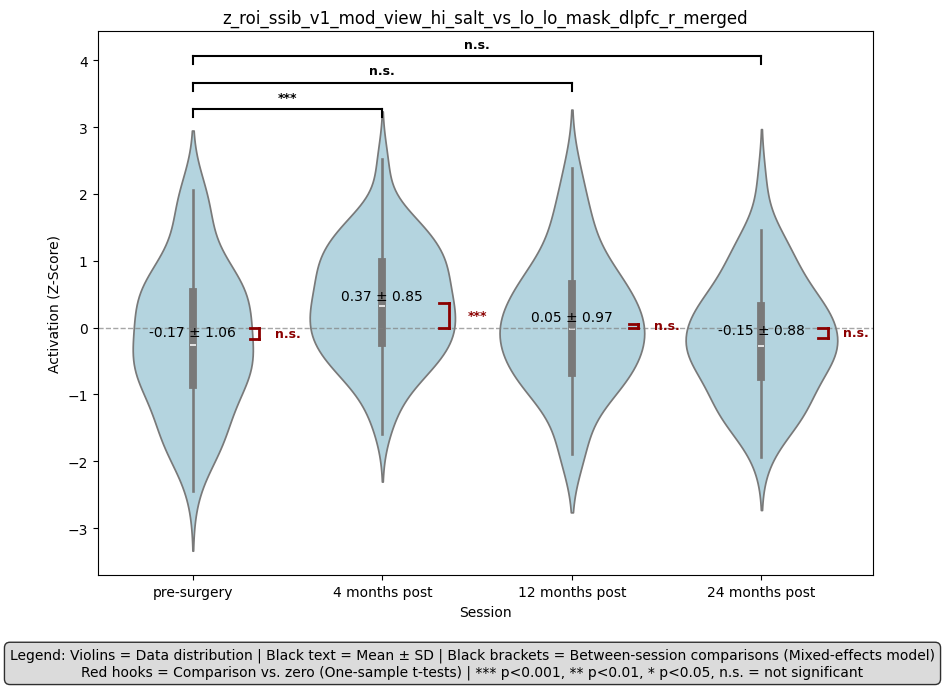

(                                  Pré-Chirurgie         4 mois       12 mois  \
 N                                          76.0           79.0          54.0   
 Age (mean ± std)                   43.77 ± 9.44   44.35 ± 9.26  45.98 ± 9.16   
 Sexe (M:F)                              59 : 17        61 : 18       41 : 13   
 Gastrectomie (n)                           43.0           45.0          26.0   
 RYGB (n)                                   14.0           16.0          13.0   
 DBP-SD (n)                                 19.0           18.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.06   35.96 ± 5.09  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.62 ± 10.04  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          54.0      NaN  
 Age (mean ± std)                   47.03 ± 9.01     None  
 Sexe (M:F)                              43 : 11     None  
 Gastrectomie (n)            

In [63]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_mod_view_Hi_Salt_vs_Lo_Lo_mask_dlPFC_R_merged')

### mod view hi salt vs lolo VS L


                             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_mod_view_hi_salt_vs_lo_lo_mask_vs_l
No. Observations: 266     Method:             REML                                             
No. Groups:       90      Scale:              0.6950                                           
Min. group size:  1       Log-Likelihood:     -352.5495                                        
Max. group size:  4       Converged:          Yes                                              
Mean group size:  3.0                                                                          
-------------------------------------------------------------------------------------------------------
                     Coef.          Std.Err.           z            P>|z|         [0.025         0.975]
-------------------------------------------------------------------------------------------------------
Intercept            -0.530            0.755 

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

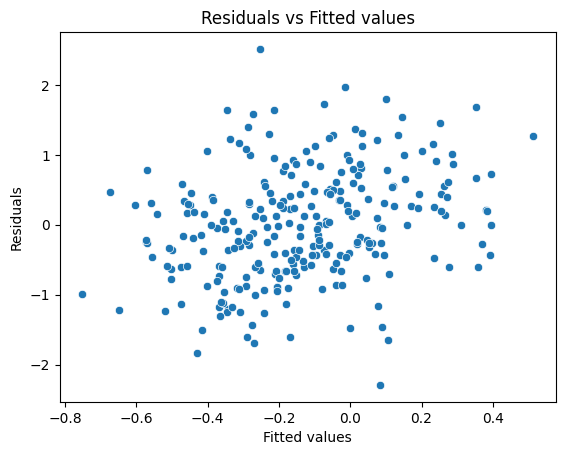

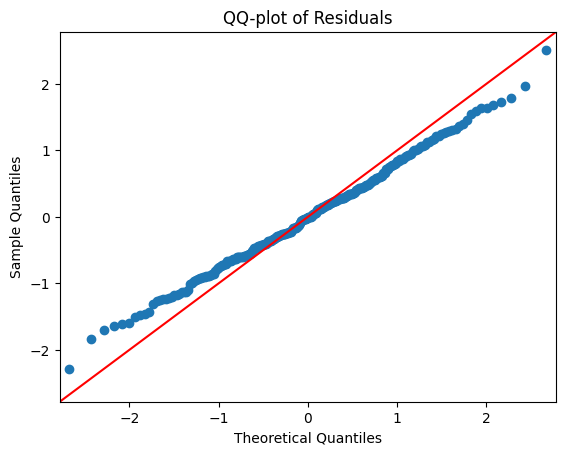

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


Breusch-Pagan test p-value: 0.5167044175158284
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.966404154877078
Residuals are normally distributed.
        feature         VIF
0     Intercept  164.491144
1  session[T.2]    1.430462
2  session[T.3]    1.370921
3  session[T.4]    1.404149
4      type_chx    1.144495
5           age    1.139220
6  IMC_baseline    1.077982
7          sexe    1.078545
                                 chi2               P>chi2  df constraint
Intercept      [[0.4931441181276406]]   0.4825281276601078              1
session         [[6.318211823145795]]  0.09711417990681061              3
type_chx        [[4.151757218972995]]  0.04159134074720573              1
age           [[0.09803305408519682]]   0.7542029371125837              1
IMC_baseline    [[0.451719262295527]]   0.5015196328992984              1
sexe           [[0.0411110051100156]]   0.8393238044378399              1
AIC: 723.099057501782
BIC: 755.

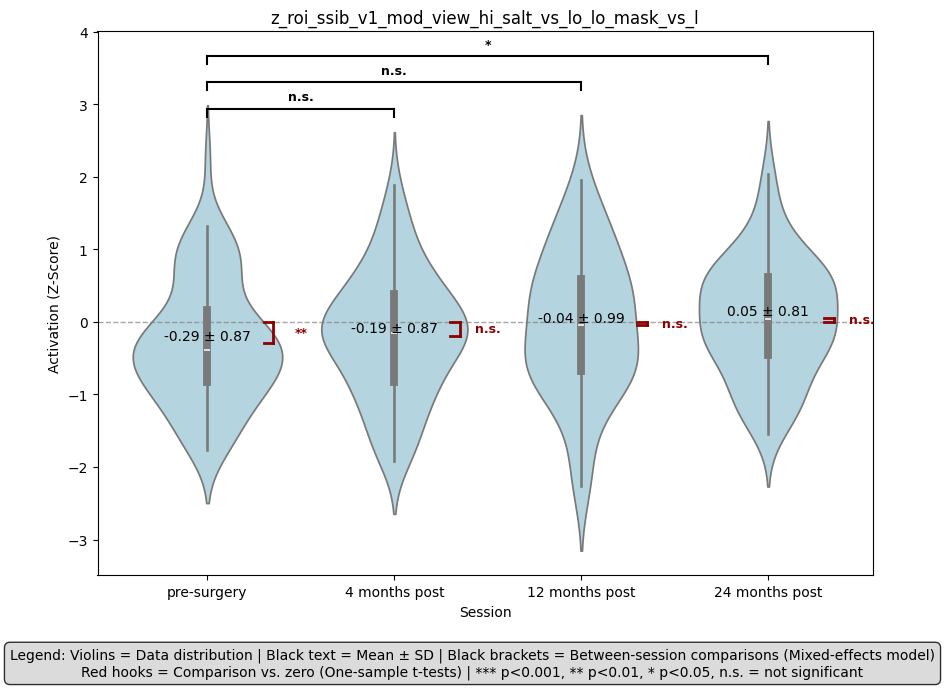

(                                  Pré-Chirurgie        4 mois       12 mois  \
 N                                          77.0          80.0          54.0   
 Age (mean ± std)                   43.82 ± 9.39  44.40 ± 9.21  45.98 ± 9.16   
 Sexe (M:F)                              60 : 17       62 : 18       41 : 13   
 Gastrectomie (n)                           43.0          45.0          26.0   
 RYGB (n)                                   14.0          16.0          13.0   
 DBP-SD (n)                                 20.0          19.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.03  35.94 ± 5.05  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.66 ± 9.99  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          55.0      NaN  
 Age (mean ± std)                   47.09 ± 8.93     None  
 Sexe (M:F)                              44 : 11     None  
 Gastrectomie (n)                     

In [64]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_mod_view_Hi_Salt_vs_Lo_Lo_mask_VS_L')

### mod view hi salt vs lolo VS R


                             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_mod_view_hi_salt_vs_lo_lo_mask_vs_r
No. Observations: 266     Method:             REML                                             
No. Groups:       90      Scale:              0.8116                                           
Min. group size:  1       Log-Likelihood:     -377.5194                                        
Max. group size:  4       Converged:          Yes                                              
Mean group size:  3.0                                                                          
-------------------------------------------------------------------------------------------------------
                     Coef.          Std.Err.           z            P>|z|         [0.025         0.975]
-------------------------------------------------------------------------------------------------------
Intercept            -0.698            0.867 

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

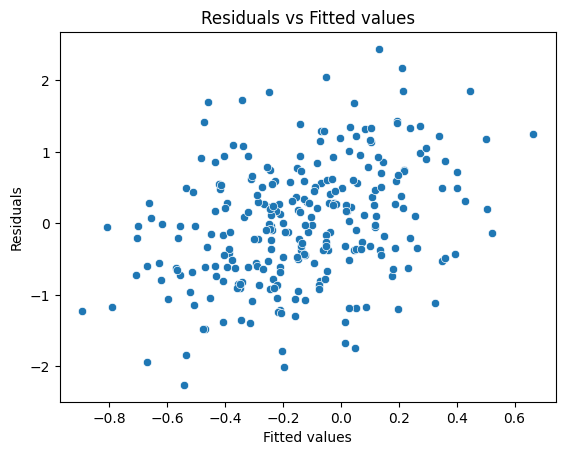

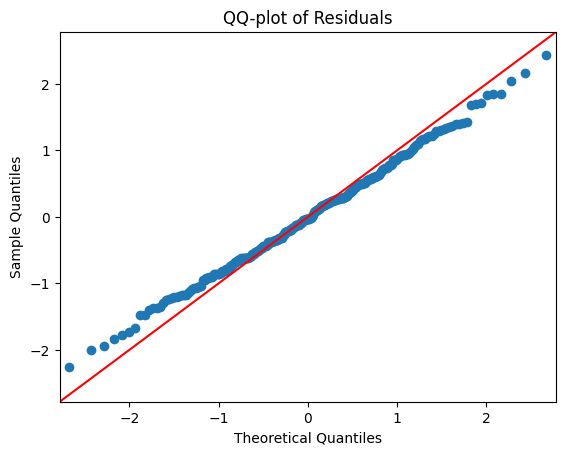

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


Breusch-Pagan test p-value: 0.5910622740330949
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.9465857261254885
Residuals are normally distributed.
        feature         VIF
0     Intercept  164.491144
1  session[T.2]    1.430462
2  session[T.3]    1.370921
3  session[T.4]    1.404149
4      type_chx    1.144495
5           age    1.139220
6  IMC_baseline    1.077982
7          sexe    1.078545
                                  chi2               P>chi2  df constraint
Intercept       [[0.6489593266484512]]  0.42048499328648037              1
session          [[2.955349539195143]]   0.3985607553034146              3
type_chx        [[3.9911371413285273]]  0.04574018502985435              1
age           [[0.007027447611301457]]   0.9331916963699298              1
IMC_baseline    [[1.0563575243253207]]   0.3040474218021051              1
sexe           [[0.02428785319035333]]   0.8761547206890726              1
AIC: 773.0387248334355


/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


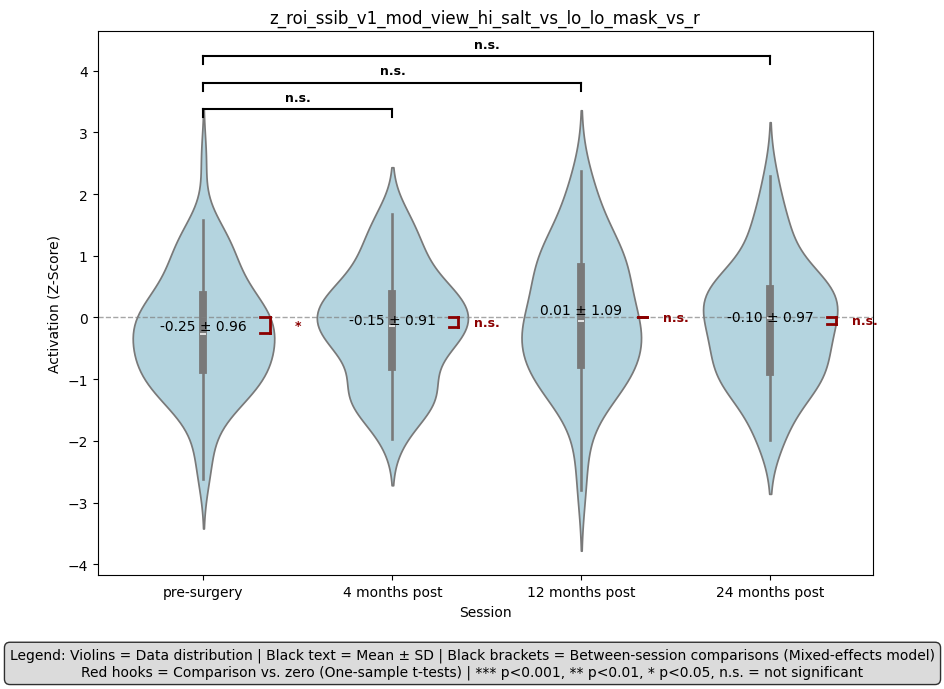

(                                  Pré-Chirurgie        4 mois       12 mois  \
 N                                          77.0          80.0          54.0   
 Age (mean ± std)                   43.82 ± 9.39  44.40 ± 9.21  45.98 ± 9.16   
 Sexe (M:F)                              60 : 17       62 : 18       41 : 13   
 Gastrectomie (n)                           43.0          45.0          26.0   
 RYGB (n)                                   14.0          16.0          13.0   
 DBP-SD (n)                                 20.0          19.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.03  35.94 ± 5.05  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.66 ± 9.99  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          55.0      NaN  
 Age (mean ± std)                   47.09 ± 8.93     None  
 Sexe (M:F)                              44 : 11     None  
 Gastrectomie (n)                     

In [65]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_mod_view_Hi_Salt_vs_Lo_Lo_mask_VS_R')

### mod view high sweet vs lo_lo vmPFC_L

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

                                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_mod_view_hi_sweet_vs_lo_lo_mask_vmpfc_l_merged
No. Observations: 266     Method:             REML                                                        
No. Groups:       90      Scale:              0.7077                                                      
Min. group size:  1       Log-Likelihood:     -343.5434                                                   
Max. group size:  4       Converged:          No                                                          
Mean group size:  3.0                                                                                     
--------------------------------------------------------------------------------------------------------------------
                        Coef.            Std.Err.             z              P>|z|           [0.025           0.975]
----------------------------------------------------

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.954034
  warnings.warn(msg, ConvergenceWarning)
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


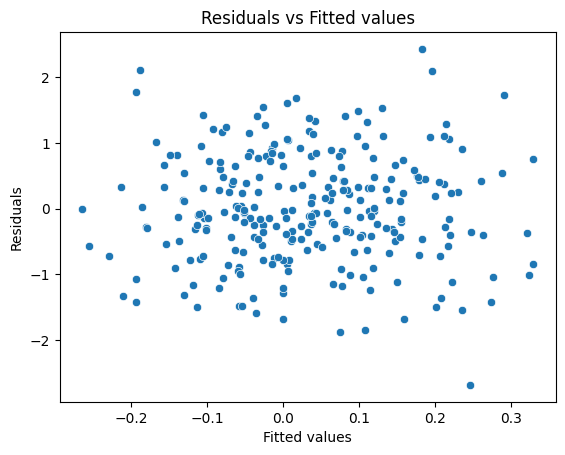

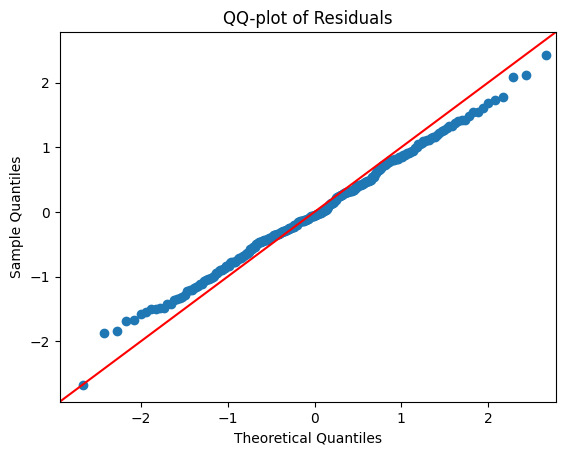

Breusch-Pagan test p-value: 0.28516985852956506
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.9657184350931488
Residuals are normally distributed.
        feature         VIF
0     Intercept  164.491144
1  session[T.2]    1.430462
2  session[T.3]    1.370921
3  session[T.4]    1.404149
4      type_chx    1.144495
5           age    1.139220
6  IMC_baseline    1.077982
7          sexe    1.078545
                                 chi2               P>chi2  df constraint
Intercept     [[0.19663735021614917]]    0.657448881495723              1
session         [[1.590474736484739]]   0.6615515328578778              3
type_chx      [[0.48439275960701844]]   0.4864392856723554              1
age            [[0.9098873502259667]]   0.3401443097822076              1
IMC_baseline   [[1.5093754255183742]]  0.21923441563361484              1
sexe           [[0.5528429108466892]]   0.4571584034155276              1
AIC: 705.0867164416261
BIC: 7

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


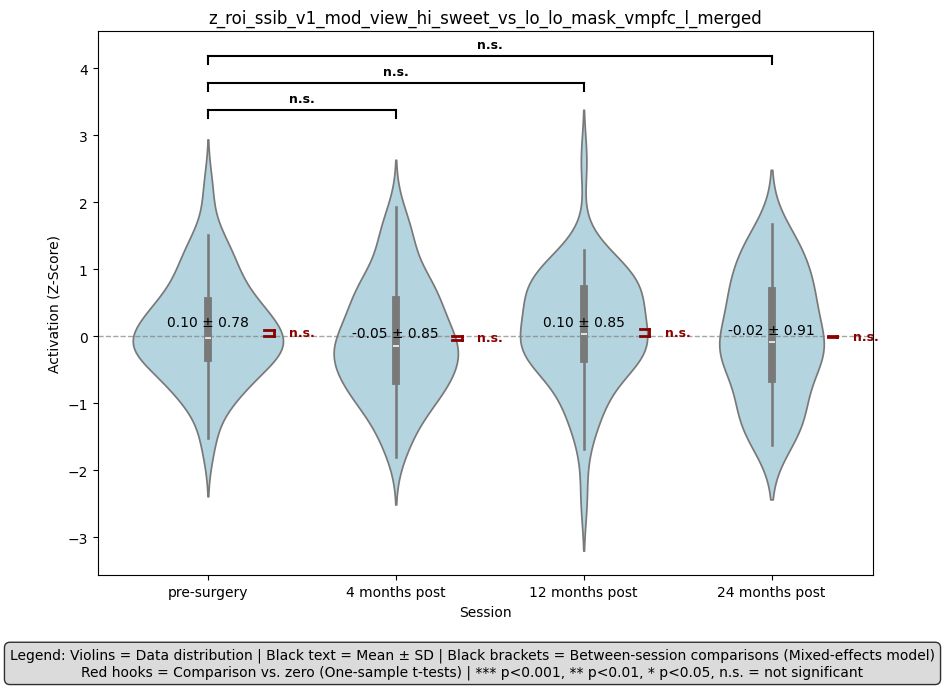

(                                  Pré-Chirurgie        4 mois       12 mois  \
 N                                          77.0          80.0          54.0   
 Age (mean ± std)                   43.82 ± 9.39  44.40 ± 9.21  45.98 ± 9.16   
 Sexe (M:F)                              60 : 17       62 : 18       41 : 13   
 Gastrectomie (n)                           43.0          45.0          26.0   
 RYGB (n)                                   14.0          16.0          13.0   
 DBP-SD (n)                                 20.0          19.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.03  35.94 ± 5.05  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.66 ± 9.99  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          55.0      NaN  
 Age (mean ± std)                   47.09 ± 8.93     None  
 Sexe (M:F)                              44 : 11     None  
 Gastrectomie (n)                     

In [66]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_mod_view_Hi_Sweet_vs_Lo_Lo_mask_vmPFC_L_merged')

### Hi sweet vs lo_lo, dlPFC right

                                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_mod_view_hi_sweet_vs_lo_lo_mask_dlpfc_r_merged
No. Observations: 263     Method:             REML                                                        
No. Groups:       90      Scale:              0.8054                                                      
Min. group size:  1       Log-Likelihood:     -369.4236                                                   
Max. group size:  4       Converged:          Yes                                                         
Mean group size:  2.9                                                                                     
--------------------------------------------------------------------------------------------------------------------
                        Coef.            Std.Err.             z              P>|z|           [0.025           0.975]
----------------------------------------------------

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

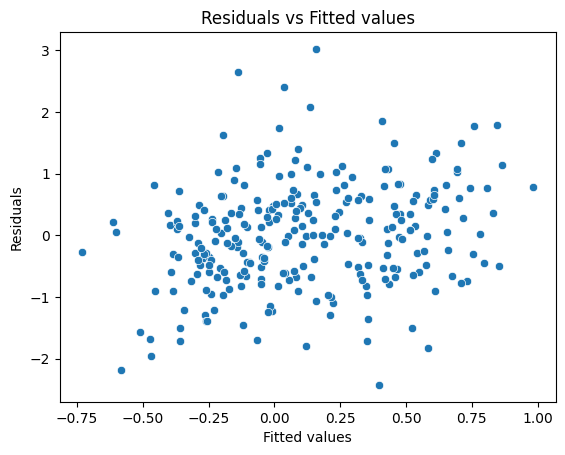

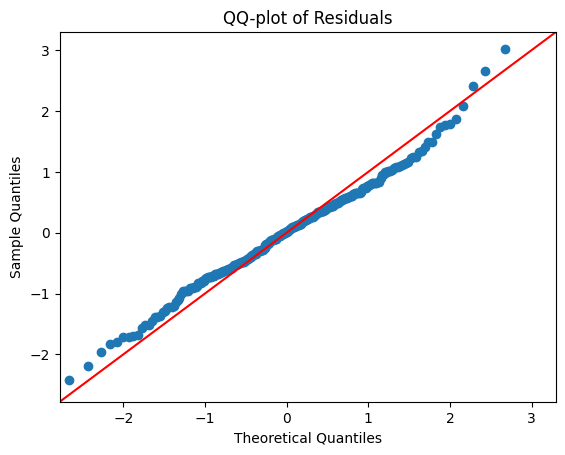

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


Breusch-Pagan test p-value: 0.688563594386943
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.24261922904151362
Residuals are normally distributed.
        feature         VIF
0     Intercept  162.882868
1  session[T.2]    1.431652
2  session[T.3]    1.376375
3  session[T.4]    1.403552
4      type_chx    1.152913
5           age    1.149130
6  IMC_baseline    1.080640
7          sexe    1.078537
                                   chi2                 P>chi2  df constraint
Intercept     [[0.0021720628631744753]]     0.9628277319449634              1
session           [[26.80655217444871]]  6.463539047927309e-06              3
type_chx      [[0.0036291556659142038]]     0.9519625178145774              1
age              [[0.9573429455099819]]     0.3278572298716063              1
IMC_baseline     [[0.6056439116561695]]      0.436432684603008              1
sexe            [[0.12020341184033648]]      0.728813977657258              1
AI

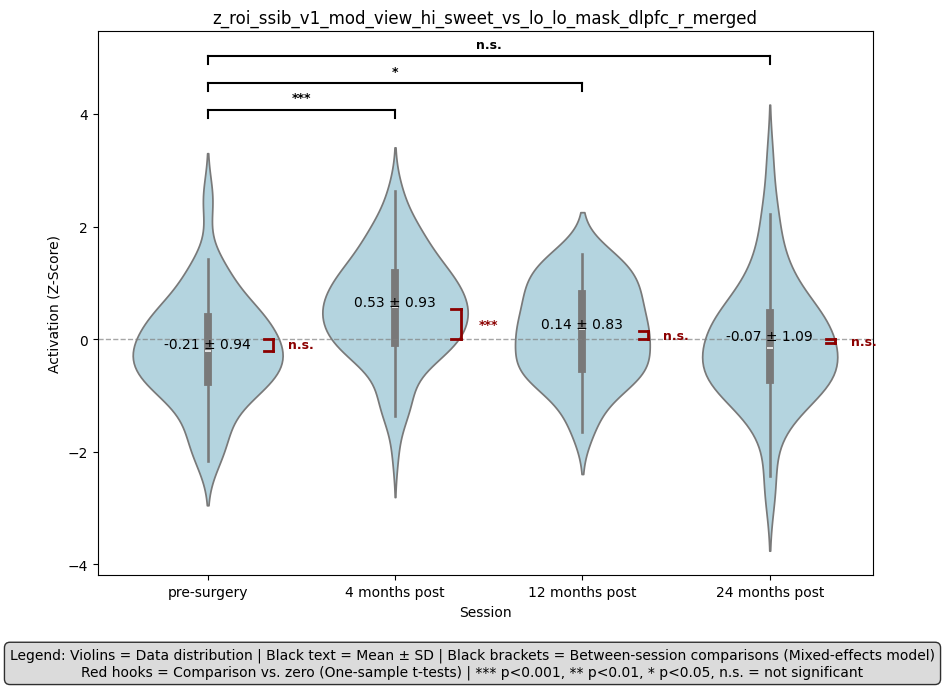

(                                  Pré-Chirurgie         4 mois       12 mois  \
 N                                          76.0           79.0          54.0   
 Age (mean ± std)                   43.77 ± 9.44   44.35 ± 9.26  45.98 ± 9.16   
 Sexe (M:F)                              59 : 17        61 : 18       41 : 13   
 Gastrectomie (n)                           43.0           45.0          26.0   
 RYGB (n)                                   14.0           16.0          13.0   
 DBP-SD (n)                                 19.0           18.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.06   35.96 ± 5.09  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.62 ± 10.04  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          54.0      NaN  
 Age (mean ± std)                   47.03 ± 9.01     None  
 Sexe (M:F)                              43 : 11     None  
 Gastrectomie (n)            

In [67]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_mod_view_Hi_Sweet_vs_Lo_Lo_mask_dlPFC_R_merged')

### Hi sweet vs Lo Lo VS L

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

                             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_mod_view_hi_sweet_vs_lo_lo_mask_vs_l
No. Observations: 266     Method:             REML                                              
No. Groups:       90      Scale:              0.6643                                            
Min. group size:  1       Log-Likelihood:     -353.5081                                         
Max. group size:  4       Converged:          Yes                                               
Mean group size:  3.0                                                                           
--------------------------------------------------------------------------------------------------------
                      Coef.          Std.Err.           z            P>|z|         [0.025         0.975]
--------------------------------------------------------------------------------------------------------
Intercept             -0.655        

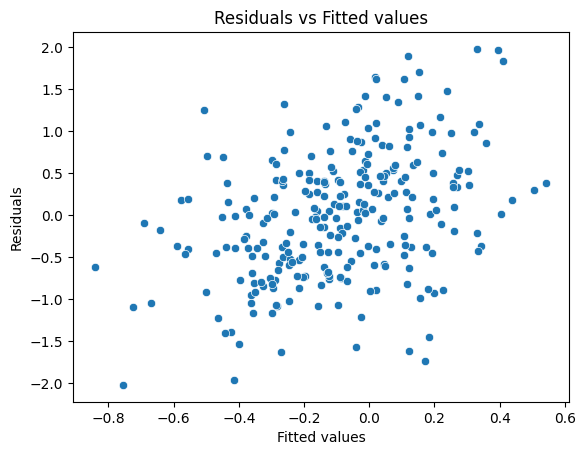

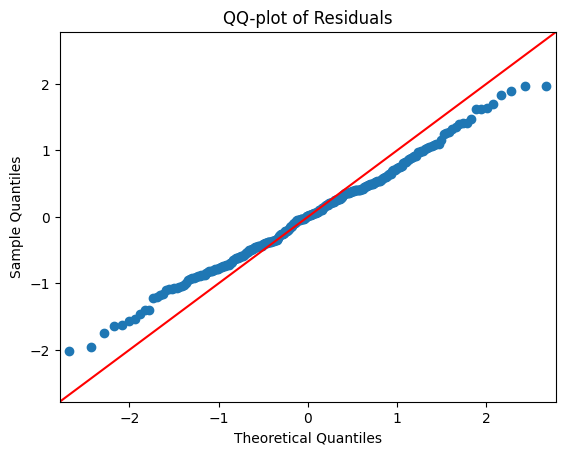

Breusch-Pagan test p-value: 0.6622168990564629
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.6331636389558981
Residuals are normally distributed.
        feature         VIF
0     Intercept  164.491144
1  session[T.2]    1.430462
2  session[T.3]    1.370921
3  session[T.4]    1.404149
4      type_chx    1.144495
5           age    1.139220
6  IMC_baseline    1.077982
7          sexe    1.078545
                                   chi2               P>chi2  df constraint
Intercept        [[0.6640275308674648]]   0.4151416639642146              1
session           [[3.209064763456158]]  0.36050097939341724              3
type_chx       [[0.008771080396575752]]   0.9253839754659949              1
age              [[1.8169414780530604]]  0.17767777272244537              1
IMC_baseline  [[0.0036074313377259387]]   0.9521063378239479              1
sexe            [[0.04357567423087597]]   0.8346450665277269              1
AIC: 725.0162376

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


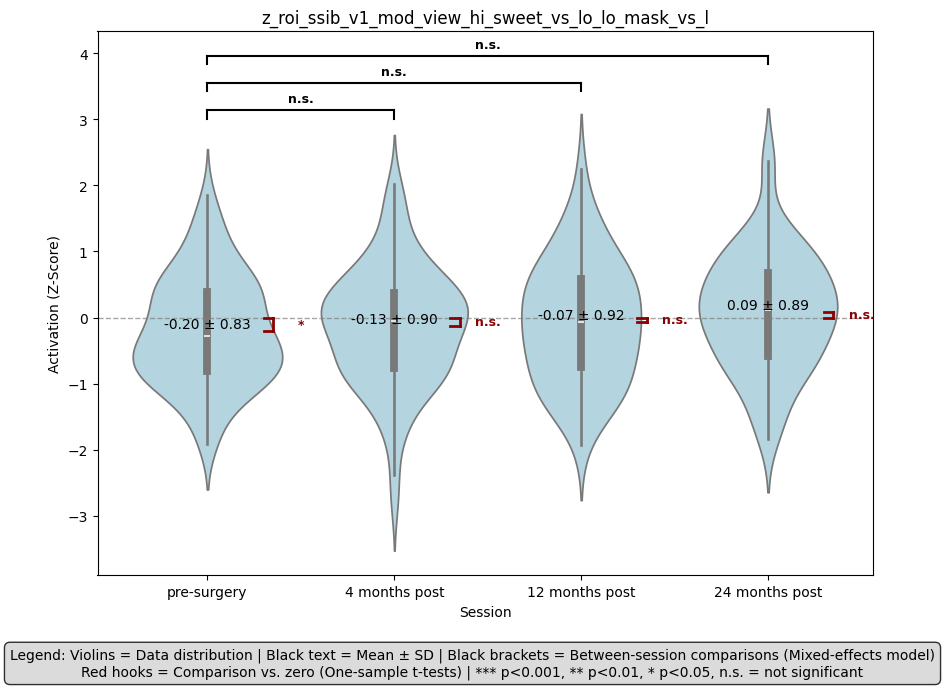

(                                  Pré-Chirurgie        4 mois       12 mois  \
 N                                          77.0          80.0          54.0   
 Age (mean ± std)                   43.82 ± 9.39  44.40 ± 9.21  45.98 ± 9.16   
 Sexe (M:F)                              60 : 17       62 : 18       41 : 13   
 Gastrectomie (n)                           43.0          45.0          26.0   
 RYGB (n)                                   14.0          16.0          13.0   
 DBP-SD (n)                                 20.0          19.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.03  35.94 ± 5.05  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.66 ± 9.99  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          55.0      NaN  
 Age (mean ± std)                   47.09 ± 8.93     None  
 Sexe (M:F)                              44 : 11     None  
 Gastrectomie (n)                     

In [68]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_mod_view_Hi_Sweet_vs_Lo_Lo_mask_VS_L')

### Hi Sweet vs Lo_Lo VS R

                             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_mod_view_hi_sweet_vs_lo_lo_mask_vs_r
No. Observations: 266     Method:             REML                                              
No. Groups:       90      Scale:              0.6914                                            
Min. group size:  1       Log-Likelihood:     -354.2178                                         
Max. group size:  4       Converged:          Yes                                               
Mean group size:  3.0                                                                           
--------------------------------------------------------------------------------------------------------
                      Coef.          Std.Err.           z            P>|z|         [0.025         0.975]
--------------------------------------------------------------------------------------------------------
Intercept             -0.150        

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

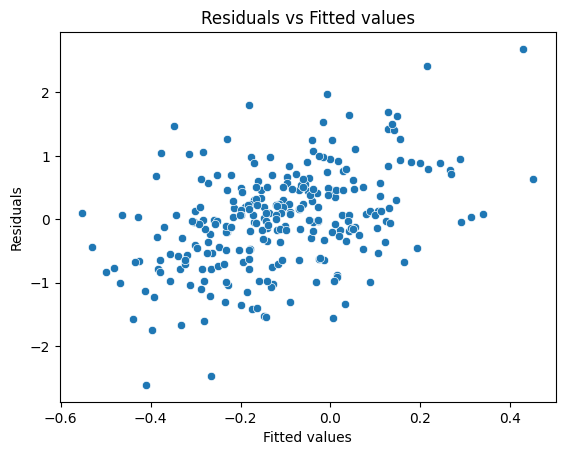

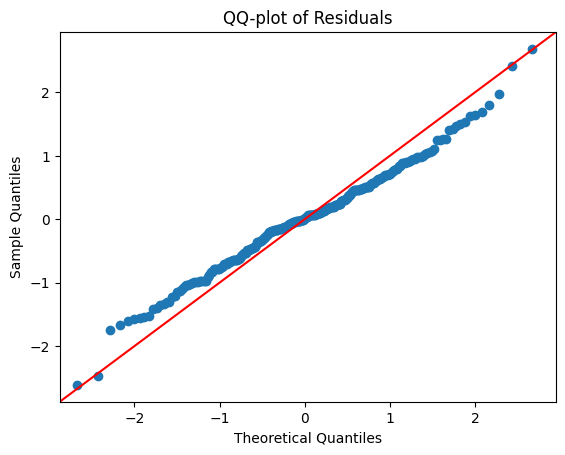

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


Breusch-Pagan test p-value: 0.1988951538248686
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.1500284959958087
Residuals are normally distributed.
        feature         VIF
0     Intercept  164.491144
1  session[T.2]    1.430462
2  session[T.3]    1.370921
3  session[T.4]    1.404149
4      type_chx    1.144495
5           age    1.139220
6  IMC_baseline    1.077982
7          sexe    1.078545
                                 chi2              P>chi2  df constraint
Intercept     [[0.03732397313584924]]  0.8468069331482156              1
session        [[1.3948823209228682]]  0.7067347810223182              3
type_chx      [[0.12201454232494148]]  0.7268597441594533              1
age           [[0.17154818789366905]]  0.6787395335752151              1
IMC_baseline    [[0.161033851083433]]  0.6882064536650525              1
sexe          [[0.07358746946485747]]  0.7861832980199414              1
AIC: 726.4355305895392
BIC: 758.68699

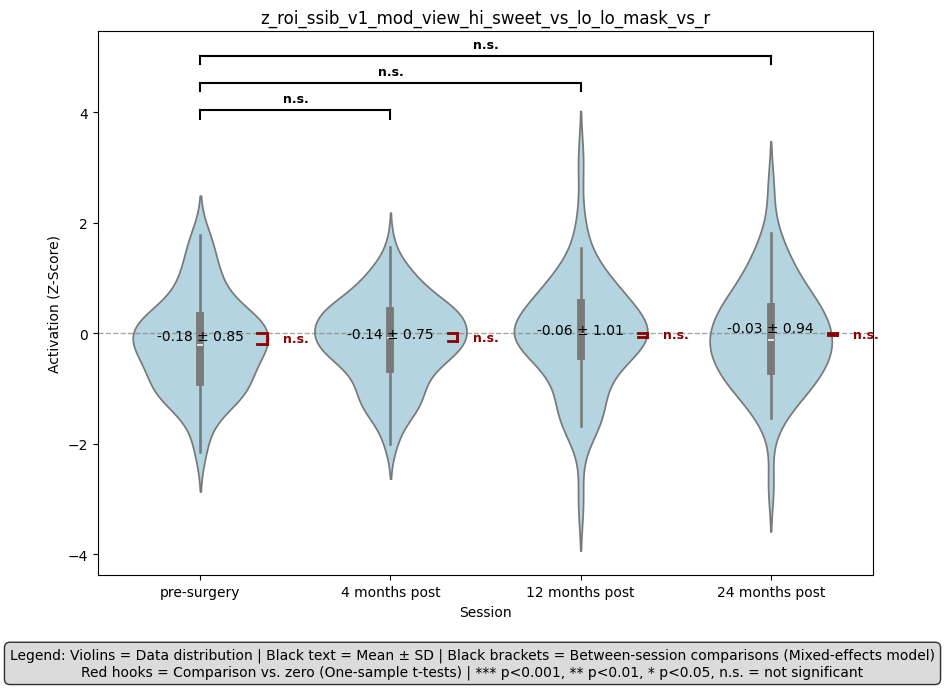

(                                  Pré-Chirurgie        4 mois       12 mois  \
 N                                          77.0          80.0          54.0   
 Age (mean ± std)                   43.82 ± 9.39  44.40 ± 9.21  45.98 ± 9.16   
 Sexe (M:F)                              60 : 17       62 : 18       41 : 13   
 Gastrectomie (n)                           43.0          45.0          26.0   
 RYGB (n)                                   14.0          16.0          13.0   
 DBP-SD (n)                                 20.0          19.0          15.0   
 IMC (kg/m2) (moy. ± et.)           44.22 ± 4.03  35.94 ± 5.05  28.68 ± 4.20   
 Pourcentage de perte de poids (%)   0.00 ± 0.00  17.66 ± 9.99  35.45 ± 7.65   
 
                                         24 mois Valeur P  
 N                                          55.0      NaN  
 Age (mean ± std)                   47.09 ± 8.93     None  
 Sexe (M:F)                              44 : 11     None  
 Gastrectomie (n)                     

In [69]:
roi_analysis_GB(participants=participants, roi_dm_contrast='Z_ROI_ssib_v1_mod_view_Hi_Sweet_vs_Lo_Lo_mask_VS_R')

# Run FDR correction on relevant contrasts


ANALYZING: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged

ANALYZING: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlPFC_R_merged

ANALYZING: Z_ROI_ssib_v2_simple_mod_view_vs_view_cross_mask_VS_L

ANALYZING: Z_ROI_ssib_v2_simple_mod_view_vs_view_cross_mask_VS_R


/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part


ANALYZING: Z_ROI_ssib_v1_Hi_vs_Lo_mask_vmPFC_L_merged

ANALYZING: Z_ROI_ssib_v1_Hi_vs_Lo_mask_dlPFC_R_merged

ANALYZING: Z_ROI_ssib_v1_Hi_vs_Lo_mask_VS_L


/tmp/ipykernel_142322/4073514655.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type_chx'] = df.groupby('id_participant')['type_chx'].transform(lambda x: x.fillna(x.iloc[0]))
/tmp/ipykernel_142322/4073514655.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sexe'] = df.groupby('id_participant')['sexe'].transform(lambda x: x.fillna(x.iloc[0]))
/tmp/ipykernel_142322/999374792.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wi


ANALYZING: Z_ROI_ssib_v1_Hi_vs_Lo_mask_VS_R

PERFORMING FDR CORRECTION ON ALL CONTRASTS
=== FDR CORRECTION RESULTS: BETWEEN-SESSIONS COMPARISONS ===
Method: fdr_bh, Alpha: 0.05
Number of tests: 24
Number of significant results (FDR-corrected): 2

                                                            ROI       Comparison    Beta  P_raw  P_FDR Significant_FDR
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged  4_months_vs_pre  0.0086 0.9577 0.9644              No
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged 12_months_vs_pre -0.3414 0.0626 0.1503              No
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged 24_months_vs_pre -0.5899 0.0015 0.0179             Yes
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlpfc_r_merged  4_months_vs_pre  0.0975 0.5843 0.6920              No
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlpfc_r_merged 12_months_vs_pre  0.2195 0.2754 0.4721              No
z_roi_ssib_v2_simple_mod_view_vs_view_

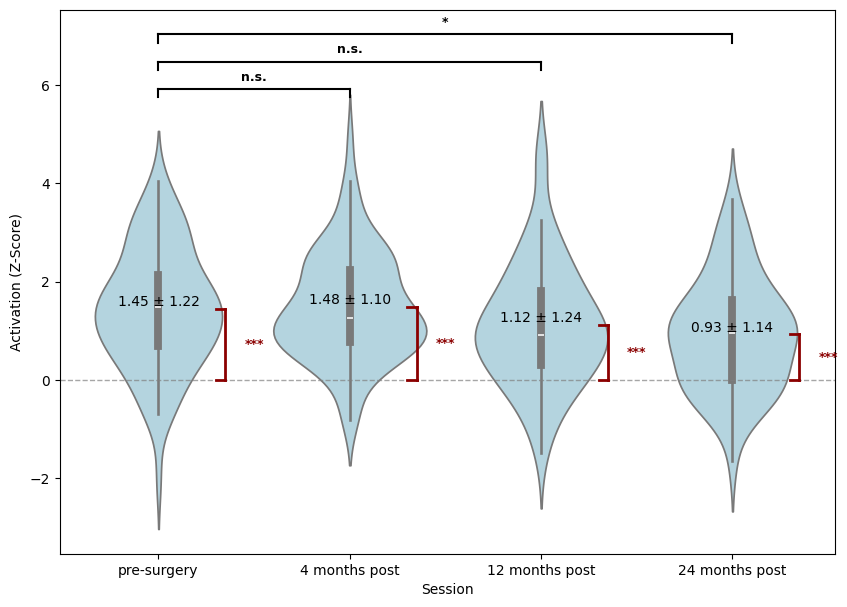


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.964430 (n.s.)
  12_months_vs_pre: p_FDR = 0.150328 (n.s.)
  24_months_vs_pre: p_FDR = 0.017902 (*)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.000000 (***)
  4 months: p_FDR = 0.000000 (***)
  12 months: p_FDR = 0.000000 (***)
  24 months: p_FDR = 0.000001 (***)

🎨 Regenerating graph for: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlPFC_R_merged


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

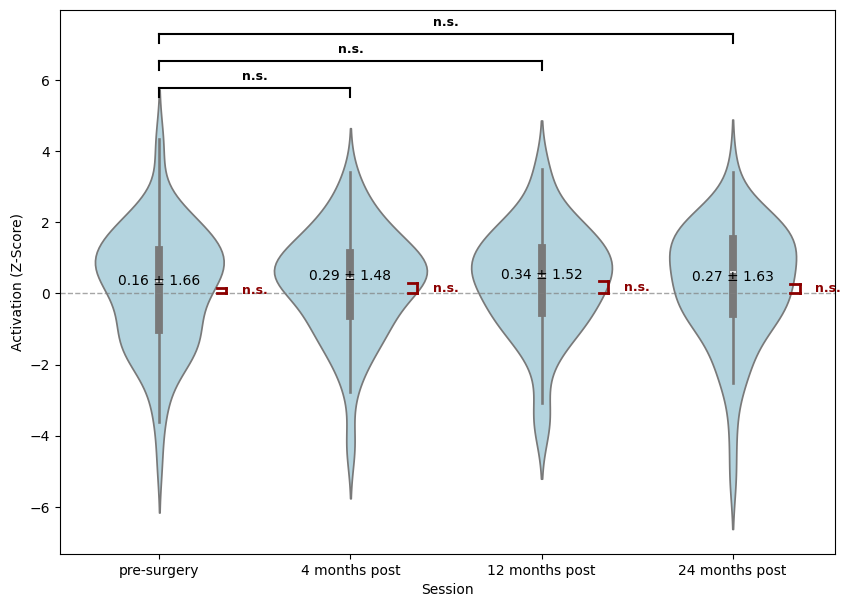


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlpfc_r_merged

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.692016 (n.s.)
  12_months_vs_pre: p_FDR = 0.472134 (n.s.)
  24_months_vs_pre: p_FDR = 0.692016 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.519979 (n.s.)
  4 months: p_FDR = 0.153157 (n.s.)
  12 months: p_FDR = 0.174899 (n.s.)
  24 months: p_FDR = 0.340100 (n.s.)

🎨 Regenerating graph for: Z_ROI_ssib_v2_simple_mod_view_vs_view_cross_mask_VS_L


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

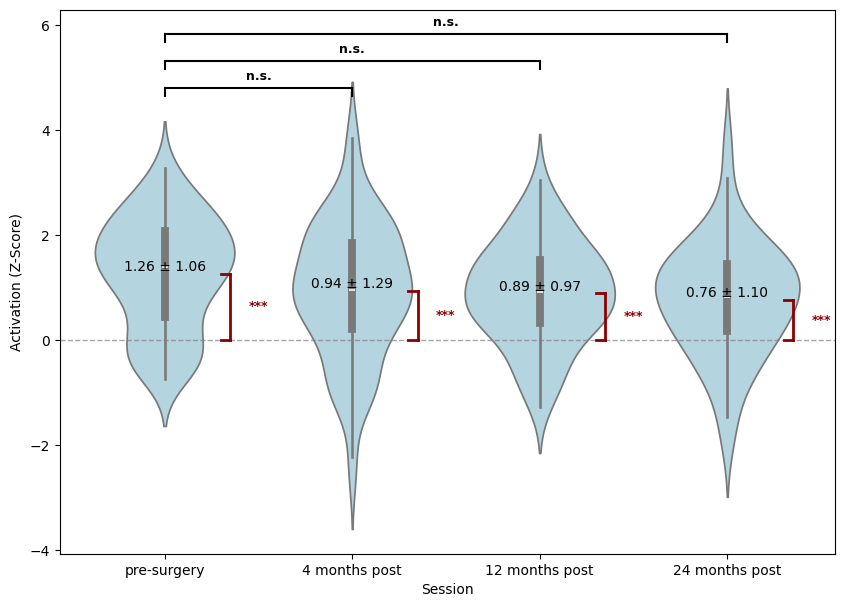


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vs_l

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.136790 (n.s.)
  12_months_vs_pre: p_FDR = 0.136790 (n.s.)
  24_months_vs_pre: p_FDR = 0.067959 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.000000 (***)
  4 months: p_FDR = 0.000000 (***)
  12 months: p_FDR = 0.000000 (***)
  24 months: p_FDR = 0.000009 (***)

🎨 Regenerating graph for: Z_ROI_ssib_v2_simple_mod_view_vs_view_cross_mask_VS_R


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

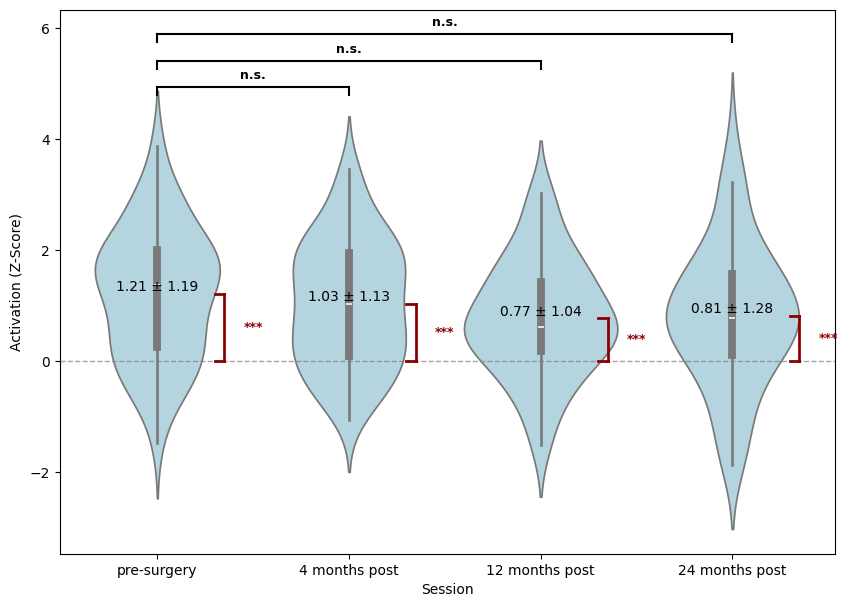


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vs_r

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.491284 (n.s.)
  12_months_vs_pre: p_FDR = 0.103301 (n.s.)
  24_months_vs_pre: p_FDR = 0.136790 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.000000 (***)
  4 months: p_FDR = 0.000000 (***)
  12 months: p_FDR = 0.000004 (***)
  24 months: p_FDR = 0.000045 (***)

🎨 Regenerating graph for: Z_ROI_ssib_v1_Hi_vs_Lo_mask_vmPFC_L_merged


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

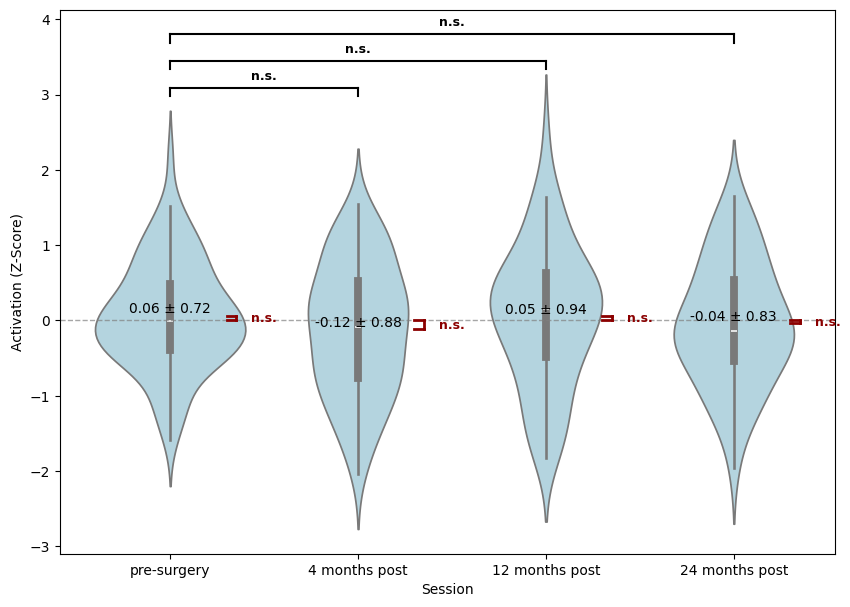


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v1_hi_vs_lo_mask_vmpfc_l_merged

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.394364 (n.s.)
  12_months_vs_pre: p_FDR = 0.964430 (n.s.)
  24_months_vs_pre: p_FDR = 0.692016 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.534538 (n.s.)
  4 months: p_FDR = 0.340100 (n.s.)
  12 months: p_FDR = 0.714845 (n.s.)
  24 months: p_FDR = 0.748670 (n.s.)

🎨 Regenerating graph for: Z_ROI_ssib_v1_Hi_vs_Lo_mask_dlPFC_R_merged


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

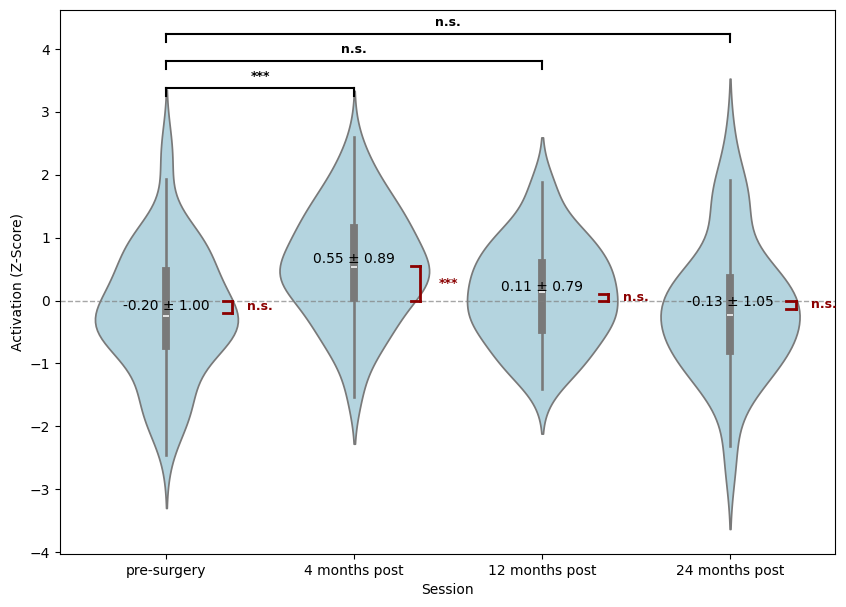


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v1_hi_vs_lo_mask_dlpfc_r_merged

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.000008 (***)
  12_months_vs_pre: p_FDR = 0.136790 (n.s.)
  24_months_vs_pre: p_FDR = 0.692016 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.154150 (n.s.)
  4 months: p_FDR = 0.000001 (***)
  12 months: p_FDR = 0.428821 (n.s.)
  24 months: p_FDR = 0.492074 (n.s.)

🎨 Regenerating graph for: Z_ROI_ssib_v1_Hi_vs_Lo_mask_VS_L


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

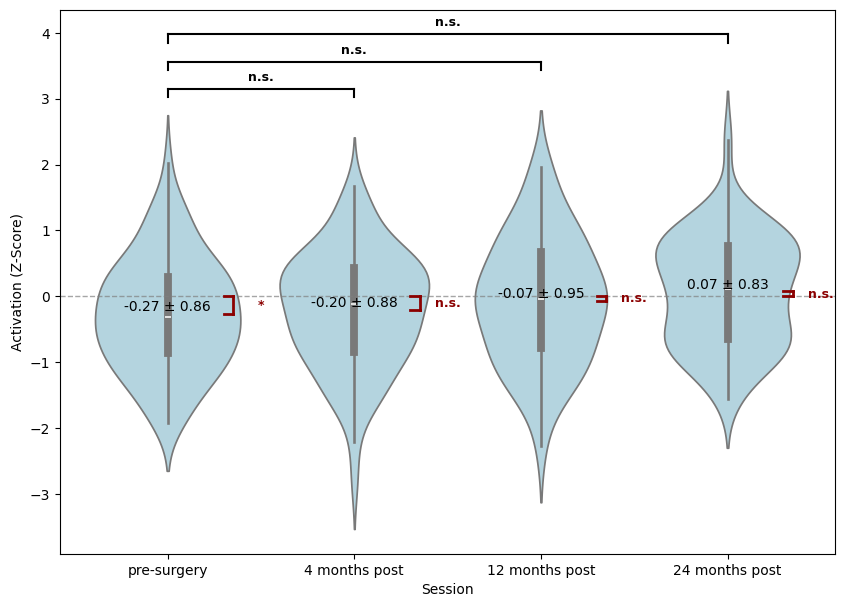


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v1_hi_vs_lo_mask_vs_l

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.692016 (n.s.)
  12_months_vs_pre: p_FDR = 0.330573 (n.s.)
  24_months_vs_pre: p_FDR = 0.103301 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.016814 (*)
  4 months: p_FDR = 0.085877 (n.s.)
  12 months: p_FDR = 0.656172 (n.s.)
  24 months: p_FDR = 0.588237 (n.s.)

🎨 Regenerating graph for: Z_ROI_ssib_v1_Hi_vs_Lo_mask_VS_R


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

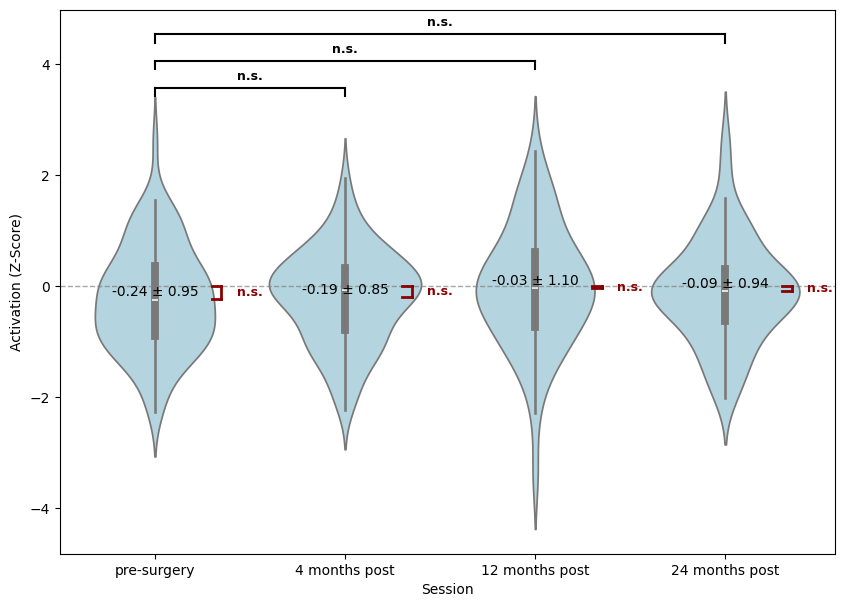


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v1_hi_vs_lo_mask_vs_r

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.817086 (n.s.)
  12_months_vs_pre: p_FDR = 0.330573 (n.s.)
  24_months_vs_pre: p_FDR = 0.484746 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.067243 (n.s.)
  4 months: p_FDR = 0.085877 (n.s.)
  12 months: p_FDR = 0.847253 (n.s.)
  24 months: p_FDR = 0.559280 (n.s.)


In [77]:
# Initialize dictionary for FDR correction
results_fdr_corrected = {}

# Build list of contrasts
contrasts_to_analyze = [
    'z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged',
    'z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlPFC_R_merged',
    'Z_ROI_ssib_v2_simple_mod_view_vs_view_cross_mask_VS_L',
    'Z_ROI_ssib_v2_simple_mod_view_vs_view_cross_mask_VS_R',
    # 'Z_ROI_ssib_v1_mod_view_Hi_Sweet_vs_Lo_Lo_mask_vmPFC_L_merged',
    # 'Z_ROI_ssib_v1_mod_view_Hi_Sweet_vs_Lo_Lo_mask_dlPFC_R_merged',
    # 'Z_ROI_ssib_v1_mod_view_Hi_Sweet_vs_Lo_Lo_mask_VS_L',
    # 'Z_ROI_ssib_v1_mod_view_Hi_Sweet_vs_Lo_Lo_mask_VS_R',
    # 'Z_ROI_ssib_v1_mod_view_Hi_Salt_vs_Lo_Lo_mask_vmPFC_L_merged',
    # 'Z_ROI_ssib_v1_mod_view_Hi_Salt_vs_Lo_Lo_mask_dlPFC_R_merged',
    # 'Z_ROI_ssib_v1_mod_view_Hi_Salt_vs_Lo_Lo_mask_VS_L',
    # 'Z_ROI_ssib_v1_mod_view_Hi_Salt_vs_Lo_Lo_mask_VS_R',
    'Z_ROI_ssib_v1_Hi_vs_Lo_mask_vmPFC_L_merged',
    'Z_ROI_ssib_v1_Hi_vs_Lo_mask_dlPFC_R_merged',
    'Z_ROI_ssib_v1_Hi_vs_Lo_mask_VS_L',
    'Z_ROI_ssib_v1_Hi_vs_Lo_mask_VS_R'
]

# Loop through contrasts and perform ROI analysis
for contrast in contrasts_to_analyze:
    print(f"\n{'='*80}")
    print(f"ANALYZING: {contrast}")
    print(f"{'='*80}")
    
    try:
        roi_analysis_GB(participants, contrast, results_storage=results_fdr_corrected, verbose=False, plot=False)
    except Exception as e:
        print(f"Error analyzing {contrast}: {e}")
        continue

# Perform FDR correction on all collected results
print(f"\n{'='*80}")
print("PERFORMING FDR CORRECTION ON ALL CONTRASTS")
print(f"{'='*80}")

corrected_results = perform_fdr_correction(results_fdr_corrected, alpha=0.05, method='fdr_bh')

# Regenerate all graphs with FDR-corrected p-values
print(f"\n{'='*80}")
print("REGENERATING GRAPHS WITH FDR-CORRECTED P-VALUES")
print(f"{'='*80}")

regenerate_all_graphs_with_fdr(participants, contrasts_to_analyze, corrected_results)

# P-values Heatmap Visualization

In [78]:
def create_readable_labels(roi_contrast_names):
    """
    Convert ROI contrast names to readable labels using the same logic as in regenerate_graphs_with_fdr.
    
    Args:
        roi_contrast_names (list): List of ROI contrast names
    
    Returns:
        list: List of readable labels
    """
    readable_labels = []
    
    for roi_dm_contrast in roi_contrast_names:
        # Extract region information
        if 'vmpfc' in roi_dm_contrast.lower():
            region = 'vmPFC'
        elif 'dlpfc' in roi_dm_contrast.lower():
            region = 'dlPFC'
        elif 'vs_l' in roi_dm_contrast.lower():
            region = 'Left VS'
        elif 'vs_r' in roi_dm_contrast.lower():
            region = 'Right VS'
        else:
            region = 'Unknown region'

        # Extract contrast information
        if 'view_vs_view_cross' in roi_dm_contrast:
            contrast = 'Viewing snacks vs. cross'
        elif 'hi_sweet_vs_lo_lo' in roi_dm_contrast:
            contrast = 'HC sweet vs. LC foods'
        elif 'hi_salt_vs_lo_lo' in roi_dm_contrast:
            contrast = 'HC salty vs. LC foods'
        elif 'hi_sweet_hi_salt_vs_lo_lo' in roi_dm_contrast:
            contrast = 'HC sweet & salty vs. LC foods'
        else:
            contrast = 'Condition A vs. B'

        # Create readable label (shortened for heatmap)
        readable_label = f"{region}\n{contrast}"
        readable_labels.append(readable_label)
    
    return readable_labels

def create_fdr_results_heatmap(corrected_results, figsize=(16, 10)):
    """
    Create comprehensive heatmaps for FDR-corrected results showing both beta values and p-values.
    
    Args:
        corrected_results (dict): Dictionary containing FDR-corrected results
        figsize (tuple): Figure size for the plot
    """
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('FDR-Corrected Results: Beta Values and P-Values', fontsize=16, fontweight='bold')
    
    # Process between-sessions comparisons
    if 'between_sessions' in corrected_results:
        between_data = corrected_results['between_sessions']
        
        # Get unique ROIs and comparisons
        unique_rois = list(dict.fromkeys(between_data['roi_names']))  # Preserve order
        unique_comparisons = list(dict.fromkeys(between_data['comparisons']))
        
        # Create readable labels for ROIs
        readable_roi_labels = create_readable_labels(unique_rois)
        
        # Create matrices for beta values and p-values
        beta_matrix = np.full((len(unique_rois), len(unique_comparisons)), np.nan)
        pval_matrix = np.full((len(unique_rois), len(unique_comparisons)), np.nan)
        
        # Fill matrices
        for i, (roi, comparison, beta, pval) in enumerate(zip(
            between_data['roi_names'], 
            between_data['comparisons'],
            between_data['beta_values'],
            between_data['p_values_corrected']
        )):
            roi_idx = unique_rois.index(roi)
            comp_idx = unique_comparisons.index(comparison)
            beta_matrix[roi_idx, comp_idx] = beta
            pval_matrix[roi_idx, comp_idx] = pval
        
        # Convert to DataFrames
        beta_df = pd.DataFrame(beta_matrix, 
                              index=readable_roi_labels, 
                              columns=unique_comparisons)
        pval_df = pd.DataFrame(pval_matrix, 
                              index=readable_roi_labels, 
                              columns=unique_comparisons)
        
        # Plot beta values heatmap
        sns.heatmap(beta_df, 
                   annot=True, 
                   fmt='.3f', 
                   cmap='RdBu_r', 
                   center=0,
                   cbar_kws={'label': 'Beta Coefficient'},
                   ax=axes[0, 0],
                   linewidths=0.5)
        axes[0, 0].set_title('Between-Sessions: Beta Coefficients', fontweight='bold')
        axes[0, 0].set_xlabel('Session Comparisons')
        axes[0, 0].set_ylabel('ROI Contrasts')
        
        # Plot p-values heatmap with significance annotations
        # Create significance mask
        sig_annotations = pval_df.applymap(lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else 'n.s.' if not np.isnan(x) else '')
        
        sns.heatmap(pval_df, 
                   annot=sig_annotations, 
                   fmt='',
                   cmap='viridis_r',
                   vmin=0, 
                   vmax=0.05,
                   cbar_kws={'label': 'FDR-corrected p-value'},
                   ax=axes[0, 1],
                   linewidths=0.5)
        axes[0, 1].set_title('Between-Sessions: FDR-corrected P-values', fontweight='bold')
        axes[0, 1].set_xlabel('Session Comparisons')
        axes[0, 1].set_ylabel('ROI Contrasts')
    
    # Process against-zero comparisons
    if 'against_zero' in corrected_results:
        zero_data = corrected_results['against_zero']
        
        # Get unique ROIs and sessions
        unique_rois_zero = list(dict.fromkeys(zero_data['roi_names']))
        unique_sessions = list(dict.fromkeys([str(s) for s in zero_data['sessions']]))
        unique_sessions.sort()  # Sort sessions
        
        # Create readable labels for ROIs
        readable_roi_labels_zero = create_readable_labels(unique_rois_zero)
        
        # Create matrices for t-values and p-values
        t_matrix = np.full((len(unique_rois_zero), len(unique_sessions)), np.nan)
        pval_zero_matrix = np.full((len(unique_rois_zero), len(unique_sessions)), np.nan)
        
        # Fill matrices
        for i, (roi, session, t_val, pval) in enumerate(zip(
            zero_data['roi_names'], 
            [str(s) for s in zero_data['sessions']],
            zero_data['t_values'],
            zero_data['p_values_corrected']
        )):
            roi_idx = unique_rois_zero.index(roi)
            session_idx = unique_sessions.index(session)
            t_matrix[roi_idx, session_idx] = t_val
            pval_zero_matrix[roi_idx, session_idx] = pval
        
        # Convert to DataFrames
        session_labels = ['Pre-surgery', '4 months', '12 months', '24 months']
        t_df = pd.DataFrame(t_matrix, 
                           index=readable_roi_labels_zero, 
                           columns=session_labels[:len(unique_sessions)])
        pval_zero_df = pd.DataFrame(pval_zero_matrix, 
                                   index=readable_roi_labels_zero, 
                                   columns=session_labels[:len(unique_sessions)])
        
        # Plot t-values heatmap
        sns.heatmap(t_df, 
                   annot=True, 
                   fmt='.3f', 
                   cmap='RdBu_r', 
                   center=0,
                   cbar_kws={'label': 'T-statistic'},
                   ax=axes[1, 0],
                   linewidths=0.5)
        axes[1, 0].set_title('Against-Zero: T-statistics', fontweight='bold')
        axes[1, 0].set_xlabel('Sessions')
        axes[1, 0].set_ylabel('ROI Contrasts')
        
        # Plot p-values heatmap with significance annotations
        sig_annotations_zero = pval_zero_df.applymap(lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else 'n.s.' if not np.isnan(x) else '')
        
        sns.heatmap(pval_zero_df, 
                   annot=sig_annotations_zero, 
                   fmt='',
                   cmap='viridis_r',
                   vmin=0, 
                   vmax=0.05,
                   cbar_kws={'label': 'FDR-corrected p-value'},
                   ax=axes[1, 1],
                   linewidths=0.5)
        axes[1, 1].set_title('Against-Zero: FDR-corrected P-values', fontweight='bold')
        axes[1, 1].set_xlabel('Sessions')
        axes[1, 1].set_ylabel('ROI Contrasts')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*80}")
    print("HEATMAP SUMMARY")
    print(f"{'='*80}")
    
    if 'between_sessions' in corrected_results:
        n_significant_between = sum(corrected_results['between_sessions']['significant_fdr'])
        total_between = len(corrected_results['between_sessions']['significant_fdr'])
        print(f"Between-sessions comparisons: {n_significant_between}/{total_between} significant after FDR correction")
    
    if 'against_zero' in corrected_results:
        n_significant_zero = sum(corrected_results['against_zero']['significant_fdr'])
        total_zero = len(corrected_results['against_zero']['significant_fdr'])
        print(f"Against-zero comparisons: {n_significant_zero}/{total_zero} significant after FDR correction")
    
    print("\nLegend: *** p<0.001, ** p<0.01, * p<0.05, n.s. = not significant")

def create_combined_beta_pvalue_heatmap(corrected_results, comparison_type='between_sessions', figsize=(14, 8)):
    """
    Create a single heatmap showing both beta values and p-value significance in one visualization.
    
    Args:
        corrected_results (dict): Dictionary containing FDR-corrected results
        comparison_type (str): Either 'between_sessions' or 'against_zero'
        figsize (tuple): Figure size for the plot
    """
    
    if comparison_type not in corrected_results:
        print(f"No data available for {comparison_type}")
        return
    
    data = corrected_results[comparison_type]
    
    if comparison_type == 'between_sessions':
        # Get unique ROIs and comparisons
        unique_rois = list(dict.fromkeys(data['roi_names']))
        unique_comparisons = list(dict.fromkeys(data['comparisons']))
        
        # Create readable labels
        readable_labels = create_readable_labels(unique_rois)
        
        # Create matrix
        beta_matrix = np.full((len(unique_rois), len(unique_comparisons)), np.nan)
        pval_matrix = np.full((len(unique_rois), len(unique_comparisons)), np.nan)
        
        # Fill matrices
        for roi, comparison, beta, pval in zip(data['roi_names'], data['comparisons'], 
                                              data['beta_values'], data['p_values_corrected']):
            roi_idx = unique_rois.index(roi)
            comp_idx = unique_comparisons.index(comparison)
            beta_matrix[roi_idx, comp_idx] = beta
            pval_matrix[roi_idx, comp_idx] = pval
        
        # Create DataFrame
        beta_df = pd.DataFrame(beta_matrix, index=readable_labels, columns=unique_comparisons)
        pval_df = pd.DataFrame(pval_matrix, index=readable_labels, columns=unique_comparisons)
        
        title = 'Between-Sessions Comparisons: Beta Coefficients with FDR-corrected Significance'
        x_label = 'Session Comparisons'
        
    else:  # against_zero
        # Get unique ROIs and sessions
        unique_rois = list(dict.fromkeys(data['roi_names']))
        unique_sessions = list(dict.fromkeys([str(s) for s in data['sessions']]))
        unique_sessions.sort()
        
        # Create readable labels
        readable_labels = create_readable_labels(unique_rois)
        
        # Create matrices (using t-values instead of betas for against-zero)
        t_matrix = np.full((len(unique_rois), len(unique_sessions)), np.nan)
        pval_matrix = np.full((len(unique_rois), len(unique_sessions)), np.nan)
        
        # Fill matrices
        for roi, session, t_val, pval in zip(data['roi_names'], [str(s) for s in data['sessions']], 
                                           data['t_values'], data['p_values_corrected']):
            roi_idx = unique_rois.index(roi)
            session_idx = unique_sessions.index(session)
            t_matrix[roi_idx, session_idx] = t_val
            pval_matrix[roi_idx, session_idx] = pval
        
        # Create DataFrame
        session_labels = ['Pre-surgery', '4 months', '12 months', '24 months']
        beta_df = pd.DataFrame(t_matrix, index=readable_labels, 
                              columns=session_labels[:len(unique_sessions)])
        pval_df = pd.DataFrame(pval_matrix, index=readable_labels, 
                              columns=session_labels[:len(unique_sessions)])
        
        title = 'Against-Zero Comparisons: T-statistics with FDR-corrected Significance'
        x_label = 'Sessions'
    
    # Create annotations that combine values and significance
    annotations = np.empty(beta_df.shape, dtype=object)
    for i in range(beta_df.shape[0]):
        for j in range(beta_df.shape[1]):
            if not np.isnan(beta_df.iloc[i, j]):
                value = beta_df.iloc[i, j]
                pval = pval_df.iloc[i, j]
                
                # Determine significance level
                if pval < 0.001:
                    sig = '***'
                elif pval < 0.01:
                    sig = '**'
                elif pval < 0.05:
                    sig = '*'
                else:
                    sig = ''
                
                # Format annotation
                annotations[i, j] = f'{value:.3f}{sig}'
            else:
                annotations[i, j] = ''
    
    # Create the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(beta_df, 
               annot=annotations, 
               fmt='',
               cmap='RdBu_r', 
               center=0,
               cbar_kws={'label': 'Statistic Value'},
               linewidths=0.5,
               annot_kws={'fontsize': 10})
    
    plt.title(title, fontweight='bold', pad=20)
    plt.xlabel(x_label)
    plt.ylabel('ROI Contrasts')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add legend
    legend_text = "Values shown: statistic and significance level\n*** p<0.001, ** p<0.01, * p<0.05 (FDR-corrected)"
    plt.figtext(0.5, -0.05, legend_text, ha='center', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

Creating comprehensive heatmaps showing both beta values and p-values...


/tmp/ipykernel_142322/3005226864.py:107: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sig_annotations = pval_df.applymap(lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else 'n.s.' if not np.isnan(x) else '')
/tmp/ipykernel_142322/3005226864.py:173: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sig_annotations_zero = pval_zero_df.applymap(lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else 'n.s.' if not np.isnan(x) else '')


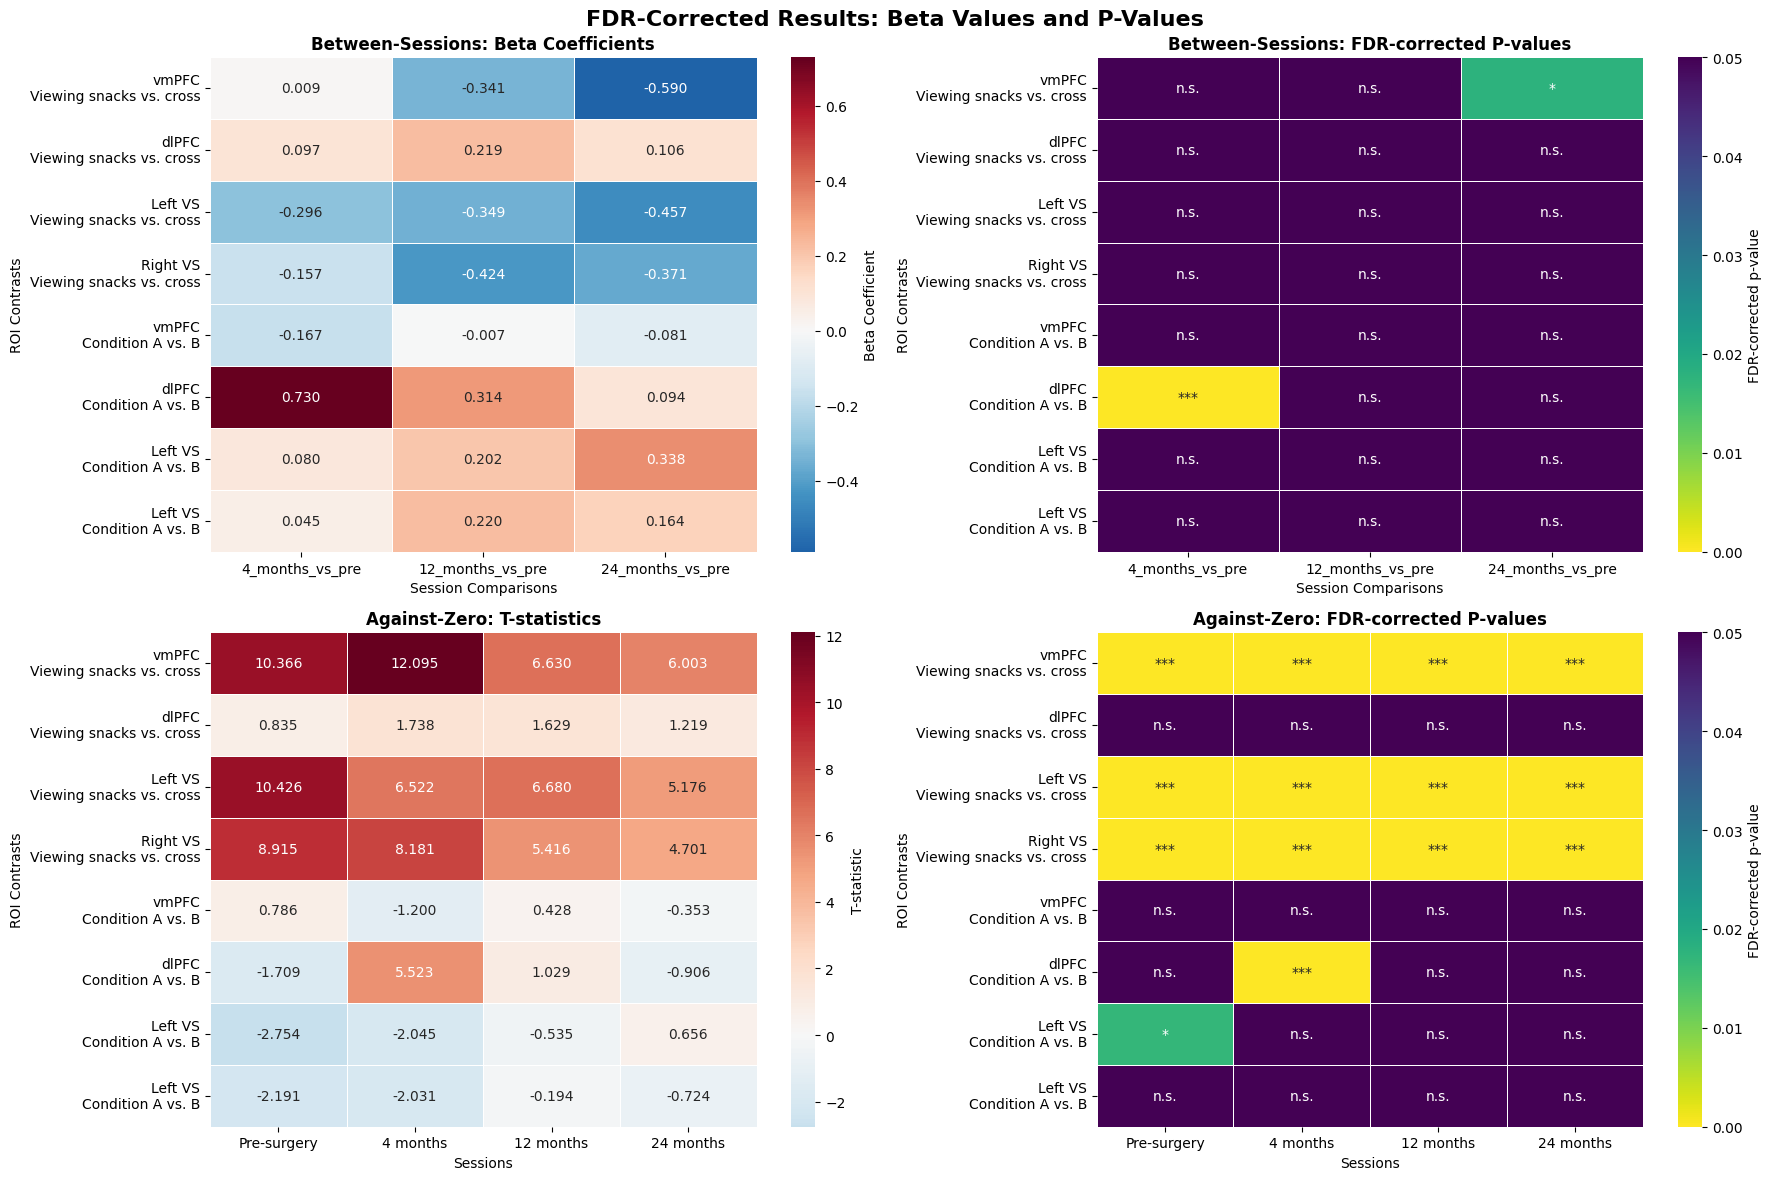


HEATMAP SUMMARY
Between-sessions comparisons: 2/24 significant after FDR correction
Against-zero comparisons: 14/32 significant after FDR correction

Legend: *** p<0.001, ** p<0.01, * p<0.05, n.s. = not significant

Creating focused heatmaps for each comparison type...

Between-Sessions Comparisons:


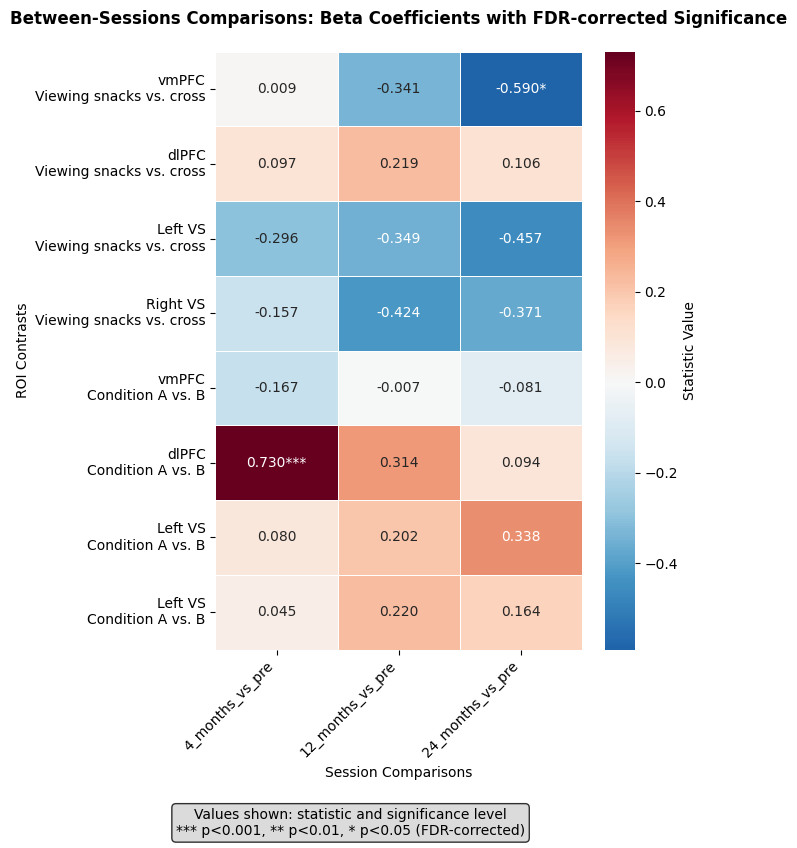


Against-Zero Comparisons:


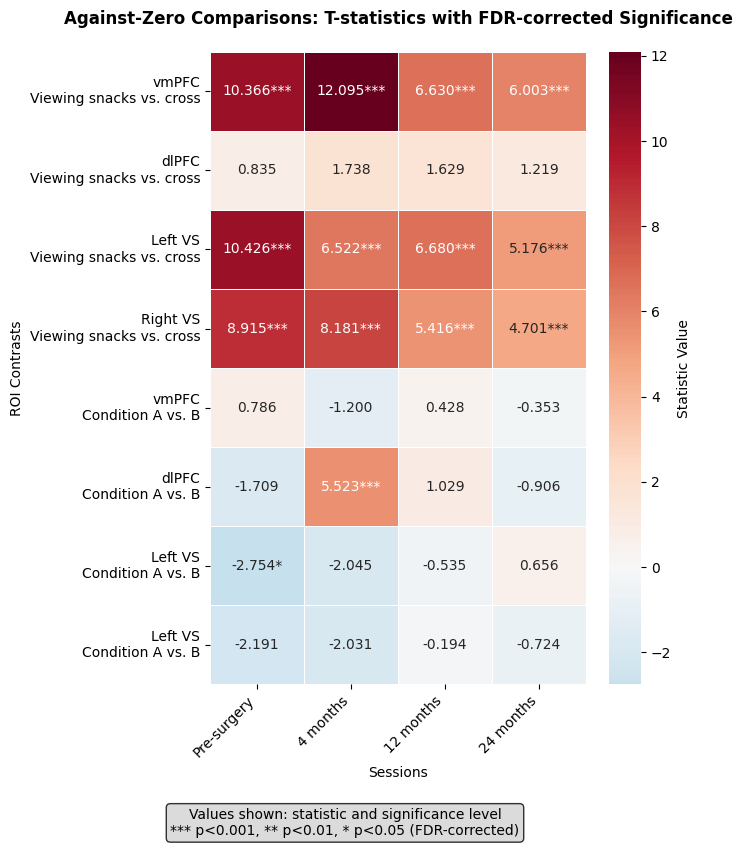

In [79]:
# Create comprehensive heatmaps from the FDR-corrected results
print("Creating comprehensive heatmaps showing both beta values and p-values...")

# Create the main 2x2 heatmap showing all results
create_fdr_results_heatmap(corrected_results, figsize=(18, 12))

print("\n" + "="*80)
print("Creating focused heatmaps for each comparison type...")
print("="*80)

# Create focused heatmap for between-sessions comparisons
print("\nBetween-Sessions Comparisons:")
create_combined_beta_pvalue_heatmap(corrected_results, 
                                   comparison_type='between_sessions', 
                                   figsize=(7, 8))

# Create focused heatmap for against-zero comparisons
print("\nAgainst-Zero Comparisons:")
create_combined_beta_pvalue_heatmap(corrected_results, 
                                   comparison_type='against_zero', 
                                   figsize=(7, 8))

# Withouth RGC

In [80]:
participants
participants_no_rgc = participants[~participants['id_participant'].astype(str).str.startswith('rgc')]


ANALYZING (no RGC): z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged
                                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged
No. Observations: 237     Method:             REML                                                           
No. Groups:       73      Scale:              0.9982                                                         
Min. group size:  1       Log-Likelihood:     -371.2161                                                      
Max. group size:  4       Converged:          Yes                                                            
Mean group size:  3.2                                                                                        
-----------------------------------------------------------------------------------------------------------------------
                           Coef.            Std.Err.         

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

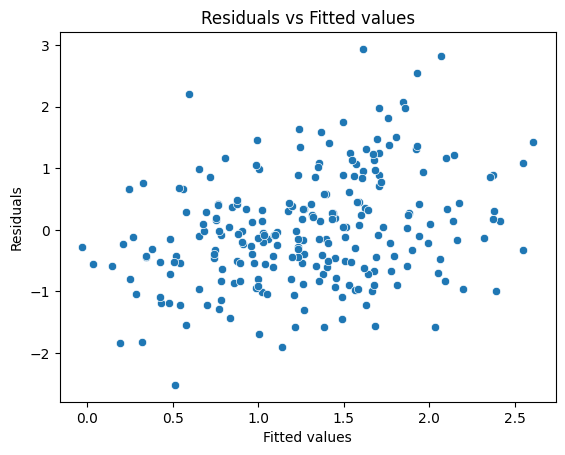

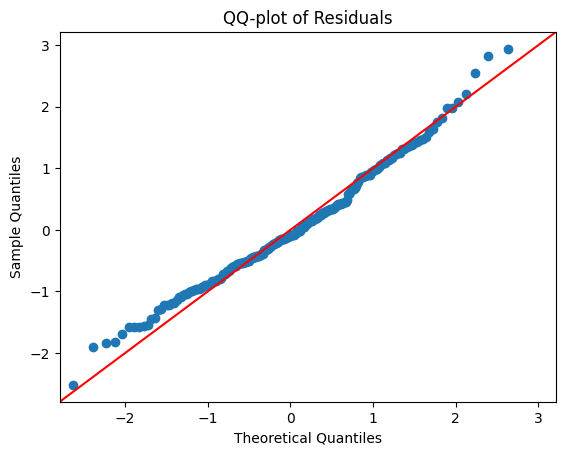

Breusch-Pagan test p-value: 0.7168068721656993
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.03696328541870807
Residuals are not normally distributed.
        feature         VIF
0     Intercept  177.710961
1  session[T.2]    1.452721
2  session[T.3]    1.421560
3  session[T.4]    1.447390
4      type_chx    1.178186
5           age    1.205824
6  IMC_baseline    1.063375
7          sexe    1.084064
                                    chi2                 P>chi2  df constraint
Intercept          [[2.207149567069652]]     0.1373722884188251              1
session           [[16.968150459927443]]  0.0007174821168142882              3
type_chx         [[0.05606188158634386]]     0.8128321975913331              1
age               [[4.0280132936516955]]    0.04475061016424949              1
IMC_baseline      [[1.7542201503557318]]     0.1853470790698307              1
sexe          [[7.5422578554901855e-06]]       0.99780875870621      

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


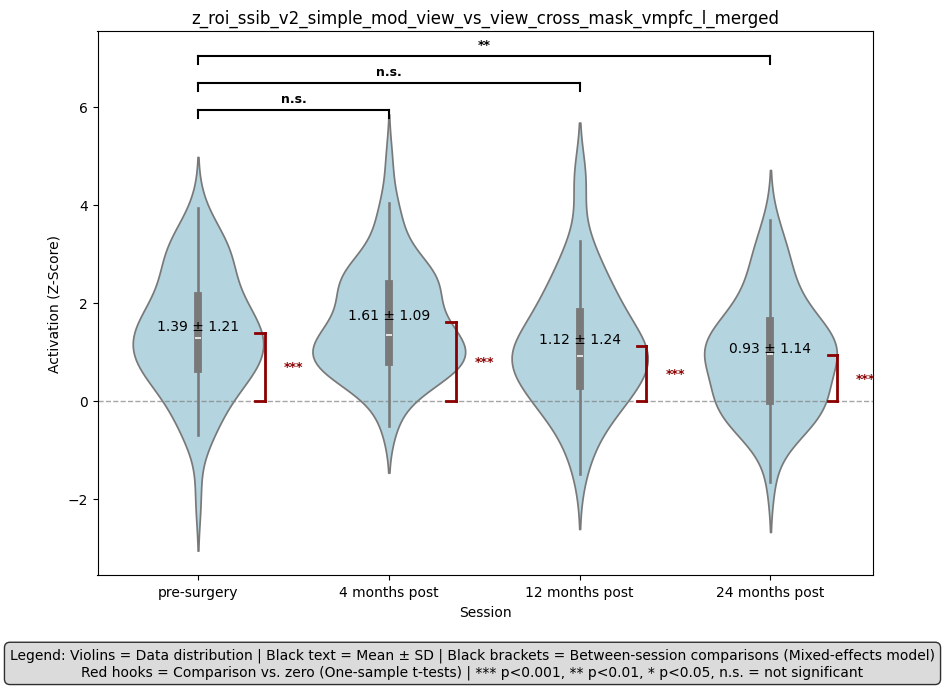


ANALYZING (no RGC): z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlPFC_R_merged
                                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlpfc_r_merged
No. Observations: 234     Method:             REML                                                           
No. Groups:       73      Scale:              1.1533                                                         
Min. group size:  1       Log-Likelihood:     -406.9957                                                      
Max. group size:  4       Converged:          Yes                                                            
Mean group size:  3.2                                                                                        
-----------------------------------------------------------------------------------------------------------------------
                           Coef.            Std.Err.         

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

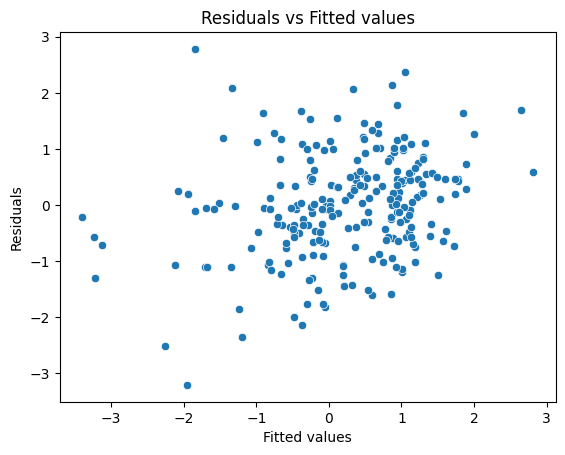

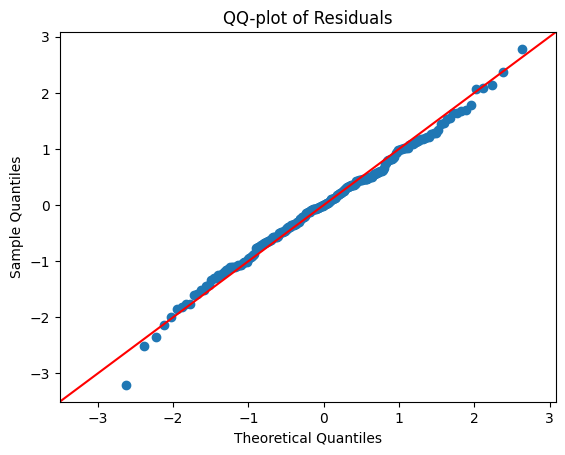

Breusch-Pagan test p-value: 0.05414288134156686
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.8578948114709195
Residuals are normally distributed.
        feature         VIF
0     Intercept  175.870457
1  session[T.2]    1.454217
2  session[T.3]    1.426861
3  session[T.4]    1.447912
4      type_chx    1.189141
5           age    1.220044
6  IMC_baseline    1.066262
7          sexe    1.085039
                                 chi2                 P>chi2  df constraint
Intercept       [[6.932613733154255]]   0.008463790905764998              1
session         [[1.791062570097196]]     0.6168817494427676              3
type_chx       [[0.0968906874869094]]     0.7555933270168265              1
age           [[0.04130218534813858]]     0.8389557414900117              1
IMC_baseline    [[8.420803899413665]]  0.0037095174262956653              1
sexe          [[0.30895469213992205]]     0.5783223374152189              1
AIC: 831.991388

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


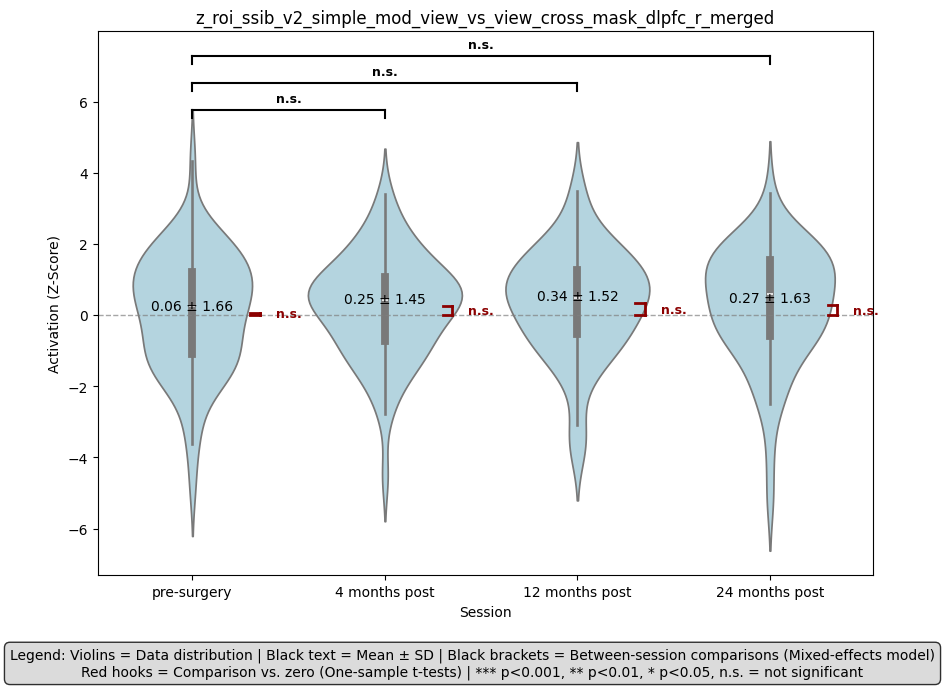


ANALYZING (no RGC): Z_ROI_ssib_v2_simple_mod_view_vs_view_cross_mask_VS_L


/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

                               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vs_l
No. Observations: 237     Method:             REML                                                 
No. Groups:       73      Scale:              0.8596                                               
Min. group size:  1       Log-Likelihood:     -358.2964                                            
Max. group size:  4       Converged:          Yes                                                  
Mean group size:  3.2                                                                              
-----------------------------------------------------------------------------------------------------------
                         Coef.          Std.Err.           z            P>|z|         [0.025         0.975]
-----------------------------------------------------------------------------------------------------------
Interce

/tmp/ipykernel_142322/999374792.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_val = mixed_model_fit.pvalues[session_indices[i]]
/tmp/ipykernel_142322/999374792.py:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = mixed_model_fit.params[session_indices[i]]


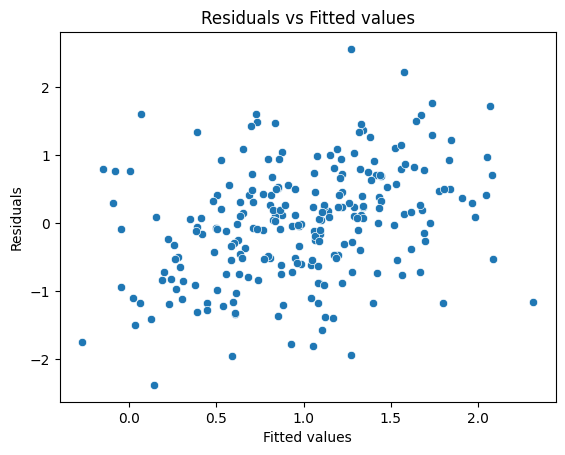

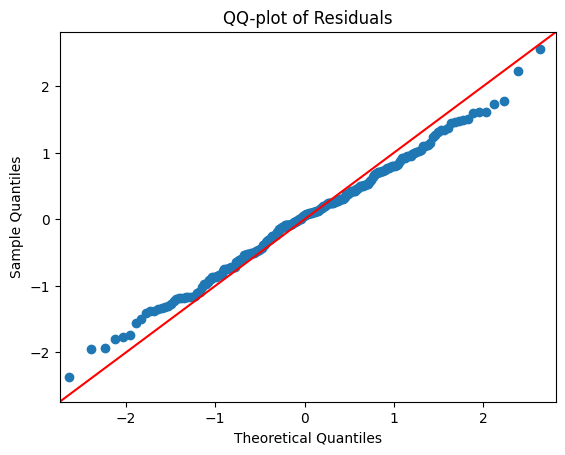

Breusch-Pagan test p-value: 0.6933345093410792
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.9233661509363854
Residuals are normally distributed.
        feature         VIF
0     Intercept  177.710961
1  session[T.2]    1.452721
2  session[T.3]    1.421560
3  session[T.4]    1.447390
4      type_chx    1.178186
5           age    1.205824
6  IMC_baseline    1.063375
7          sexe    1.084064
                                  chi2               P>chi2  df constraint
Intercept         [[2.95540653453681]]  0.08559077859819128              1
session          [[7.981702263864619]]  0.04639138224566639              3
type_chx        [[0.5847963903810144]]  0.44443840631116316              1
age           [[0.029561797532100833]]   0.8634882797761678              1
IMC_baseline    [[0.9836733852687806]]  0.32129358611571623              1
sexe            [[0.3231341307548953]]   0.5697302069492818              1
AIC: 734.5927883686049


/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


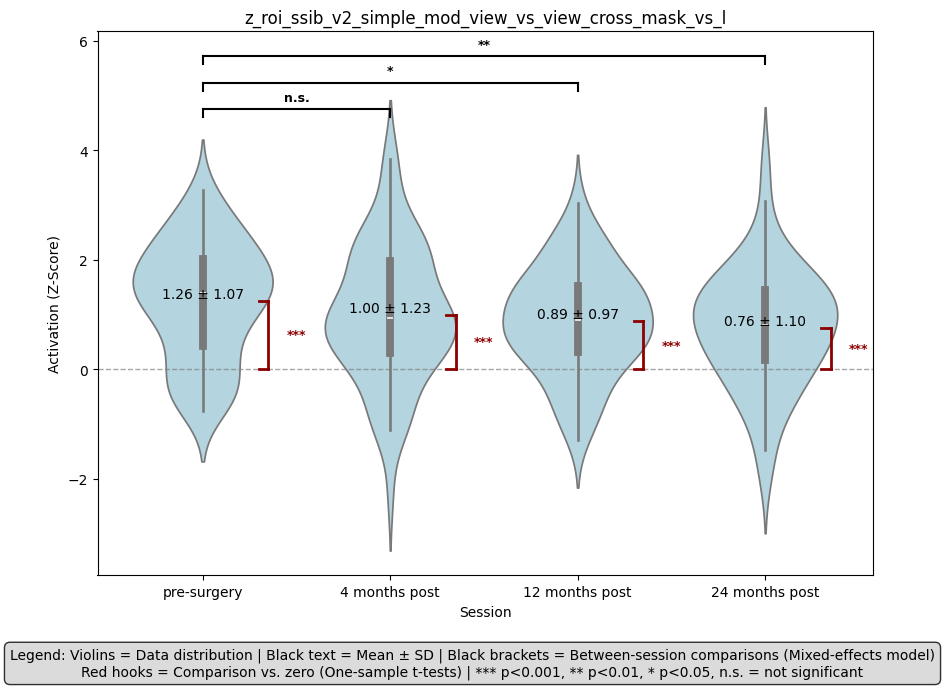


ANALYZING (no RGC): Z_ROI_ssib_v2_simple_mod_view_vs_view_cross_mask_VS_R
                               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vs_r
No. Observations: 237     Method:             REML                                                 
No. Groups:       73      Scale:              0.9493                                               
Min. group size:  1       Log-Likelihood:     -369.4697                                            
Max. group size:  4       Converged:          Yes                                                  
Mean group size:  3.2                                                                              
-----------------------------------------------------------------------------------------------------------
                         Coef.          Std.Err.           z            P>|z|         [0.025         0.975]
----------------------------------------

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

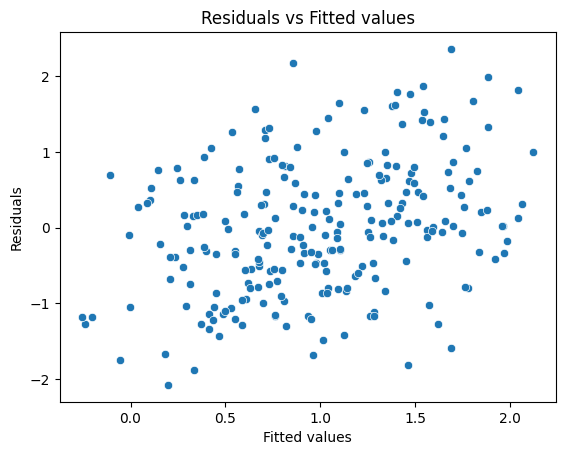

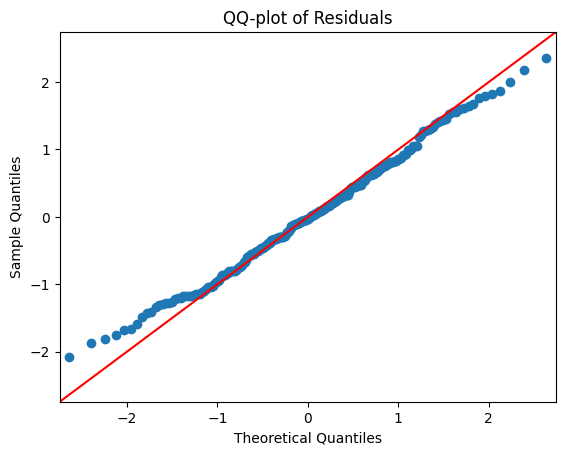

Breusch-Pagan test p-value: 0.35612161199377595
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.31668041468575714
Residuals are normally distributed.
        feature         VIF
0     Intercept  177.710961
1  session[T.2]    1.452721
2  session[T.3]    1.421560
3  session[T.4]    1.447390
4      type_chx    1.178186
5           age    1.205824
6  IMC_baseline    1.063375
7          sexe    1.084064
                                  chi2                P>chi2  df constraint
Intercept        [[4.215547123018013]]  0.040055146737281624              1
session          [[7.789470729364306]]  0.050569112750540504              3
type_chx      [[0.015353509890871716]]    0.9013871044942525              1
age           [[0.001955524283297193]]    0.9647279955167154              1
IMC_baseline    [[2.0831155210161985]]   0.14893591824234725              1
sexe          [[0.040578361772117155]]    0.8403539814623834              1
AIC: 756.93935

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


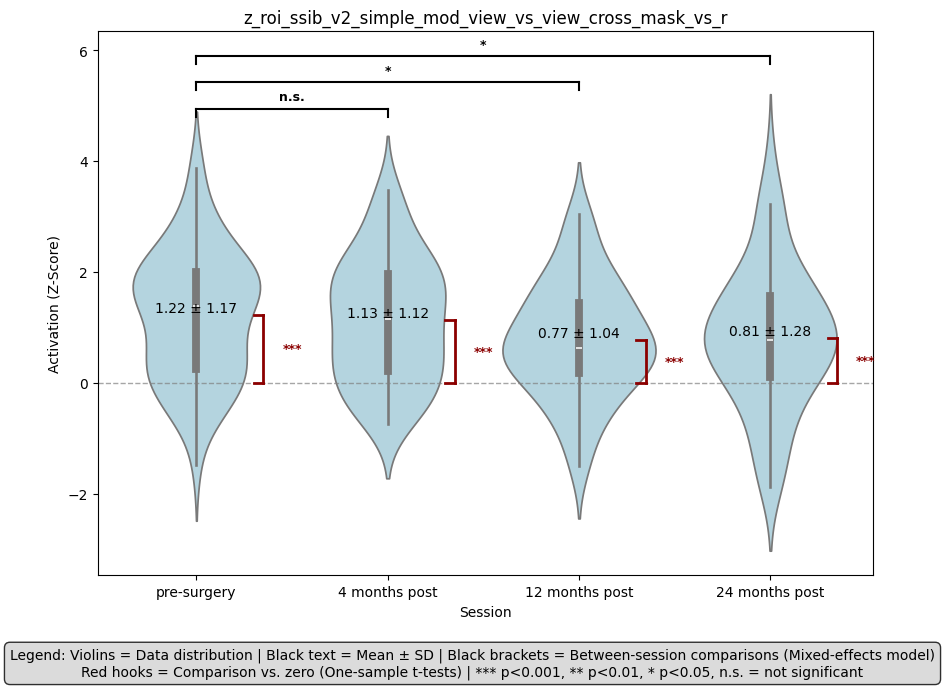


ANALYZING (no RGC): Z_ROI_ssib_v1_Hi_vs_Lo_mask_vmPFC_L_merged


/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

                         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_hi_vs_lo_mask_vmpfc_l_merged
No. Observations: 237     Method:             REML                                      
No. Groups:       73      Scale:              0.7142                                    
Min. group size:  1       Log-Likelihood:     -308.1338                                 
Max. group size:  4       Converged:          No                                        
Mean group size:  3.2                                                                   
----------------------------------------------------------------------------------------------
                      Coef.        Std.Err.         z          P>|z|       [0.025       0.975]
----------------------------------------------------------------------------------------------
Intercept             -0.932          0.735       -1.268       0.205       -2.372        0.508
session[T.2]          -

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.551491
  warnings.warn(msg, ConvergenceWarning)
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_142322/999374792.py:72: FutureWarning: Series.__getitem__ treating k

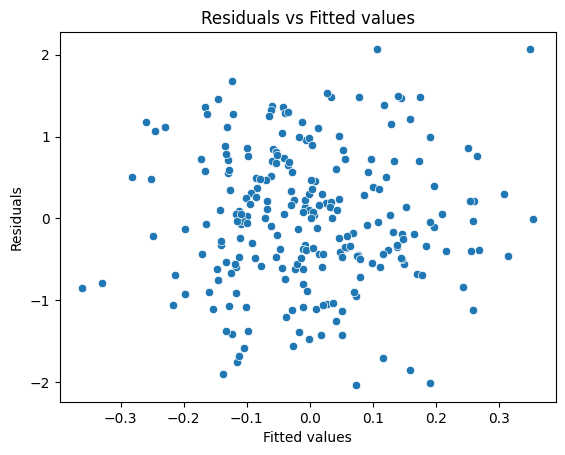

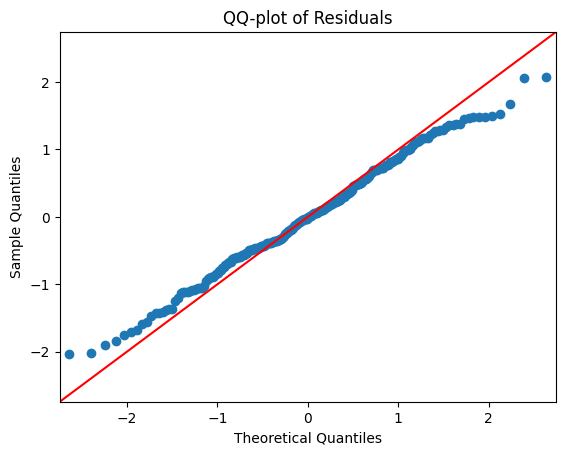

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


Breusch-Pagan test p-value: 0.18798488190160298
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.36231023608081947
Residuals are normally distributed.
        feature         VIF
0     Intercept  177.710961
1  session[T.2]    1.452721
2  session[T.3]    1.421560
3  session[T.4]    1.447390
4      type_chx    1.178186
5           age    1.205824
6  IMC_baseline    1.063375
7          sexe    1.084064
                                   chi2               P>chi2  df constraint
Intercept        [[1.6080181842228518]]  0.20477060820311338              1
session          [[0.8374699694398228]]   0.8404852951464624              3
type_chx         [[0.5034781153984342]]   0.4779758421177882              1
age              [[0.3785259805087722]]   0.5383931641783157              1
IMC_baseline     [[3.8465349735803573]]  0.04984887367346359              1
sexe          [[8.072332999771834e-06]]   0.9977330652923184              1
AIC: 634.26759

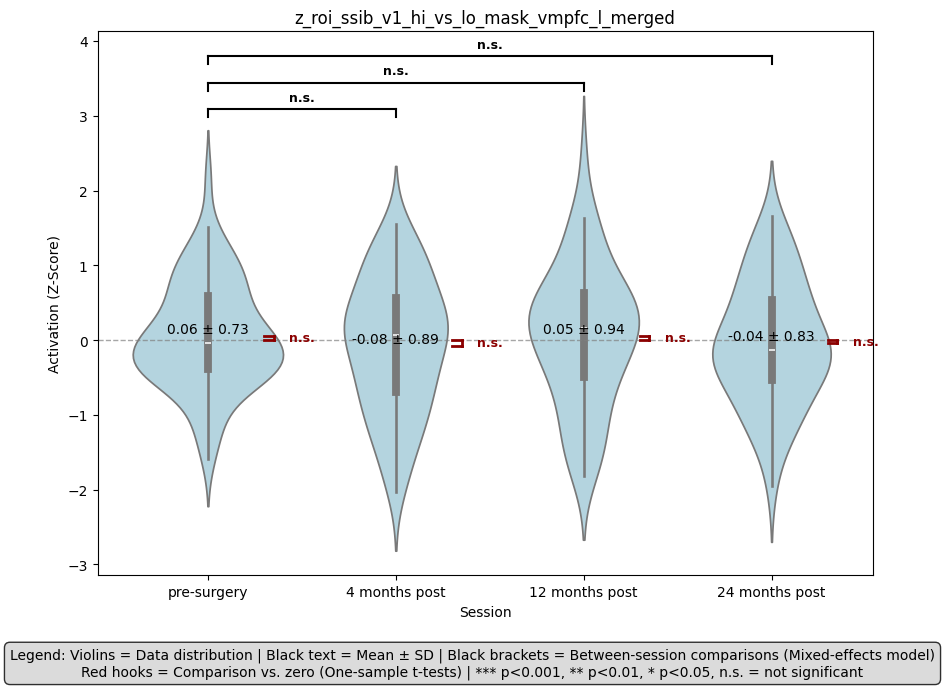


ANALYZING (no RGC): Z_ROI_ssib_v1_Hi_vs_Lo_mask_dlPFC_R_merged
                         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_hi_vs_lo_mask_dlpfc_r_merged
No. Observations: 234     Method:             REML                                      
No. Groups:       73      Scale:              0.7582                                    
Min. group size:  1       Log-Likelihood:     -323.7371                                 
Max. group size:  4       Converged:          Yes                                       
Mean group size:  3.2                                                                   
----------------------------------------------------------------------------------------------
                      Coef.        Std.Err.         z          P>|z|       [0.025       0.975]
----------------------------------------------------------------------------------------------
Intercept              0.244          0.921        0.2

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

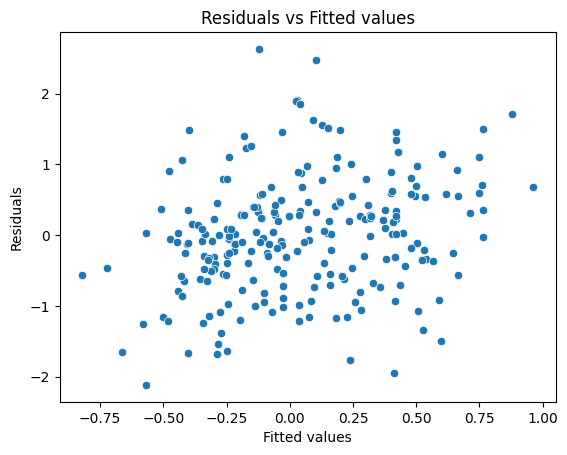

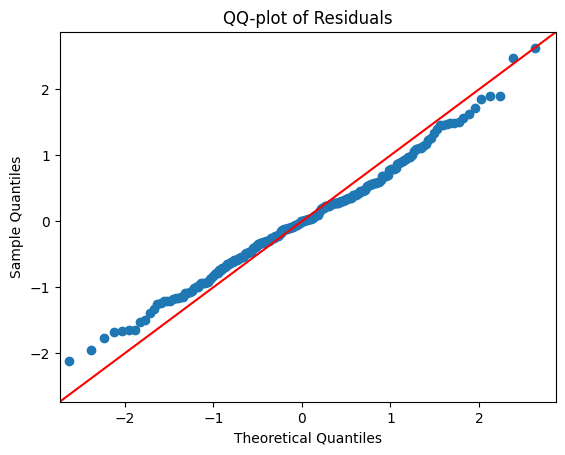

Breusch-Pagan test p-value: 0.2103224092944686
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.3867817869562289
Residuals are normally distributed.
        feature         VIF
0     Intercept  175.870457
1  session[T.2]    1.454217
2  session[T.3]    1.426861
3  session[T.4]    1.447912
4      type_chx    1.189141
5           age    1.220044
6  IMC_baseline    1.066262
7          sexe    1.085039
                                  chi2                  P>chi2  df constraint
Intercept      [[0.07037440605074244]]      0.7907924236121117              1
session         [[23.288244378948285]]  3.5164447719239704e-05              3
type_chx       [[0.07836836802147795]]      0.7795208461246859              1
age           [[0.014286935792680963]]      0.9048570814223844              1
IMC_baseline   [[0.11728260335525795]]      0.7320006199018361              1
sexe            [[0.5376162412222626]]     0.46342231575953696              1
AI

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


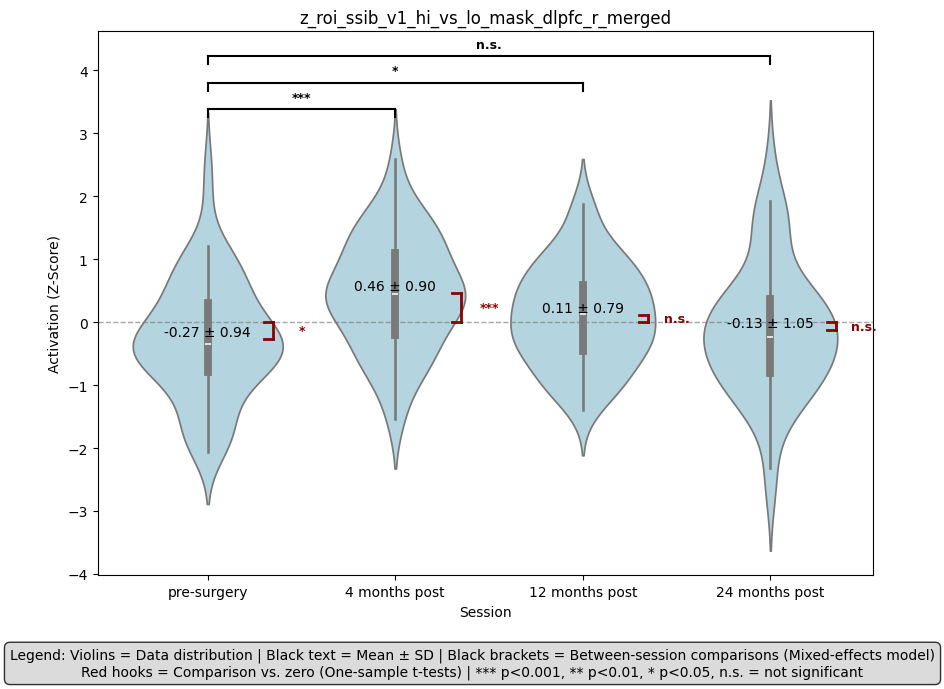


ANALYZING (no RGC): Z_ROI_ssib_v1_Hi_vs_Lo_mask_VS_L
                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_hi_vs_lo_mask_vs_l
No. Observations: 237     Method:             REML                            
No. Groups:       73      Scale:              0.6643                          
Min. group size:  1       Log-Likelihood:     -314.2929                       
Max. group size:  4       Converged:          Yes                             
Mean group size:  3.2                                                         
----------------------------------------------------------------------------------
                    Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
----------------------------------------------------------------------------------
Intercept           -0.581        0.883     -0.658     0.510     -2.312      1.150
session[T.2]         0.038        0.146      0.263     0.793     -0.247      0.324

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

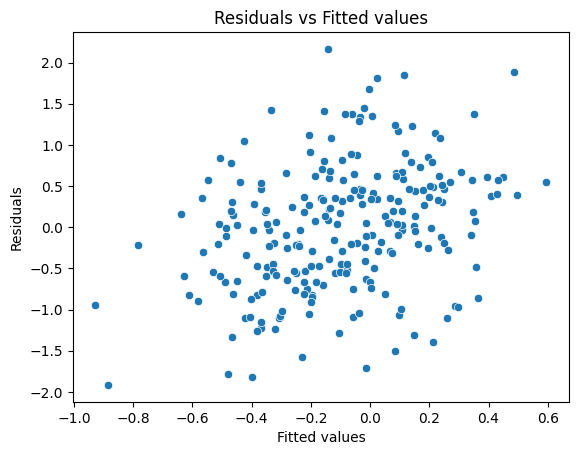

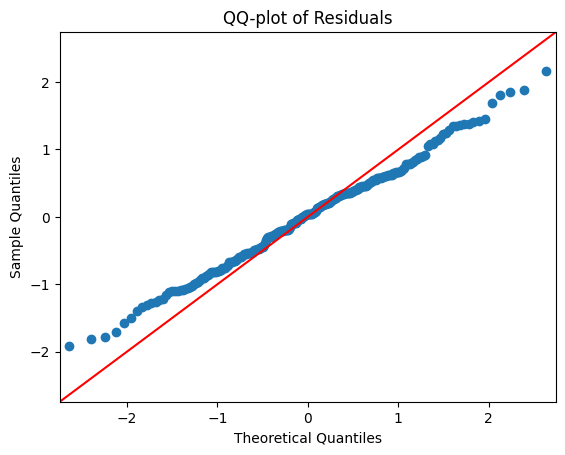

Breusch-Pagan test p-value: 0.30715956133594635
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.6694490720618445
Residuals are normally distributed.
        feature         VIF
0     Intercept  177.710961
1  session[T.2]    1.452721
2  session[T.3]    1.421560
3  session[T.4]    1.447390
4      type_chx    1.178186
5           age    1.205824
6  IMC_baseline    1.063375
7          sexe    1.084064
                                  chi2               P>chi2  df constraint
Intercept      [[0.43304470278351354]]   0.5104987283848779              1
session         [[3.7608216695557357]]  0.28847623440707976              3
type_chx         [[2.650342928970527]]   0.1035275604625764              1
age             [[0.6136448502540106]]    0.433418750881593              1
IMC_baseline  [[0.035094630404004186]]   0.8513975052157697              1
sexe           [[0.46805116305552164]]   0.4938850934523308              1
AIC: 646.5858622017336

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


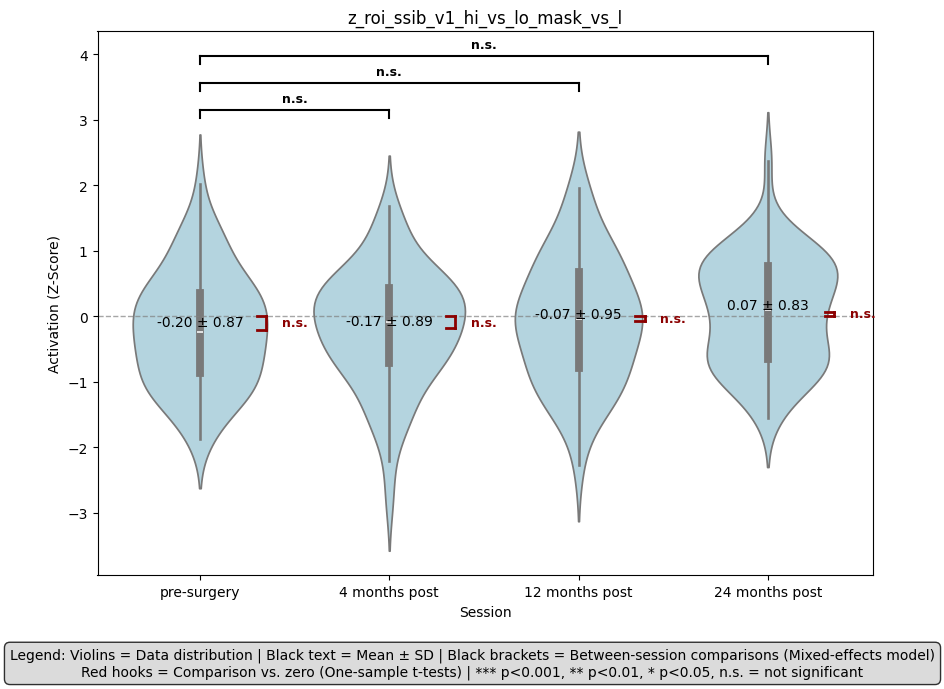


ANALYZING (no RGC): Z_ROI_ssib_v1_Hi_vs_Lo_mask_VS_R
                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_hi_vs_lo_mask_vs_r
No. Observations: 237     Method:             REML                            
No. Groups:       73      Scale:              0.8043                          
Min. group size:  1       Log-Likelihood:     -338.5312                       
Max. group size:  4       Converged:          Yes                             
Mean group size:  3.2                                                         
----------------------------------------------------------------------------------
                    Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
----------------------------------------------------------------------------------
Intercept           -0.474        1.006     -0.471     0.637     -2.446      1.498
session[T.2]         0.065        0.161      0.403     0.687     -0.250      0.379

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

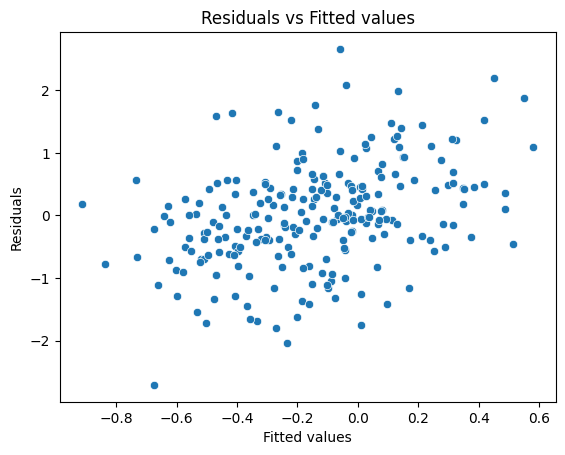

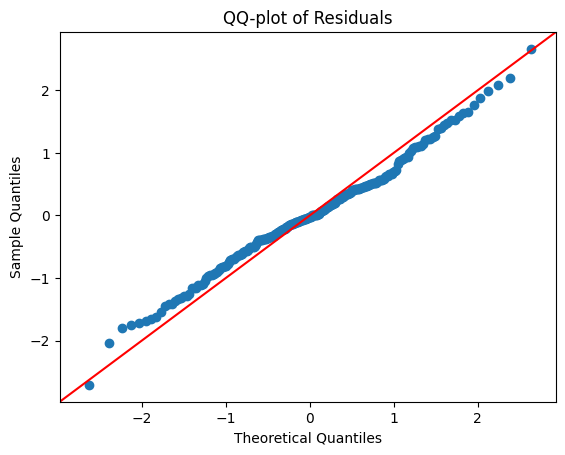

Breusch-Pagan test p-value: 0.4592464798371265
No heteroscedasticity detected. The variance of residuals is constant.
Shapiro-Wilk test p-value: 0.3314237529380535
Residuals are normally distributed.
        feature         VIF
0     Intercept  177.710961
1  session[T.2]    1.452721
2  session[T.3]    1.421560
3  session[T.4]    1.447390
4      type_chx    1.178186
5           age    1.205824
6  IMC_baseline    1.063375
7          sexe    1.084064
                                 chi2               P>chi2  df constraint
Intercept     [[0.22211104822768907]]   0.6374360918979107              1
session         [[2.004256408244517]]    0.571523741181531              3
type_chx      [[0.37933832245121424]]   0.5379575678353572              1
age            [[0.6922850960885906]]  0.40538822070706715              1
IMC_baseline  [[0.07438193966482279]]   0.7850603677829511              1
sexe           [[0.4356610435163786]]   0.5092241540853777              1
AIC: 695.0623089277001
BIC: 72

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipykernel_142322/999374792.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values = [mixed_model_fit.pvalues[i] for i in indices]


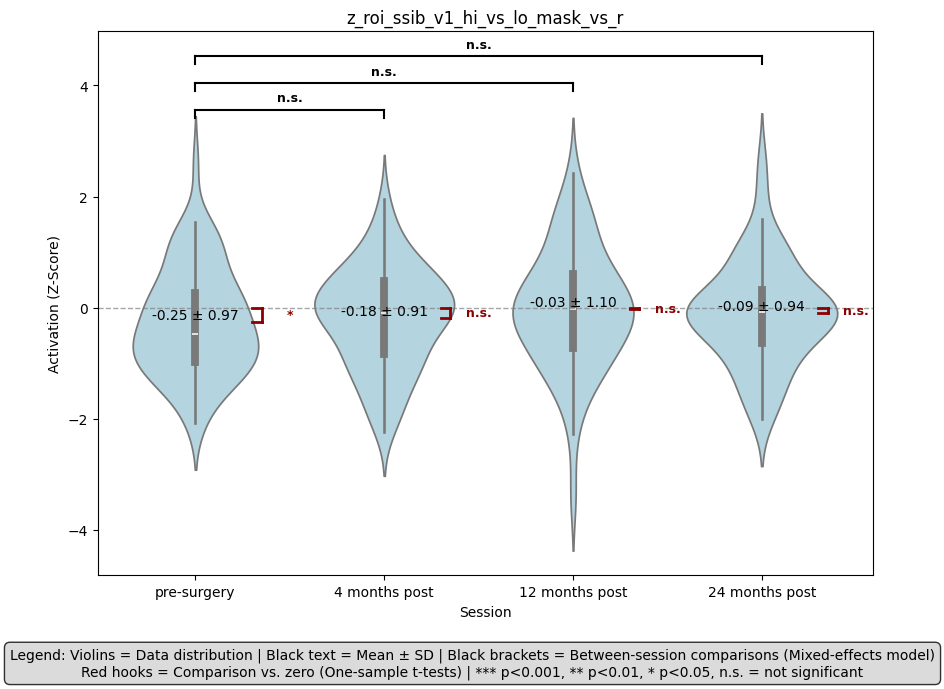


PERFORMING FDR CORRECTION ON ALL CONTRASTS (no RGC)
=== FDR CORRECTION RESULTS: BETWEEN-SESSIONS COMPARISONS ===
Method: fdr_bh, Alpha: 0.05
Number of tests: 24
Number of significant results (FDR-corrected): 2

                                                            ROI       Comparison    Beta  P_raw  P_FDR Significant_FDR
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged  4_months_vs_pre  0.1633 0.3632 0.5425              No
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged 12_months_vs_pre -0.2998 0.1099 0.2930              No
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged 24_months_vs_pre -0.5579 0.0033 0.0397             Yes
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlpfc_r_merged  4_months_vs_pre  0.1709 0.3843 0.5425              No
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlpfc_r_merged 12_months_vs_pre  0.2686 0.1914 0.3827              No
z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlpfc_r_merged 24_months_

/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

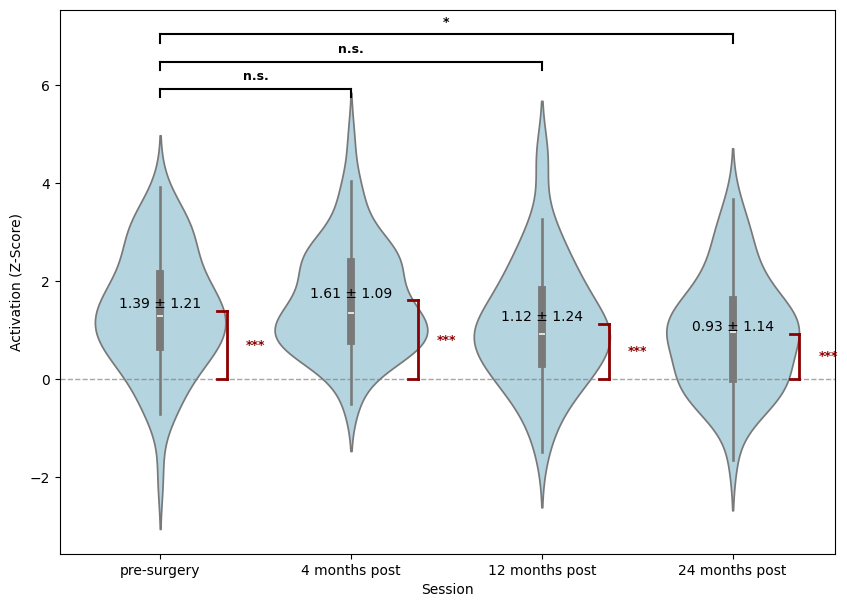


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.542482 (n.s.)
  12_months_vs_pre: p_FDR = 0.293013 (n.s.)
  24_months_vs_pre: p_FDR = 0.039697 (*)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.000000 (***)
  4 months: p_FDR = 0.000000 (***)
  12 months: p_FDR = 0.000000 (***)
  24 months: p_FDR = 0.000001 (***)

🎨 Regenerating graph for: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlPFC_R_merged


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

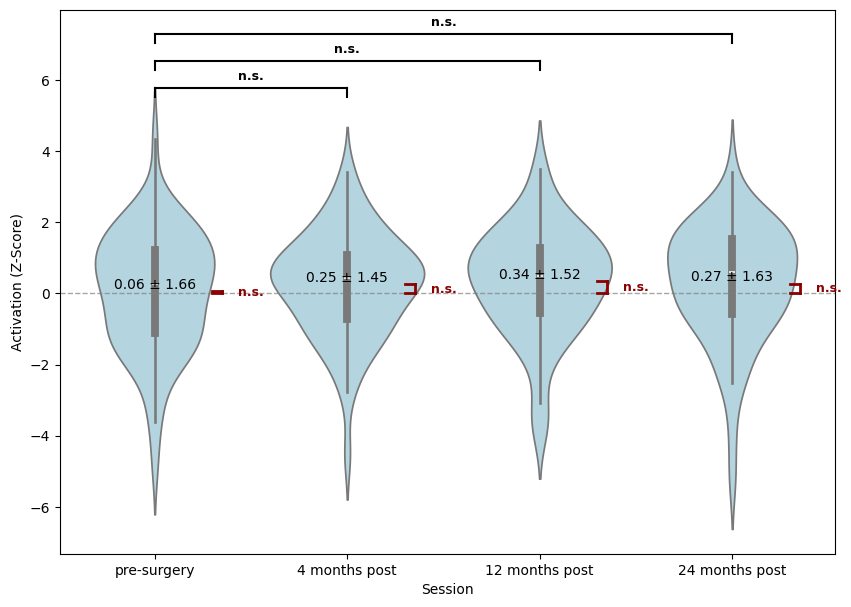


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlpfc_r_merged

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.542482 (n.s.)
  12_months_vs_pre: p_FDR = 0.382712 (n.s.)
  24_months_vs_pre: p_FDR = 0.583175 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.801301 (n.s.)
  4 months: p_FDR = 0.283089 (n.s.)
  12 months: p_FDR = 0.205763 (n.s.)
  24 months: p_FDR = 0.347843 (n.s.)

🎨 Regenerating graph for: Z_ROI_ssib_v2_simple_mod_view_vs_view_cross_mask_VS_L


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

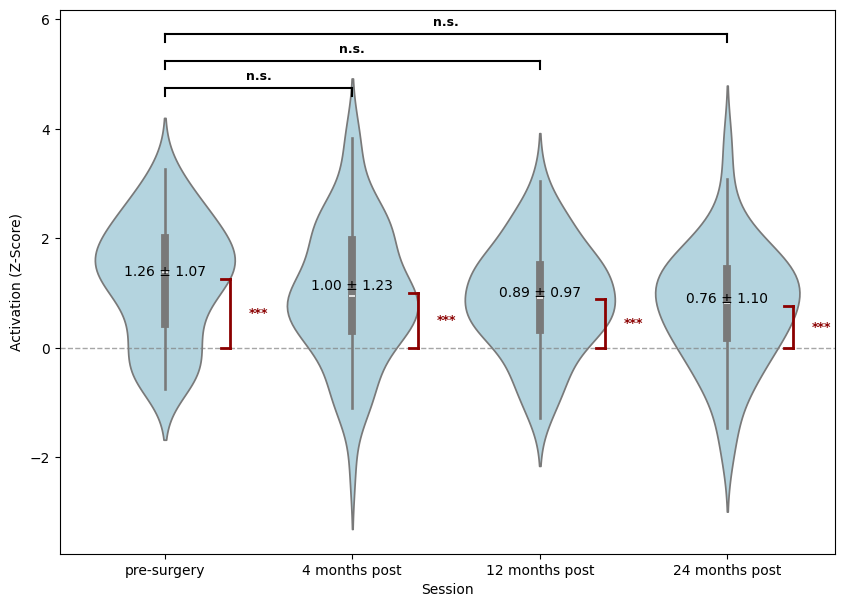


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vs_l

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.335556 (n.s.)
  12_months_vs_pre: p_FDR = 0.149264 (n.s.)
  24_months_vs_pre: p_FDR = 0.059038 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.000000 (***)
  4 months: p_FDR = 0.000000 (***)
  12 months: p_FDR = 0.000000 (***)
  24 months: p_FDR = 0.000010 (***)

🎨 Regenerating graph for: Z_ROI_ssib_v2_simple_mod_view_vs_view_cross_mask_VS_R


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

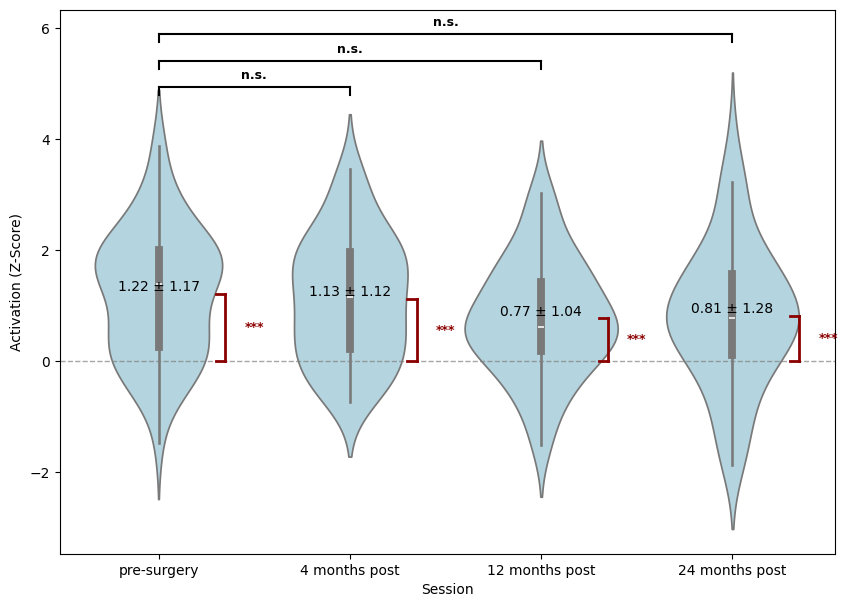


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vs_r

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.732954 (n.s.)
  12_months_vs_pre: p_FDR = 0.107407 (n.s.)
  24_months_vs_pre: p_FDR = 0.149264 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.000000 (***)
  4 months: p_FDR = 0.000000 (***)
  12 months: p_FDR = 0.000005 (***)
  24 months: p_FDR = 0.000049 (***)

🎨 Regenerating graph for: Z_ROI_ssib_v1_Hi_vs_Lo_mask_vmPFC_L_merged


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

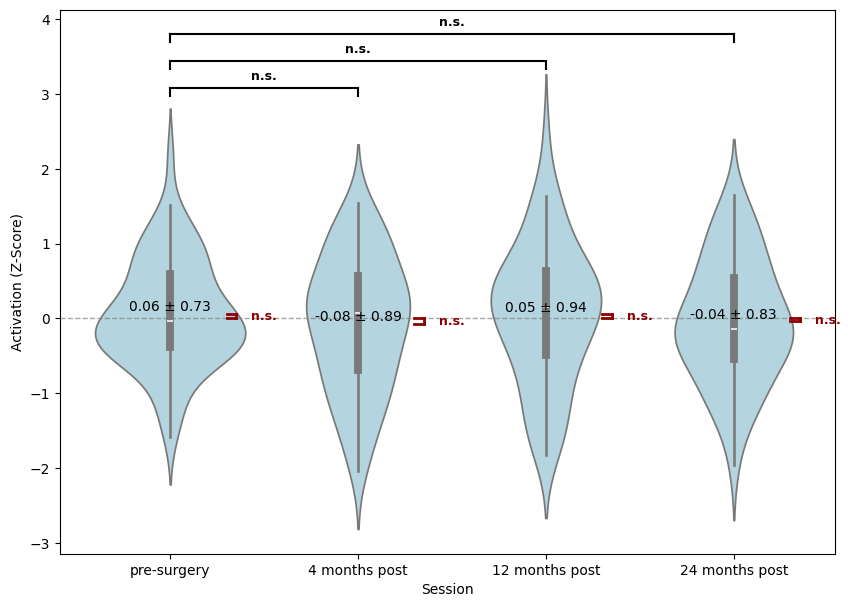


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v1_hi_vs_lo_mask_vmpfc_l_merged

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.583175 (n.s.)
  12_months_vs_pre: p_FDR = 0.997417 (n.s.)
  24_months_vs_pre: p_FDR = 0.732954 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.610024 (n.s.)
  4 months: p_FDR = 0.610024 (n.s.)
  12 months: p_FDR = 0.739495 (n.s.)
  24 months: p_FDR = 0.773626 (n.s.)

🎨 Regenerating graph for: Z_ROI_ssib_v1_Hi_vs_Lo_mask_dlPFC_R_merged


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

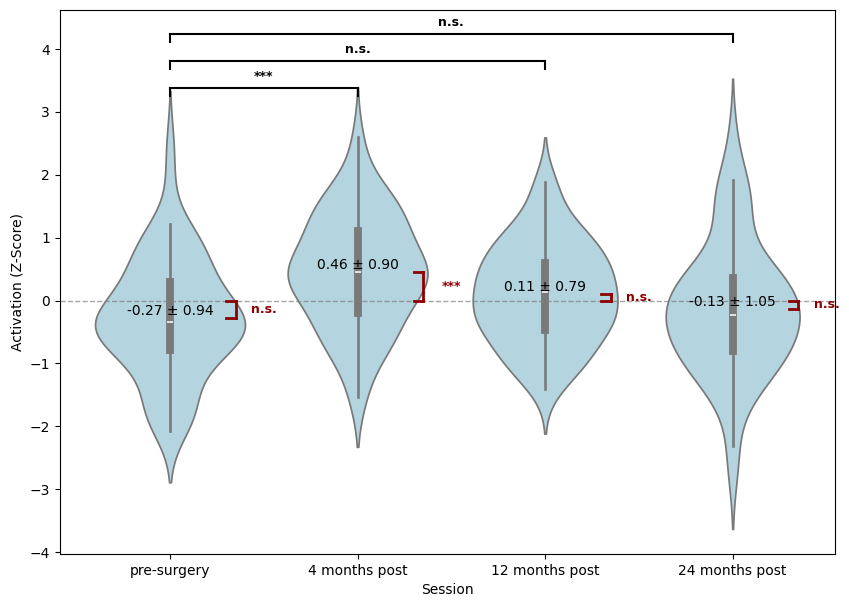


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v1_hi_vs_lo_mask_dlpfc_r_merged

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.000115 (***)
  12_months_vs_pre: p_FDR = 0.107407 (n.s.)
  24_months_vs_pre: p_FDR = 0.542482 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.054294 (n.s.)
  4 months: p_FDR = 0.000425 (***)
  12 months: p_FDR = 0.448313 (n.s.)
  24 months: p_FDR = 0.513468 (n.s.)

🎨 Regenerating graph for: Z_ROI_ssib_v1_Hi_vs_Lo_mask_VS_L


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

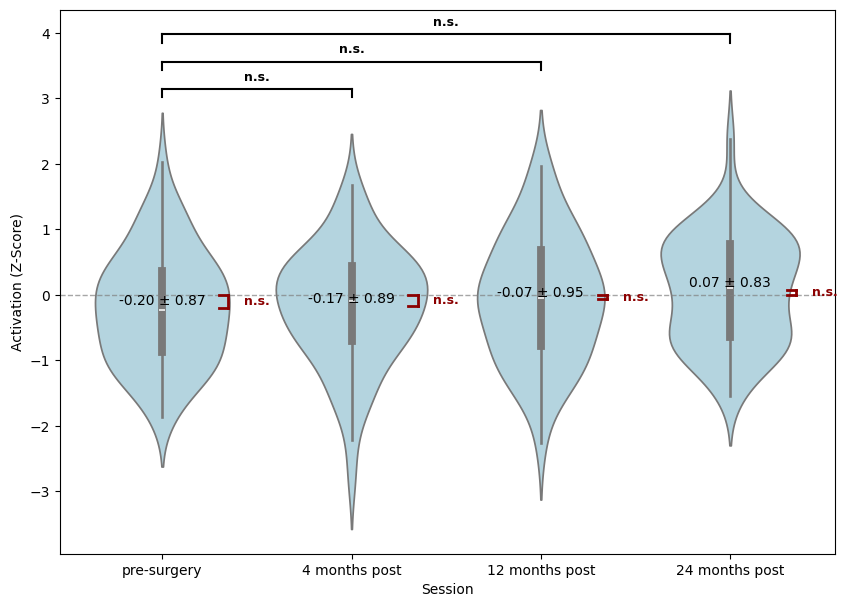


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v1_hi_vs_lo_mask_vs_l

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.827317 (n.s.)
  12_months_vs_pre: p_FDR = 0.542482 (n.s.)
  24_months_vs_pre: p_FDR = 0.219369 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.137649 (n.s.)
  4 months: p_FDR = 0.218163 (n.s.)
  12 months: p_FDR = 0.679607 (n.s.)
  24 months: p_FDR = 0.610024 (n.s.)

🎨 Regenerating graph for: Z_ROI_ssib_v1_Hi_vs_Lo_mask_VS_R


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

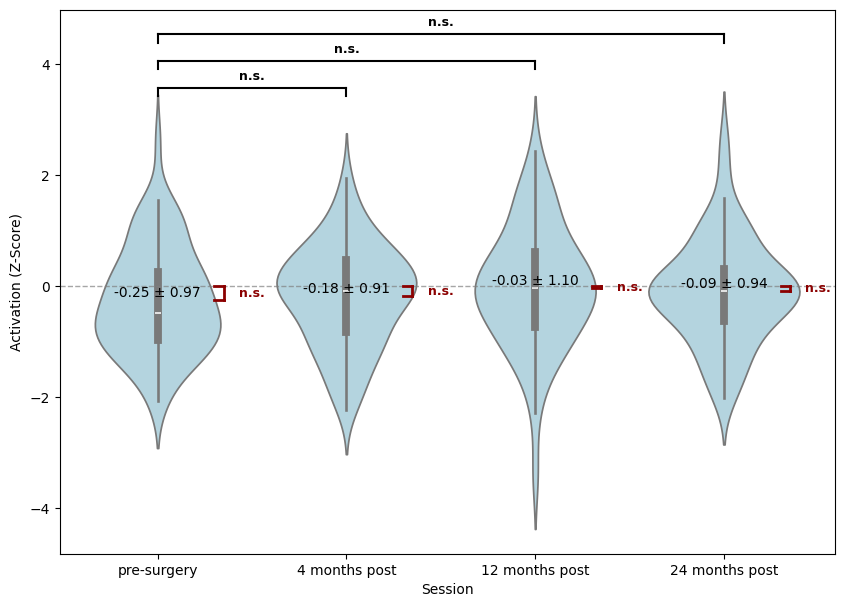


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v1_hi_vs_lo_mask_vs_r

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.749665 (n.s.)
  12_months_vs_pre: p_FDR = 0.382712 (n.s.)
  24_months_vs_pre: p_FDR = 0.542482 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.081243 (n.s.)
  4 months: p_FDR = 0.208544 (n.s.)
  12 months: p_FDR = 0.847253 (n.s.)
  24 months: p_FDR = 0.610024 (n.s.)


In [81]:
# Initialize dictionary for FDR correction
results_fdr_corrected_no_rgc = {}

# Build list of contrasts (reuse contrasts_to_analyze)
for contrast in contrasts_to_analyze:
    print(f"\n{'='*80}")
    print(f"ANALYZING (no RGC): {contrast}")
    print(f"{'='*80}")
    try:
        roi_analysis_GB(participants_no_rgc, contrast, results_storage=results_fdr_corrected_no_rgc, verbose=True, plot=True)
    except Exception as e:
        print(f"Error analyzing {contrast}: {e}")
        continue

print(f"\n{'='*80}")
print("PERFORMING FDR CORRECTION ON ALL CONTRASTS (no RGC)")
print(f"{'='*80}")

corrected_results_no_rgc = perform_fdr_correction(results_fdr_corrected_no_rgc, alpha=0.05, method='fdr_bh')

print(f"\n{'='*80}")
print("REGENERATING GRAPHS WITH FDR-CORRECTED P-VALUES (no RGC)")
print(f"{'='*80}")

regenerate_all_graphs_with_fdr(participants_no_rgc, contrasts_to_analyze, corrected_results_no_rgc)

# Remove participants that only have one session


ANALYZING (no RGC): z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged
                                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged
No. Observations: 234     Method:             REML                                                           
No. Groups:       70      Scale:              0.9982                                                         
Min. group size:  2       Log-Likelihood:     -366.4171                                                      
Max. group size:  4       Converged:          Yes                                                            
Mean group size:  3.3                                                                                        
-----------------------------------------------------------------------------------------------------------------------
                           Coef.            Std.Err.         

/tmp/ipykernel_142322/999374792.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/999374792.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/999374792.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part

                               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vs_r
No. Observations: 234     Method:             REML                                                 
No. Groups:       70      Scale:              0.9495                                               
Min. group size:  2       Log-Likelihood:     -364.5860                                            
Max. group size:  4       Converged:          Yes                                                  
Mean group size:  3.3                                                                              
-----------------------------------------------------------------------------------------------------------
                         Coef.          Std.Err.           z            P>|z|         [0.025         0.975]
-----------------------------------------------------------------------------------------------------------
Interce

/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/gagpat01/fmriprep_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to con

                         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: z_roi_ssib_v1_hi_vs_lo_mask_vmpfc_l_merged
No. Observations: 234     Method:             REML                                      
No. Groups:       70      Scale:              0.7182                                    
Min. group size:  2       Log-Likelihood:     -305.1451                                 
Max. group size:  4       Converged:          No                                        
Mean group size:  3.3                                                                   
----------------------------------------------------------------------------------------------
                      Coef.        Std.Err.         z          P>|z|       [0.025       0.975]
----------------------------------------------------------------------------------------------
Intercept             -0.943          0.747       -1.261       0.207       -2.408        0.522
session[T.2]          -

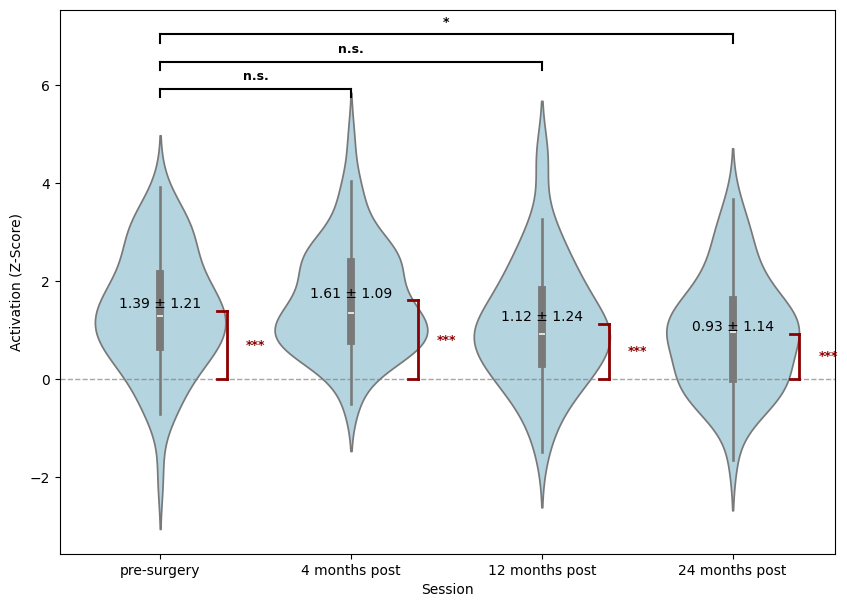


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vmpfc_l_merged

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.601206 (n.s.)
  12_months_vs_pre: p_FDR = 0.198773 (n.s.)
  24_months_vs_pre: p_FDR = 0.023274 (*)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.000000 (***)
  4 months: p_FDR = 0.000000 (***)
  12 months: p_FDR = 0.000000 (***)
  24 months: p_FDR = 0.000001 (***)

🎨 Regenerating graph for: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlPFC_R_merged


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

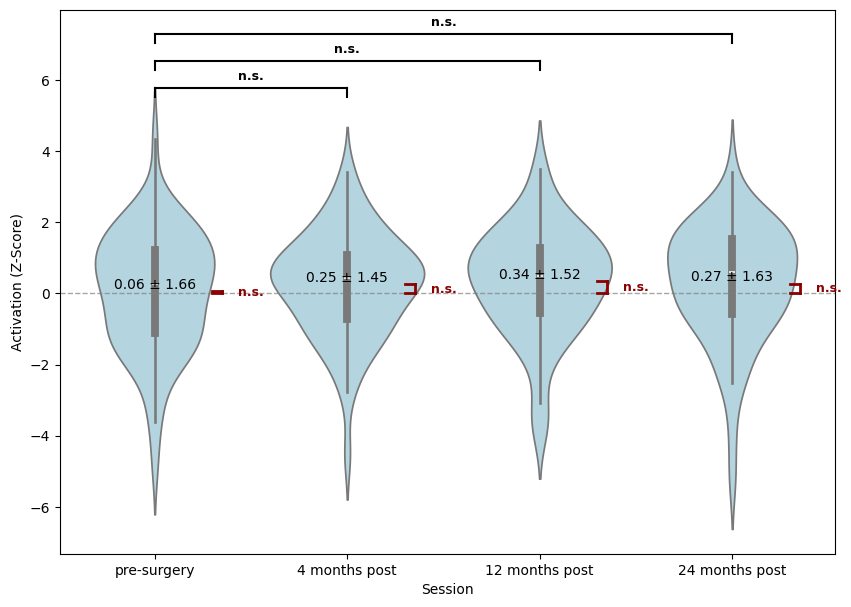


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_dlpfc_r_merged

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.593991 (n.s.)
  12_months_vs_pre: p_FDR = 0.462742 (n.s.)
  24_months_vs_pre: p_FDR = 0.601206 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.714845 (n.s.)
  4 months: p_FDR = 0.283089 (n.s.)
  12 months: p_FDR = 0.249353 (n.s.)
  24 months: p_FDR = 0.347843 (n.s.)

🎨 Regenerating graph for: Z_ROI_ssib_v2_simple_mod_view_vs_view_cross_mask_VS_L


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

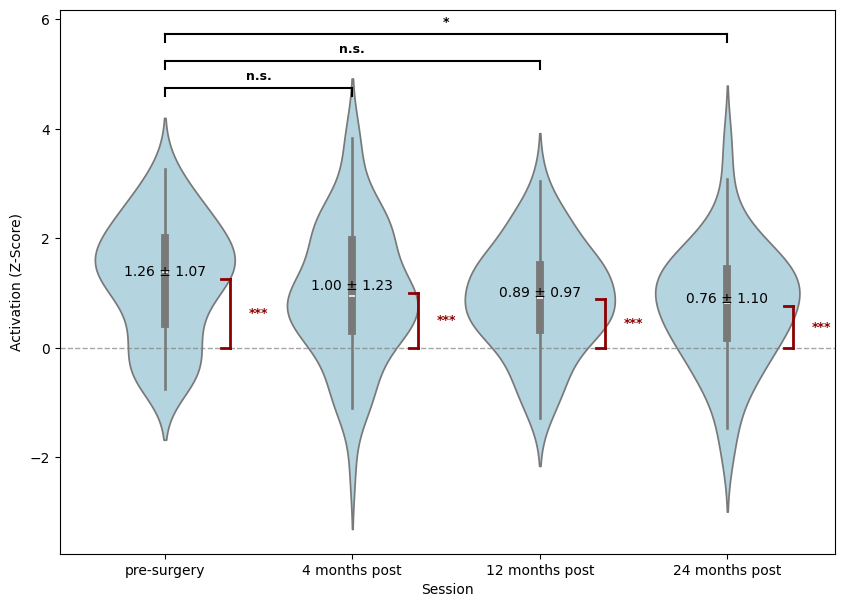


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vs_l

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.256324 (n.s.)
  12_months_vs_pre: p_FDR = 0.107118 (n.s.)
  24_months_vs_pre: p_FDR = 0.039948 (*)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.000000 (***)
  4 months: p_FDR = 0.000000 (***)
  12 months: p_FDR = 0.000000 (***)
  24 months: p_FDR = 0.000010 (***)

🎨 Regenerating graph for: Z_ROI_ssib_v2_simple_mod_view_vs_view_cross_mask_VS_R


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

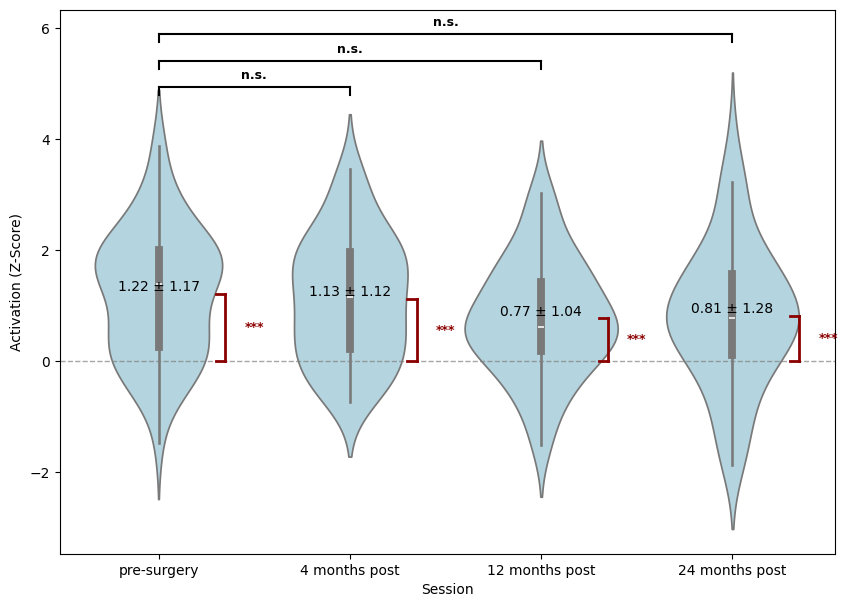


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v2_simple_mod_view_vs_view_cross_mask_vs_r

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.601206 (n.s.)
  12_months_vs_pre: p_FDR = 0.078019 (n.s.)
  24_months_vs_pre: p_FDR = 0.107118 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.000000 (***)
  4 months: p_FDR = 0.000000 (***)
  12 months: p_FDR = 0.000005 (***)
  24 months: p_FDR = 0.000049 (***)

🎨 Regenerating graph for: Z_ROI_ssib_v1_Hi_vs_Lo_mask_vmPFC_L_merged


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

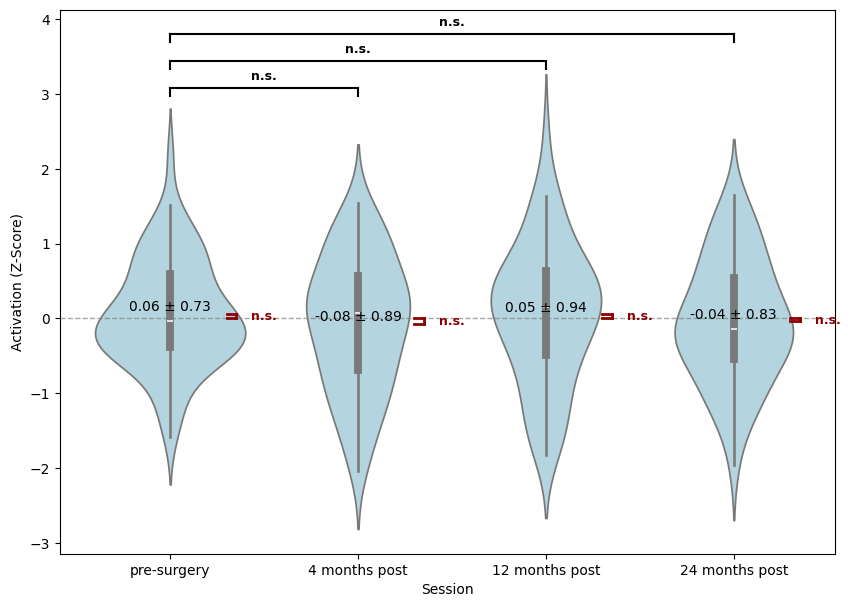


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v1_hi_vs_lo_mask_vmpfc_l_merged

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.542751 (n.s.)
  12_months_vs_pre: p_FDR = 0.871831 (n.s.)
  24_months_vs_pre: p_FDR = 0.601206 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.523407 (n.s.)
  4 months: p_FDR = 0.610024 (n.s.)
  12 months: p_FDR = 0.714845 (n.s.)
  24 months: p_FDR = 0.748670 (n.s.)

🎨 Regenerating graph for: Z_ROI_ssib_v1_Hi_vs_Lo_mask_dlPFC_R_merged


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

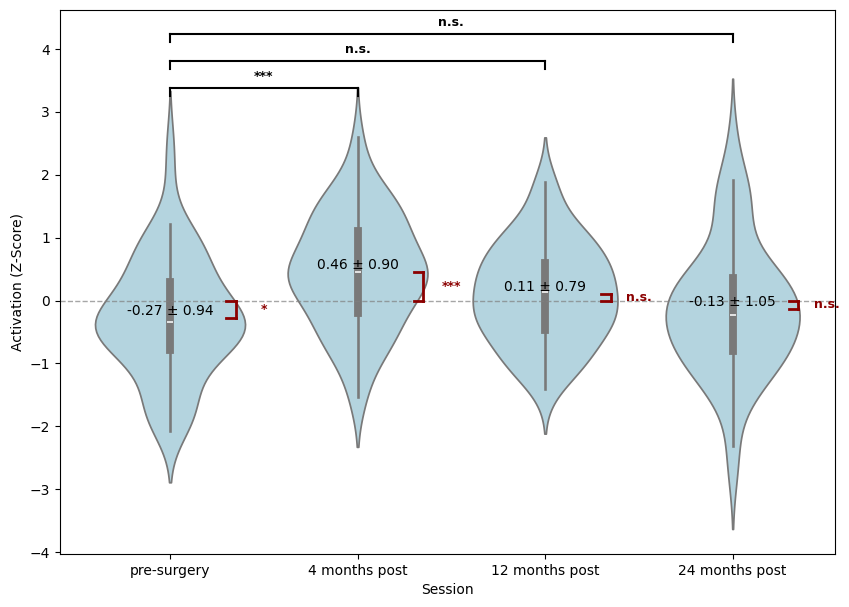


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v1_hi_vs_lo_mask_dlpfc_r_merged

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.000071 (***)
  12_months_vs_pre: p_FDR = 0.078019 (n.s.)
  24_months_vs_pre: p_FDR = 0.468792 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.035025 (*)
  4 months: p_FDR = 0.000425 (***)
  12 months: p_FDR = 0.467731 (n.s.)
  24 months: p_FDR = 0.513468 (n.s.)

🎨 Regenerating graph for: Z_ROI_ssib_v1_Hi_vs_Lo_mask_VS_L


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

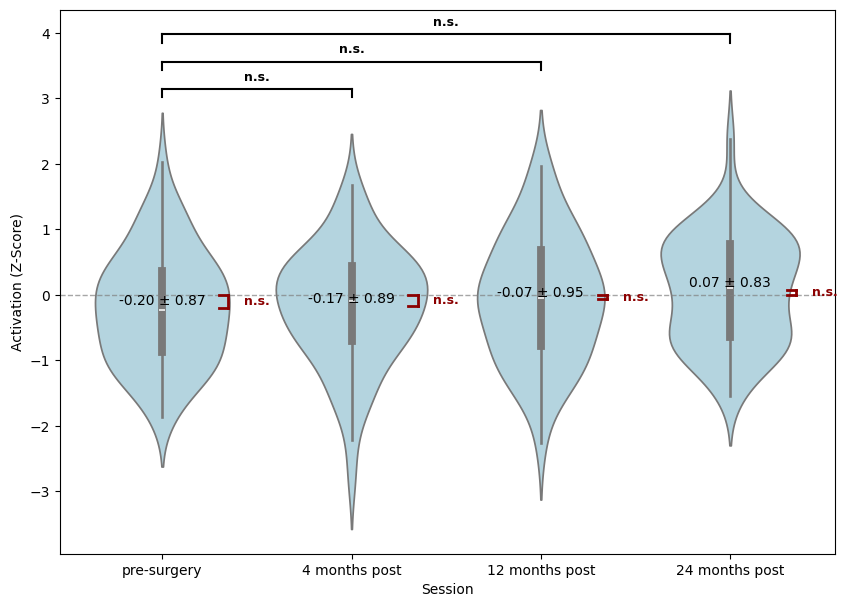


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v1_hi_vs_lo_mask_vs_l

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.648662 (n.s.)
  12_months_vs_pre: p_FDR = 0.462742 (n.s.)
  24_months_vs_pre: p_FDR = 0.116730 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.056429 (n.s.)
  4 months: p_FDR = 0.230283 (n.s.)
  12 months: p_FDR = 0.679607 (n.s.)
  24 months: p_FDR = 0.610024 (n.s.)

🎨 Regenerating graph for: Z_ROI_ssib_v1_Hi_vs_Lo_mask_VS_R


/tmp/ipykernel_142322/3140479303.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.drop(columns=[col for col in columns_to_remove if col in participants_ROI_contrast.columns], inplace=True)
/tmp/ipykernel_142322/3140479303.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_ROI_contrast.dropna(inplace=True)
/tmp/ipykernel_142322/3140479303.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p

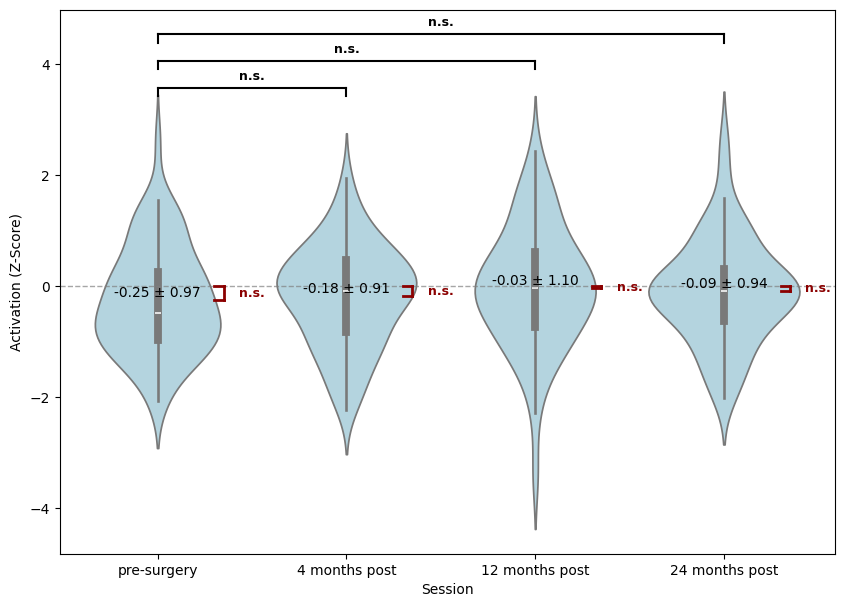


FDR-CORRECTED RESULTS FOR: z_roi_ssib_v1_hi_vs_lo_mask_vs_r

Between-session comparisons (FDR-corrected):
  4_months_vs_pre: p_FDR = 0.663019 (n.s.)
  12_months_vs_pre: p_FDR = 0.362557 (n.s.)
  24_months_vs_pre: p_FDR = 0.515667 (n.s.)

Against-zero comparisons (FDR-corrected):
  Pre-surgery: p_FDR = 0.068329 (n.s.)
  4 months: p_FDR = 0.220812 (n.s.)
  12 months: p_FDR = 0.847253 (n.s.)
  24 months: p_FDR = 0.604023 (n.s.)


In [84]:
# Initialize dictionary for FDR correction
results_fdr_corrected_no_rgc_no_2_ses = {}

# Build list of contrasts (reuse contrasts_to_analyze)
for contrast in contrasts_to_analyze:
    print(f"\n{'='*80}")
    print(f"ANALYZING (no RGC): {contrast}")
    print(f"{'='*80}")
    try:
        roi_analysis_GB(participants_no_rgc, contrast, results_storage=results_fdr_corrected_no_rgc_no_2_ses, verbose=True, plot=False,min_2_ses = True)
    except Exception as e:
        print(f"Error analyzing {contrast}: {e}")
        continue

print(f"\n{'='*80}")
print("PERFORMING FDR CORRECTION ON ALL CONTRASTS (no RGC)")
print(f"{'='*80}")

corrected_results_no_rgc_no_2_ses = perform_fdr_correction(results_fdr_corrected_no_rgc_no_2_ses, alpha=0.05, method='fdr_bh')

print(f"\n{'='*80}")
print("REGENERATING GRAPHS WITH FDR-CORRECTED P-VALUES (no RGC)")
print(f"{'='*80}")

regenerate_all_graphs_with_fdr(participants_no_rgc, contrasts_to_analyze, corrected_results_no_rgc_no_2_ses)

# Heat map no RGC min 2 ses

Creating comprehensive heatmaps showing both beta values and p-values...


/tmp/ipykernel_142322/3005226864.py:107: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sig_annotations = pval_df.applymap(lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else 'n.s.' if not np.isnan(x) else '')
/tmp/ipykernel_142322/3005226864.py:173: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sig_annotations_zero = pval_zero_df.applymap(lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else 'n.s.' if not np.isnan(x) else '')


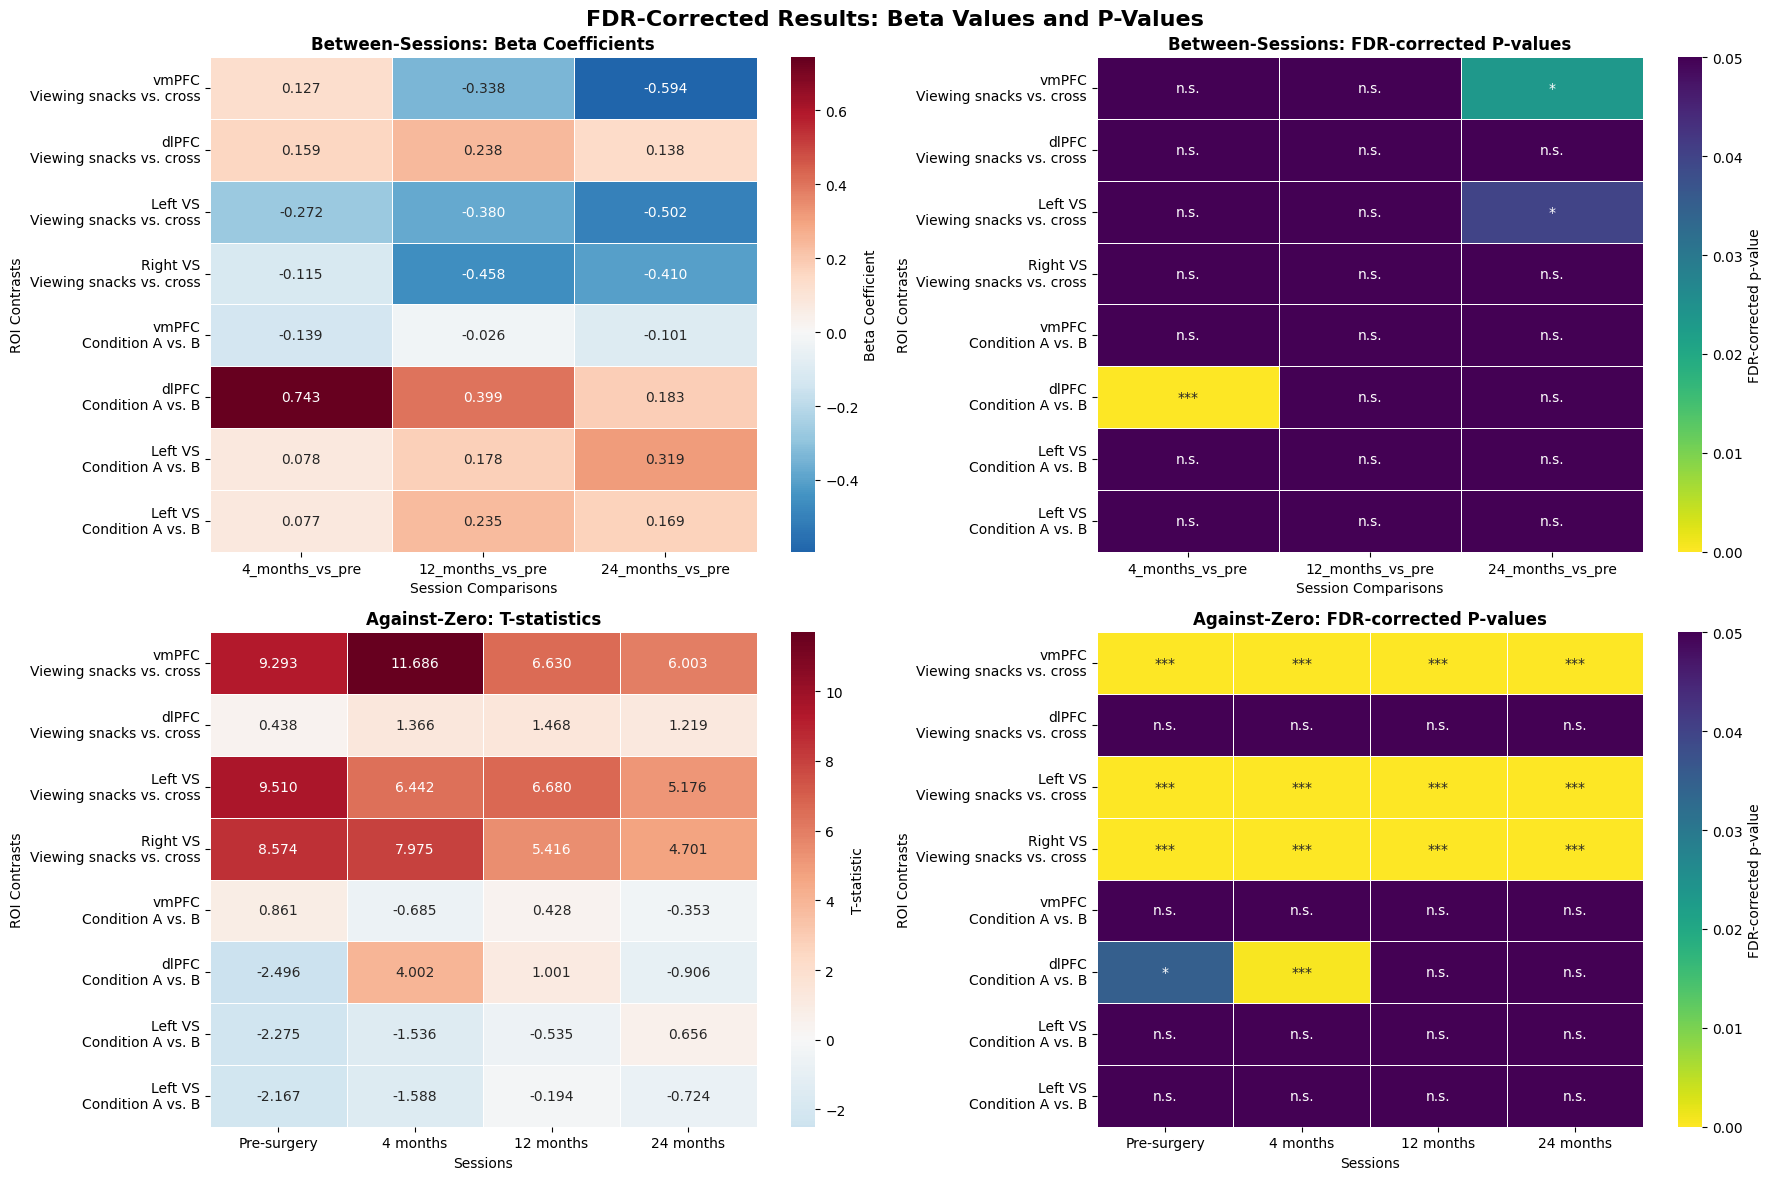


HEATMAP SUMMARY
Between-sessions comparisons: 3/24 significant after FDR correction
Against-zero comparisons: 14/32 significant after FDR correction

Legend: *** p<0.001, ** p<0.01, * p<0.05, n.s. = not significant

Creating focused heatmaps for each comparison type...

Between-Sessions Comparisons:


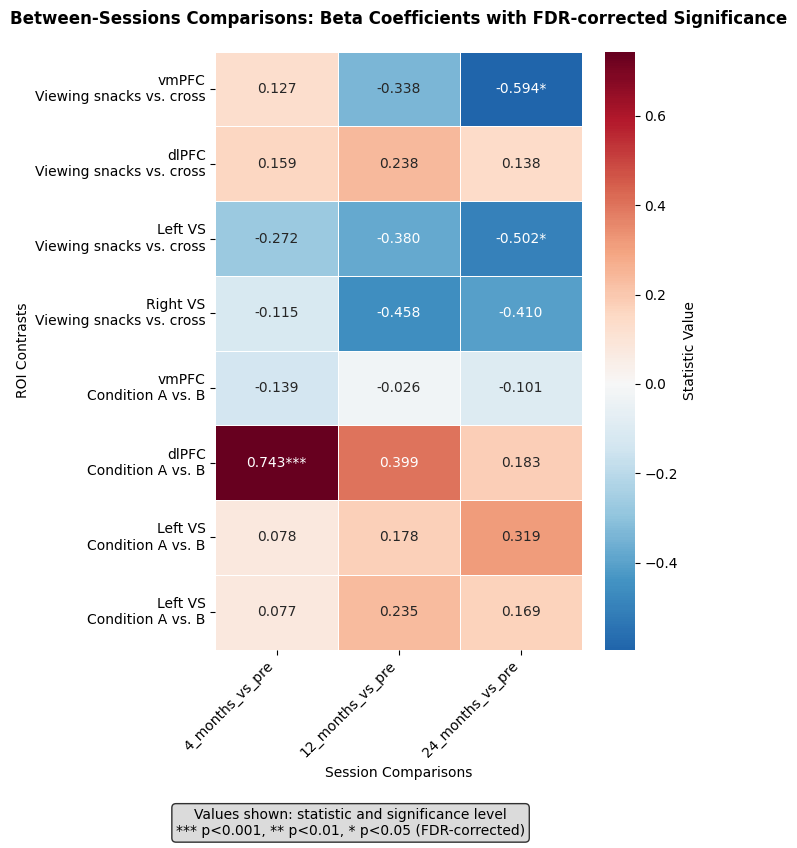


Against-Zero Comparisons:


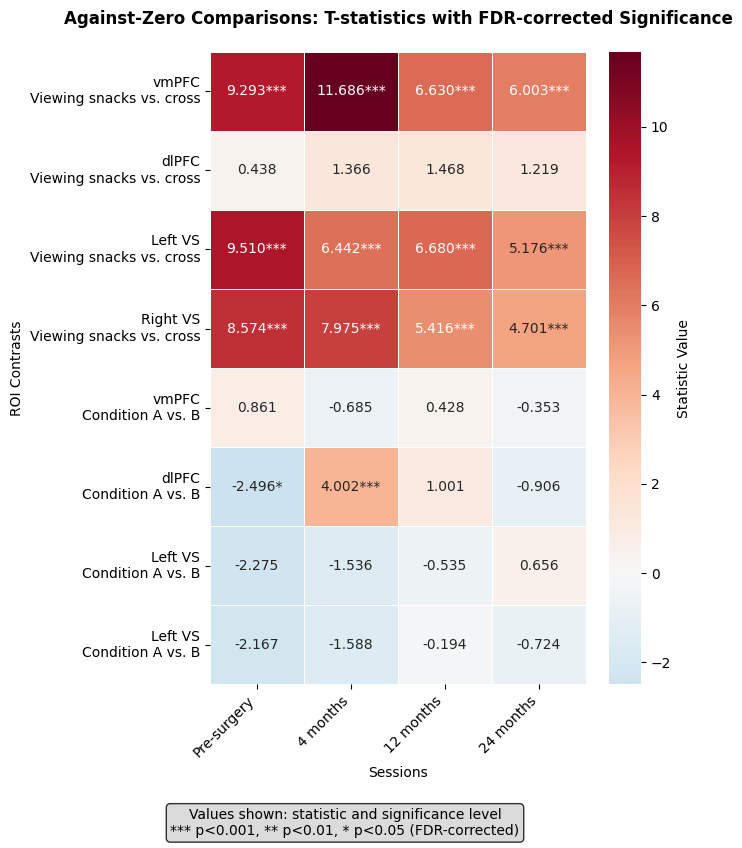

In [83]:
# Create comprehensive heatmaps from the FDR-corrected results
print("Creating comprehensive heatmaps showing both beta values and p-values...")

# Create the main 2x2 heatmap showing all results
create_fdr_results_heatmap(corrected_results_no_rgc_no_2_ses, figsize=(18, 12))

print("\n" + "="*80)
print("Creating focused heatmaps for each comparison type...")
print("="*80)

# Create focused heatmap for between-sessions comparisons
print("\nBetween-Sessions Comparisons:")
create_combined_beta_pvalue_heatmap(corrected_results_no_rgc_no_2_ses, 
                                   comparison_type='between_sessions', 
                                   figsize=(7, 8))

# Create focused heatmap for against-zero comparisons
print("\nAgainst-Zero Comparisons:")
create_combined_beta_pvalue_heatmap(corrected_results_no_rgc_no_2_ses, 
                                   comparison_type='against_zero', 
                                   figsize=(7, 8))